# Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell #display full output instead of just the last one
InteractiveShell.ast_node_interactivity = "all"

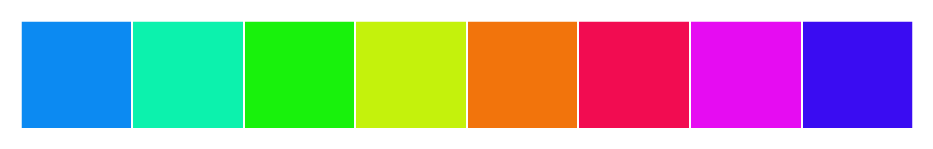

In [2]:
import toolz as fp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set()
%matplotlib inline
pd.set_option('display.max_rows', 50)
palette = sns.hls_palette(8, h=.7, s=.9, l=0.5)
sns.palplot(palette[::-1])
sns.set_palette(palette[::-1])

gray = "444444"

plt.rcParams['figure.facecolor'] = '1'  # background color
plt.rcParams['axes.facecolor'] = '1'  # plot background color

plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4

plt.rcParams['axes.edgecolor'] = '1'

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.linestyle'] = '-'

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray

plt.rcParams['text.color'] = gray

plt.rcParams['xtick.color'] = gray
plt.rcParams['ytick.color'] = gray
sns.set_style("whitegrid")
sns.set_context("notebook")
%config InlineBackend.figure_format = "retina"

In [3]:
import pickle
from pathlib import Path

class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
@fp.curry
def open_pickled_object(file, full_path):
    return pickle.load(open(full_path + "/" + file, "rb"))


In [4]:
def open_experiment(did, model_type="BINARY"):
    base_path = "../"+model_type
    full_path = base_path + "/" + str(did)
    open_object = open_pickled_object(full_path=full_path)
    if Path(base_path).is_dir() and Path(full_path).is_dir():
        return dotdict(
            dict(
                analyzer_info=open_object("analyzer_info.pkl"),
                df_stats=open_object("df_stats.pkl"),
                final_result=open_object("final_result.pkl"),
                hp_tree=open_object("hp_tree.pkl"),
                openml_object=open_object("openml_object.pkl"),
                shape=open_object("shape.pkl"),
            )
        )
    return {}

In [5]:
def get_all_available_experiments(model_type="BINARY"):
    base_path = "../" + model_type
    path = Path(base_path)
    return [int(x.name) for x in path.iterdir() if x.is_dir()]


def new_axis(figsize=(15, 8), title=None):
    _, ax = plt.subplots(figsize=figsize)
    if title is not None:
        ax.set_title(title, size=17)
    return ax

In [6]:
def build_experiment_stats(did_list, model_type="BINARY"):
    base_path = "../" + model_type
    if not Path(base_path).is_dir():
        raise ValueError("Base directory doesn't exist")
    stats_df = pd.DataFrame()
    open_stats = open_pickled_object(file="df_stats.pkl")
    for did in did_list:
        full_path = base_path + "/" + str(did)
        full_path_posix = Path(base_path + "/" + str(did))
        if full_path_posix.is_dir():
            stats_df = pd.concat(
                (stats_df,
                 open_stats(full_path=full_path).T.assign(did=did)
                 )
            )
    return stats_df

# Open an experiment

In [59]:
experiment = open_experiment(did=3)
experiment.keys()

dict_keys(['analyzer_info', 'df_stats', 'final_result', 'hp_tree', 'openml_object', 'shape'])

In [40]:
def build_result_dataframe(log_list):
    all_experiments = []
    for base_result in log_list:
        train_key, test_key = "train_result", "test_result"
        base_df = pd.DataFrame(fp.dissoc(base_result, train_key, test_key), index=range(2))
        metrics_df = pd.concat((pd.DataFrame(base_result[train_key], index=[0]).assign(type="train"),
                                pd.DataFrame(base_result[test_key], index=[0]).assign(type="test"))).reset_index(drop=True)
        all_experiments.append(pd.concat((base_df, metrics_df), axis=1))
    return pd.concat((exp for exp in all_experiments), sort=False, ignore_index=True)


In [6]:
did_3_results = build_result_dataframe(experiment.final_result)
did_3_results.shape
did_3_results.head()

learning_rate  seed  nthread  verbose training_time  auc_evaluator__target  \
0       0.010653    42       32       -1       0.163 s               0.998010   
1       0.010653    42       32       -1       0.163 s               0.996102   
2       0.015980    42       32       -1       0.107 s               0.998126   
3       0.015980    42       32       -1       0.107 s               0.996562   
4       0.031960    42       32       -1       0.109 s               0.998343   

   logloss_evaluator__target  brier_score_evaluator__target   type  \
0                   0.468220                       0.140202  train   
1                   0.473865                       0.142997   test   
2                   0.393089                       0.106577  train   
3                   0.400739                       0.110333   test   
4                   0.246149                       0.050980  train   

   num_estimators  max_depth  num_leaves  
0             NaN        NaN         NaN  
1             NaN        NaN         NaN  
2             NaN        NaN         NaN  
3             NaN        NaN         NaN  
4             NaN        NaN         NaN

# Analyze impact of hyperparameters

## Isolated Impact

### Num_estimators

Text(0.5, 1.0, 'Num_estimators impact on AUC')

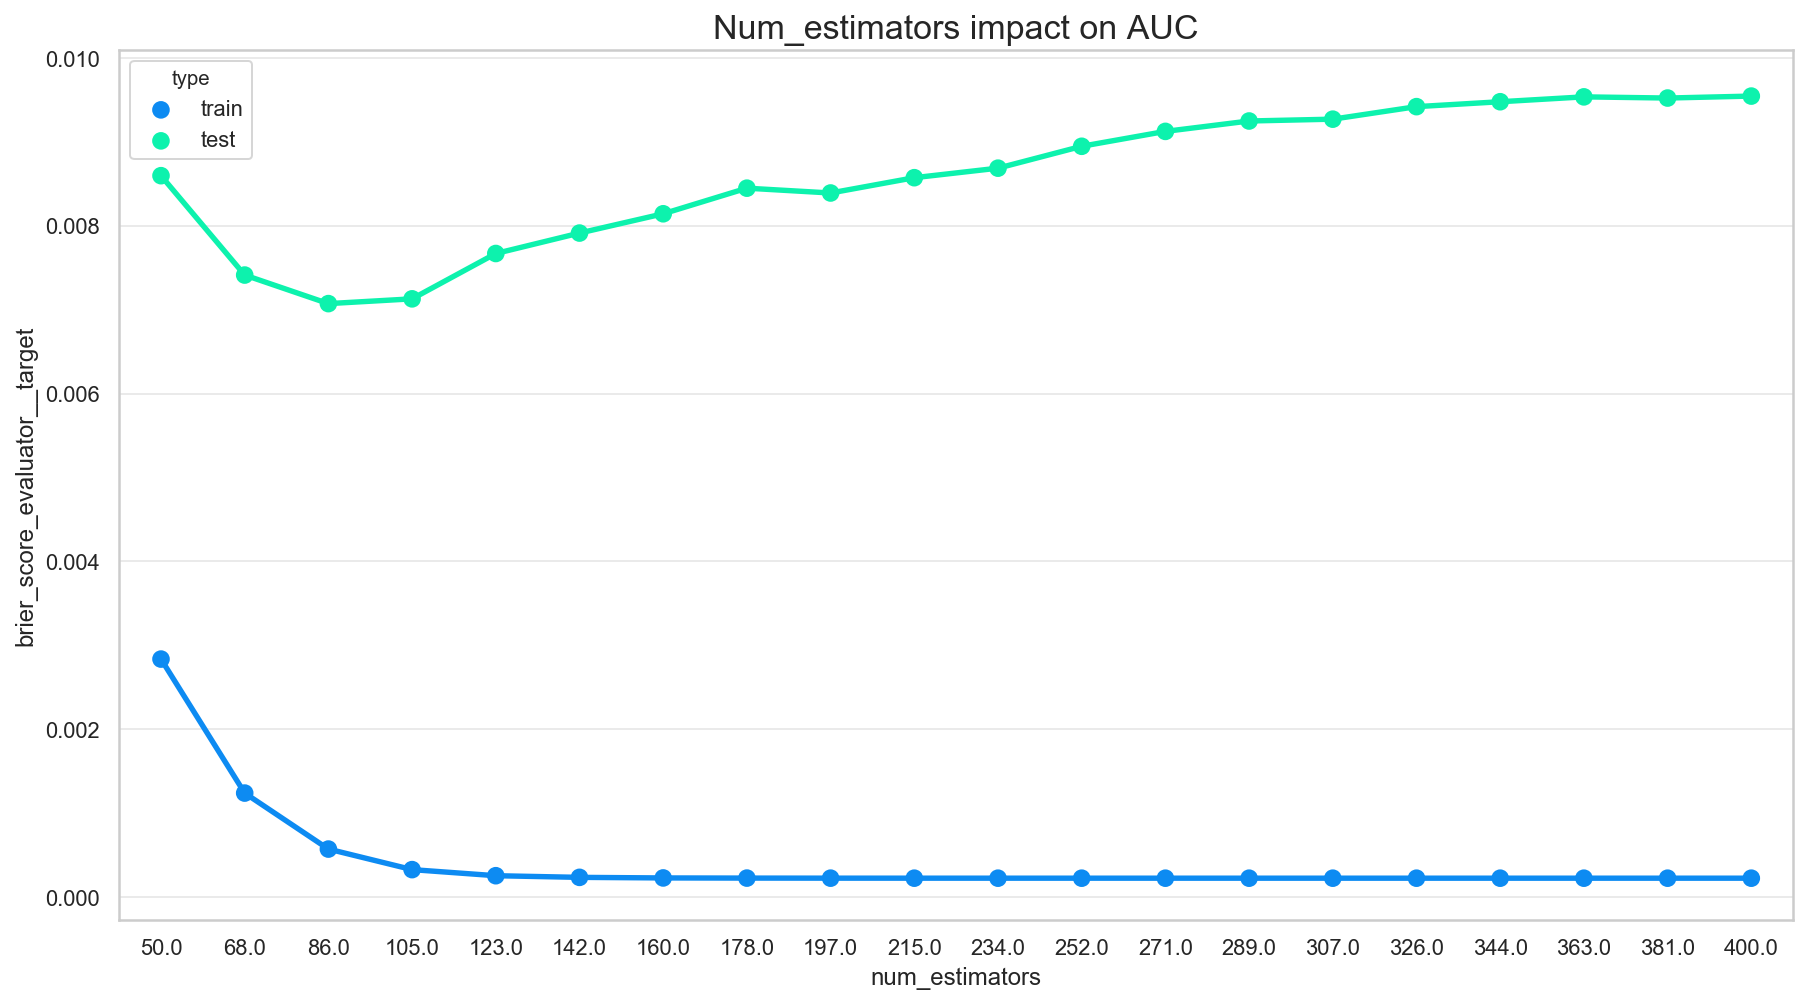

In [14]:
_, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(
    x="num_estimators",
    y="brier_score_evaluator__target",
    hue="type",
    data=did_3_results.query("(num_estimators == num_estimators) & (max_depth != max_depth) & (learning_rate != learning_rate)"),
    ax=ax
)
ax.set_title("Num_estimators impact on AUC", size=17)

### learning_rate

Text(0.5, 1.0, 'Learning rate impact on AUC')

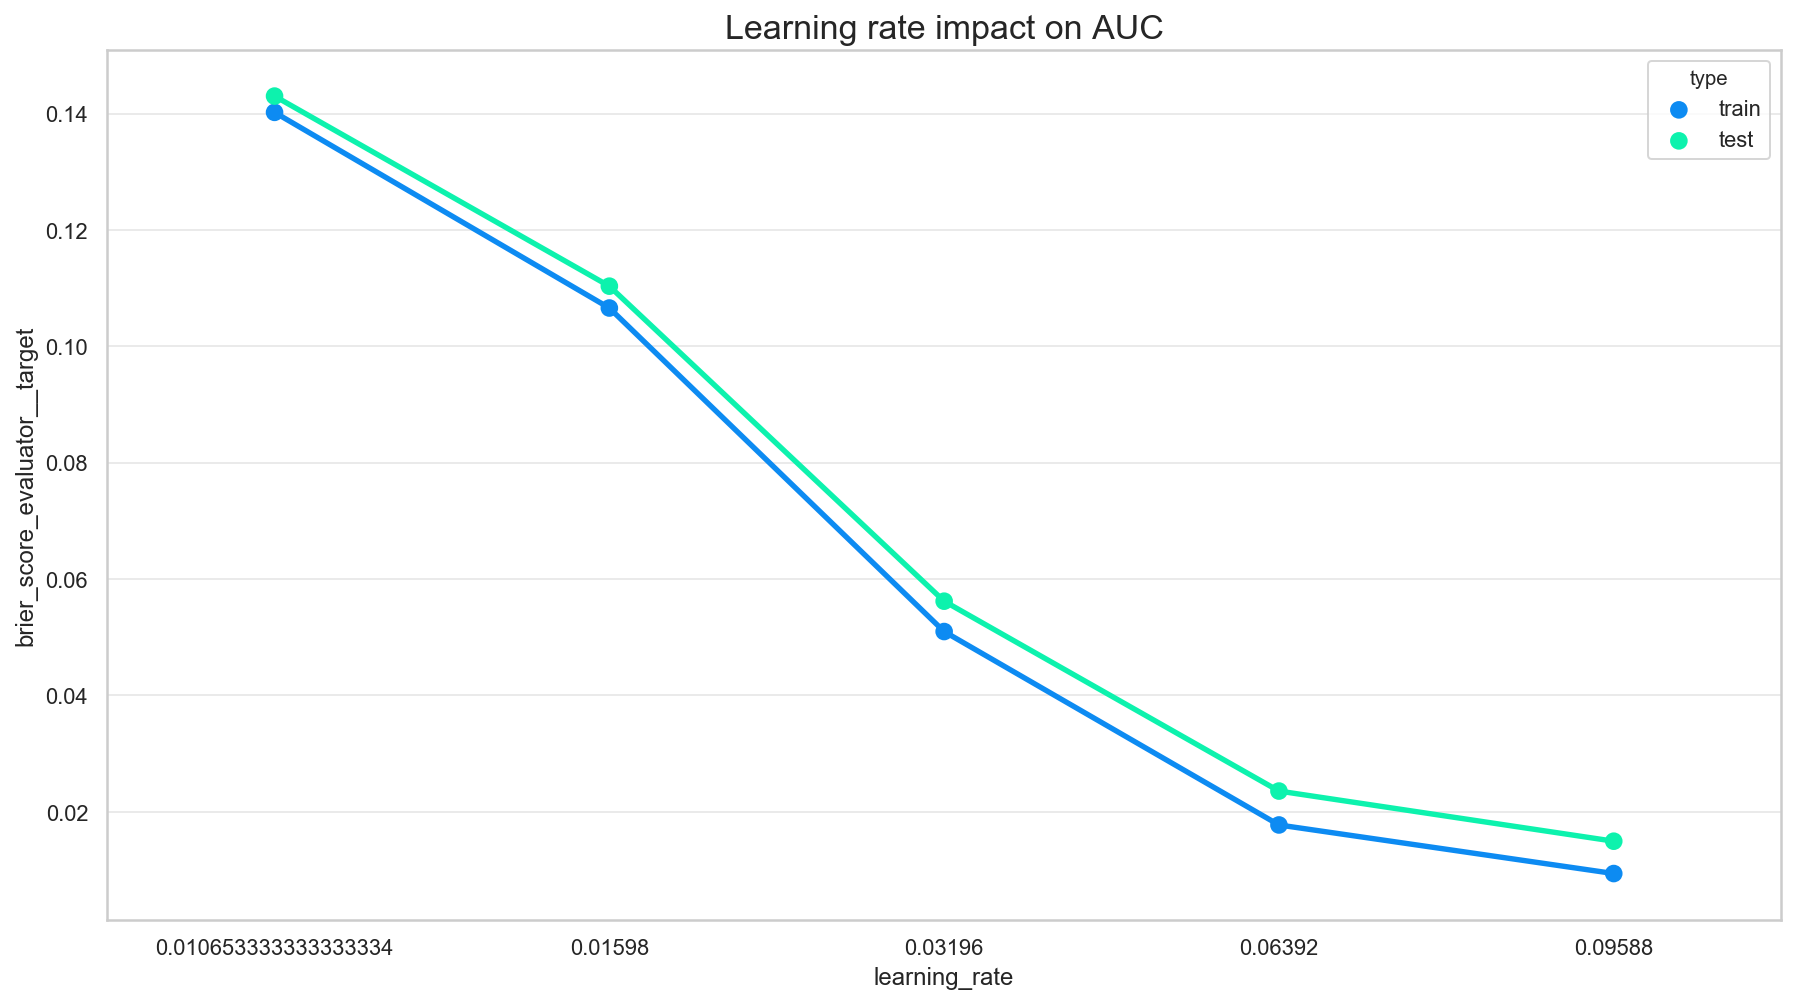

In [15]:
_, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(
    x="learning_rate",
    y="brier_score_evaluator__target",
    hue="type",
    data=did_3_results.query("(num_estimators != num_estimators) & (max_depth != max_depth) & (learning_rate == learning_rate)"),
    ax=ax
)
ax.set_title("Learning rate impact on AUC", size=17)

### max_depth

Text(0.5, 1.0, 'Max depth impact on AUC')

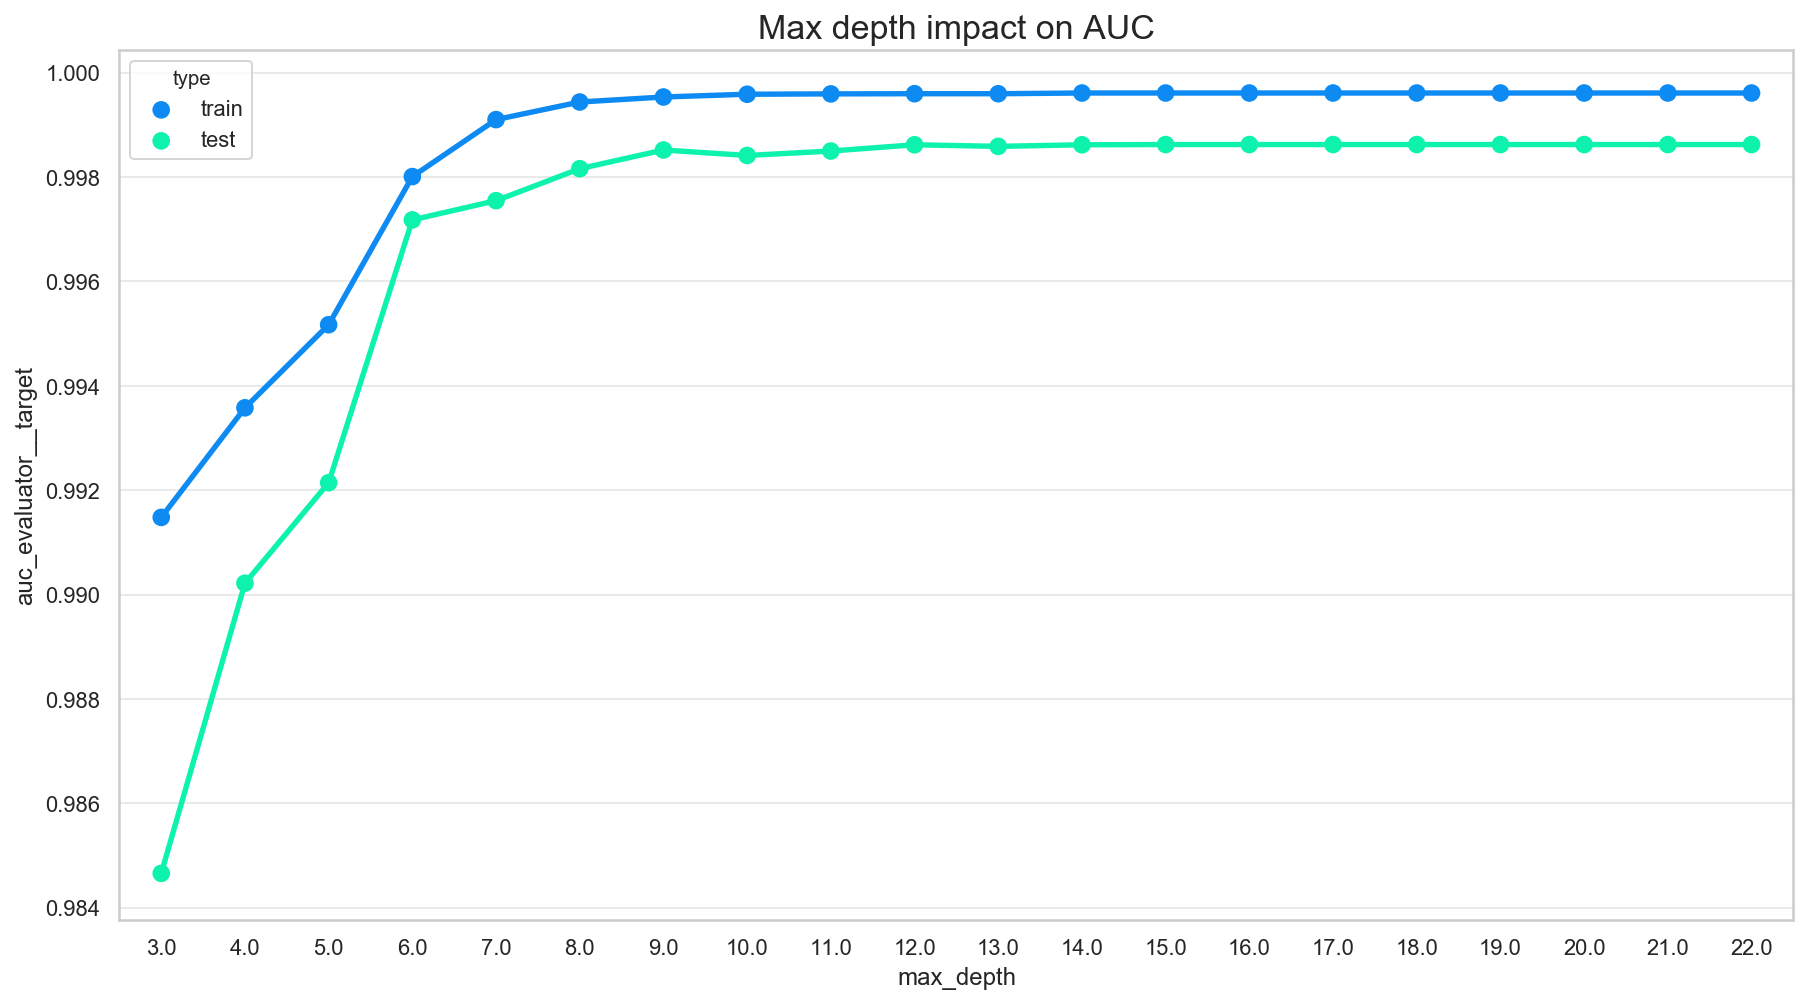

In [24]:
_, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(
    x="max_depth",
    y="auc_evaluator__target",
    hue="type",
    data=did_3_results.query("(num_estimators != num_estimators) & (max_depth == max_depth) & (learning_rate != learning_rate)"),
    ax=ax
)
ax.set_title("Max depth impact on AUC", size=17)

## Joint Impact

Text(0.5, 1.02, 'Learning rate and Num estimators')

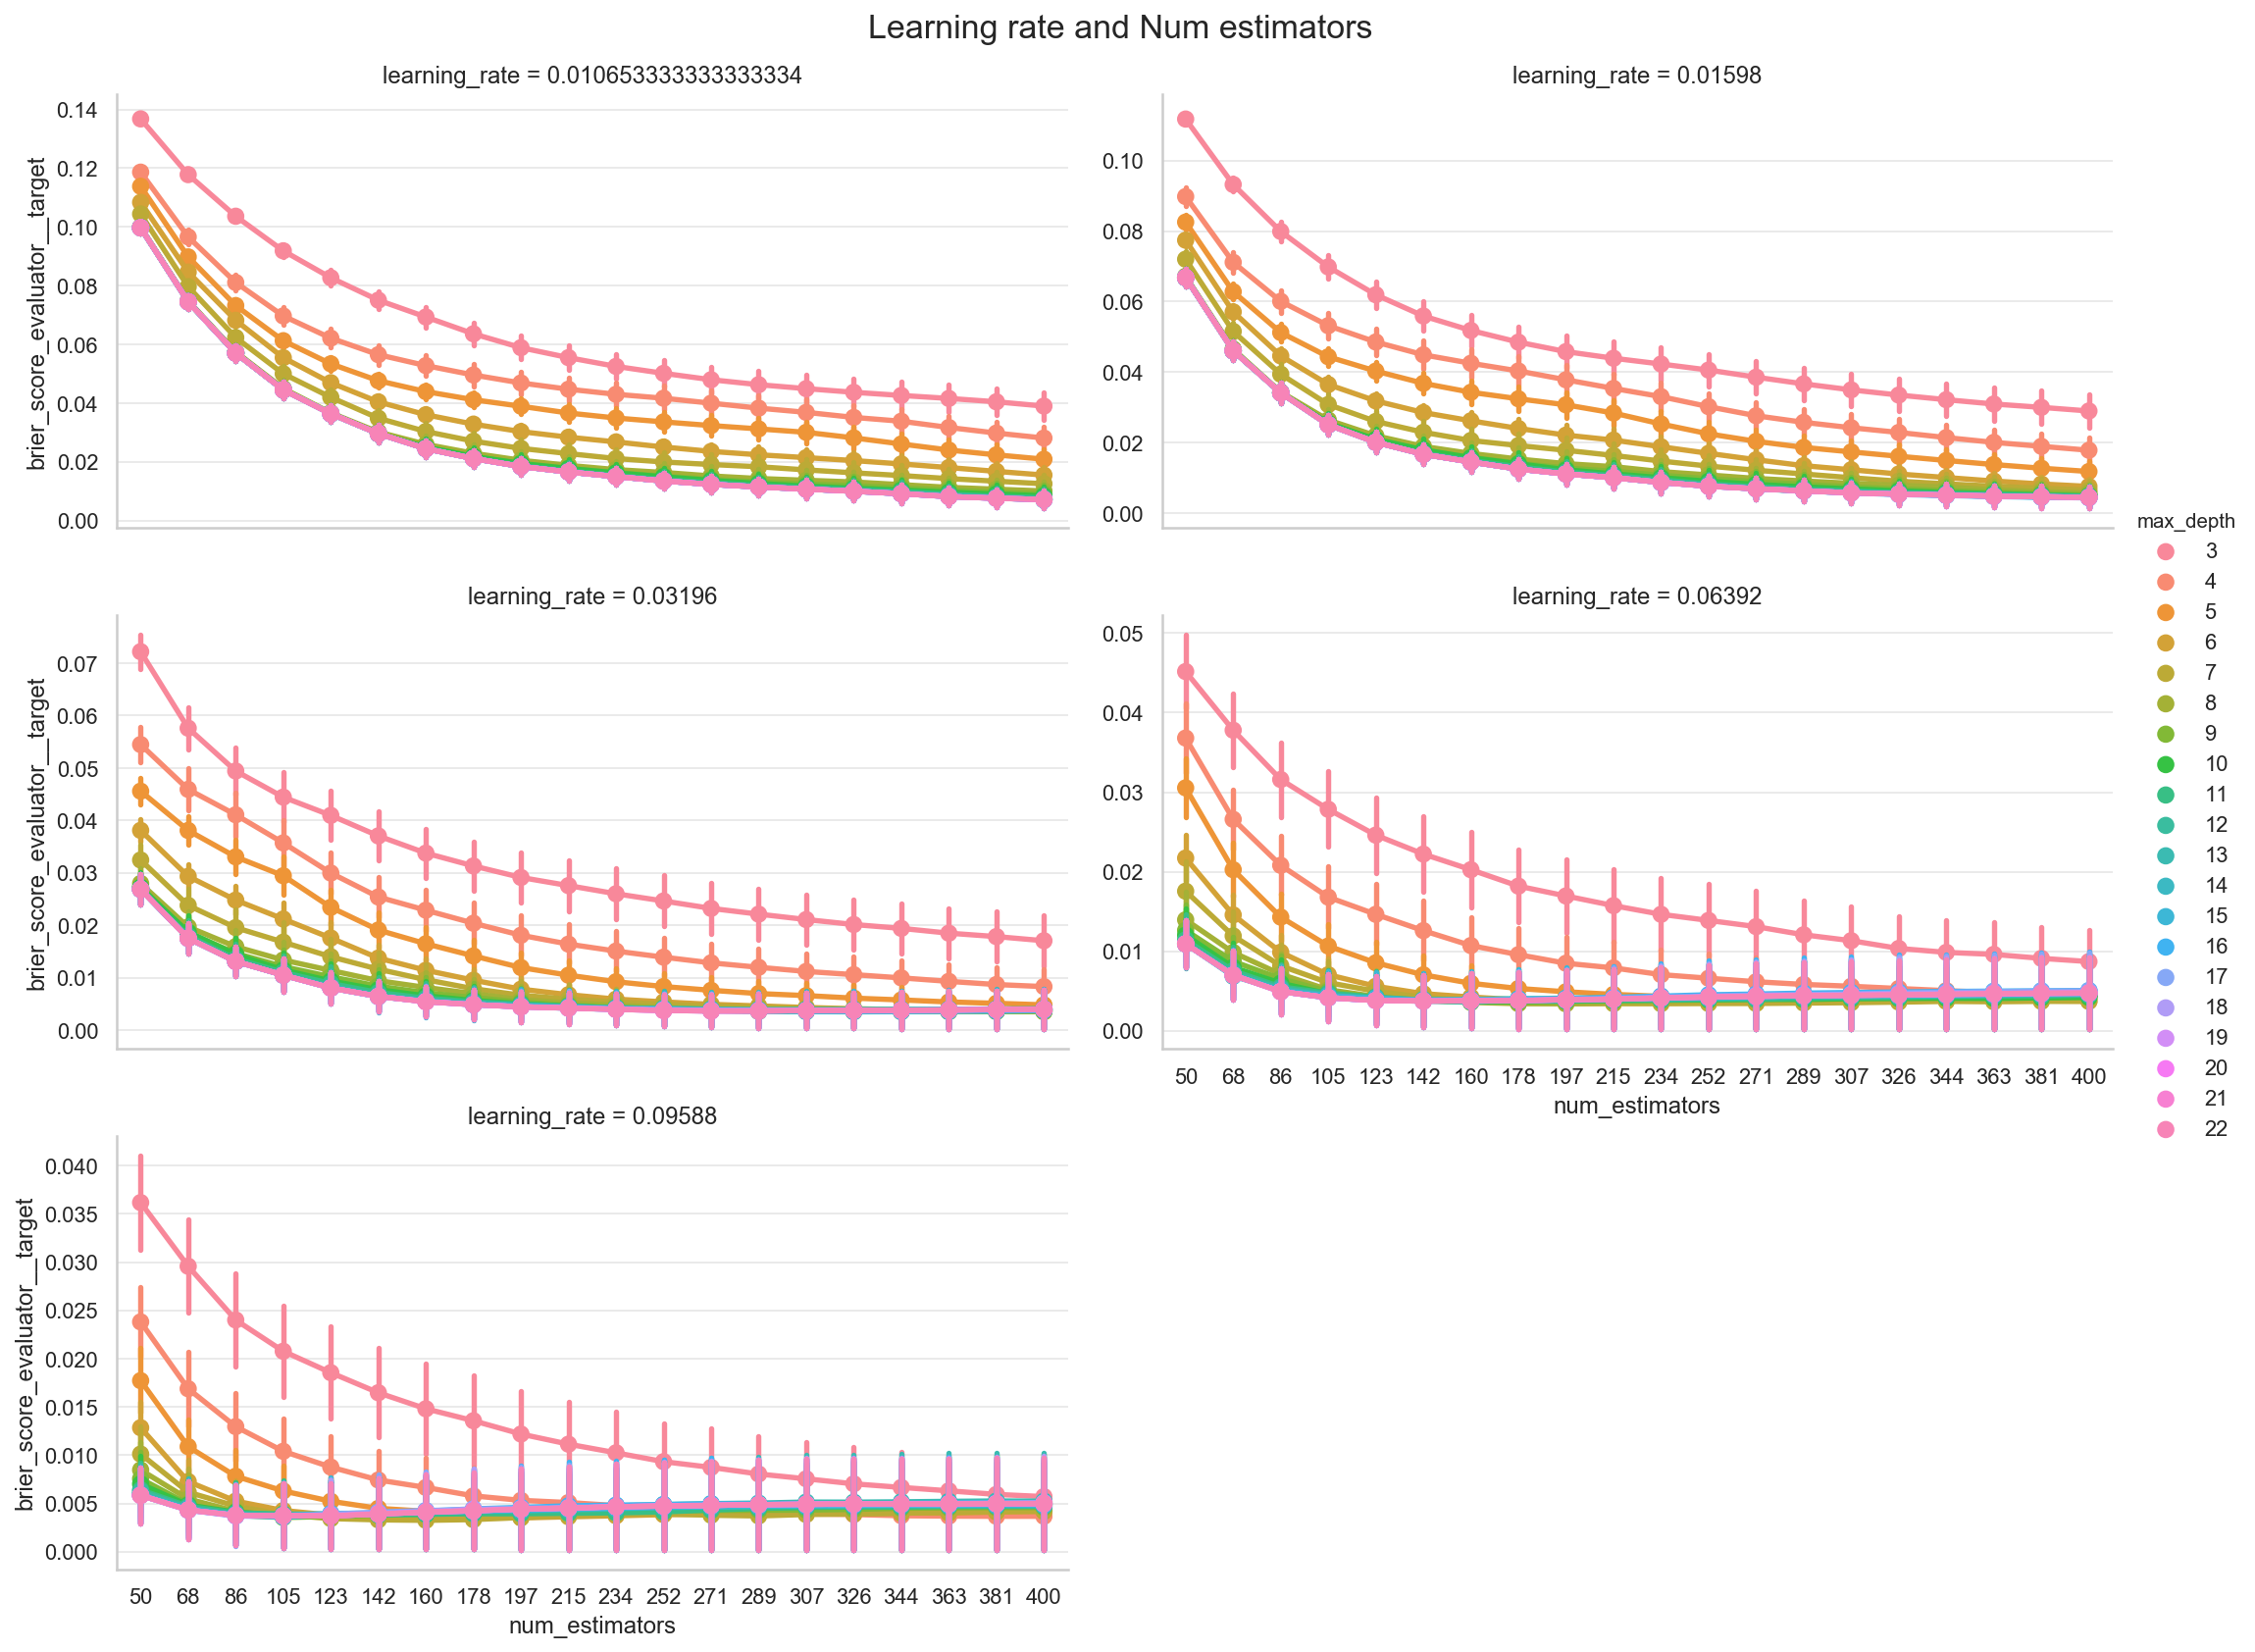

In [18]:
sns.catplot(x="num_estimators", y="auc_evaluator__target", col="learning_rate", hue="max_depth", kind="point",
            data=(did_3_results.query("(num_estimators == num_estimators) & (max_depth == max_depth) & (learning_rate == learning_rate)")
                  .assign(num_estimators=lambda df: df.num_estimators.astype("int"),
                          max_depth=lambda df: df.max_depth.astype("int"))),
            col_wrap=2, height=3.8, aspect=2, sharey=False)
plt.gcf().suptitle("Learning rate and Num estimators", size=17, y=1.02)

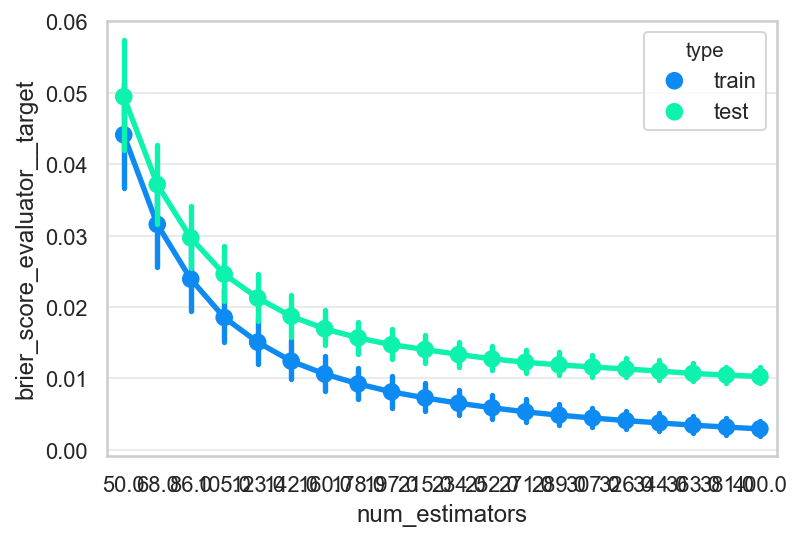

In [23]:
sns.pointplot(
    x="num_estimators",
    y="brier_score_evaluator__target",
    hue="type",
    data=did_3_results.query("(num_estimators == num_estimators) & (max_depth == max_depth) & (learning_rate == learning_rate)"))


In [15]:
# Create clusters of datapoints
# CHECK delta AUC MEAN

# All experiments: meta-statistics analysis

In [7]:
all_dids = get_all_available_experiments()
print(f"Number of available datasets: {len(all_dids)}")
experiment_statistics = build_experiment_stats(all_dids);

Number of available datasets: 63


/Users/juliano.garcia/miniconda3/envs/boosting/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


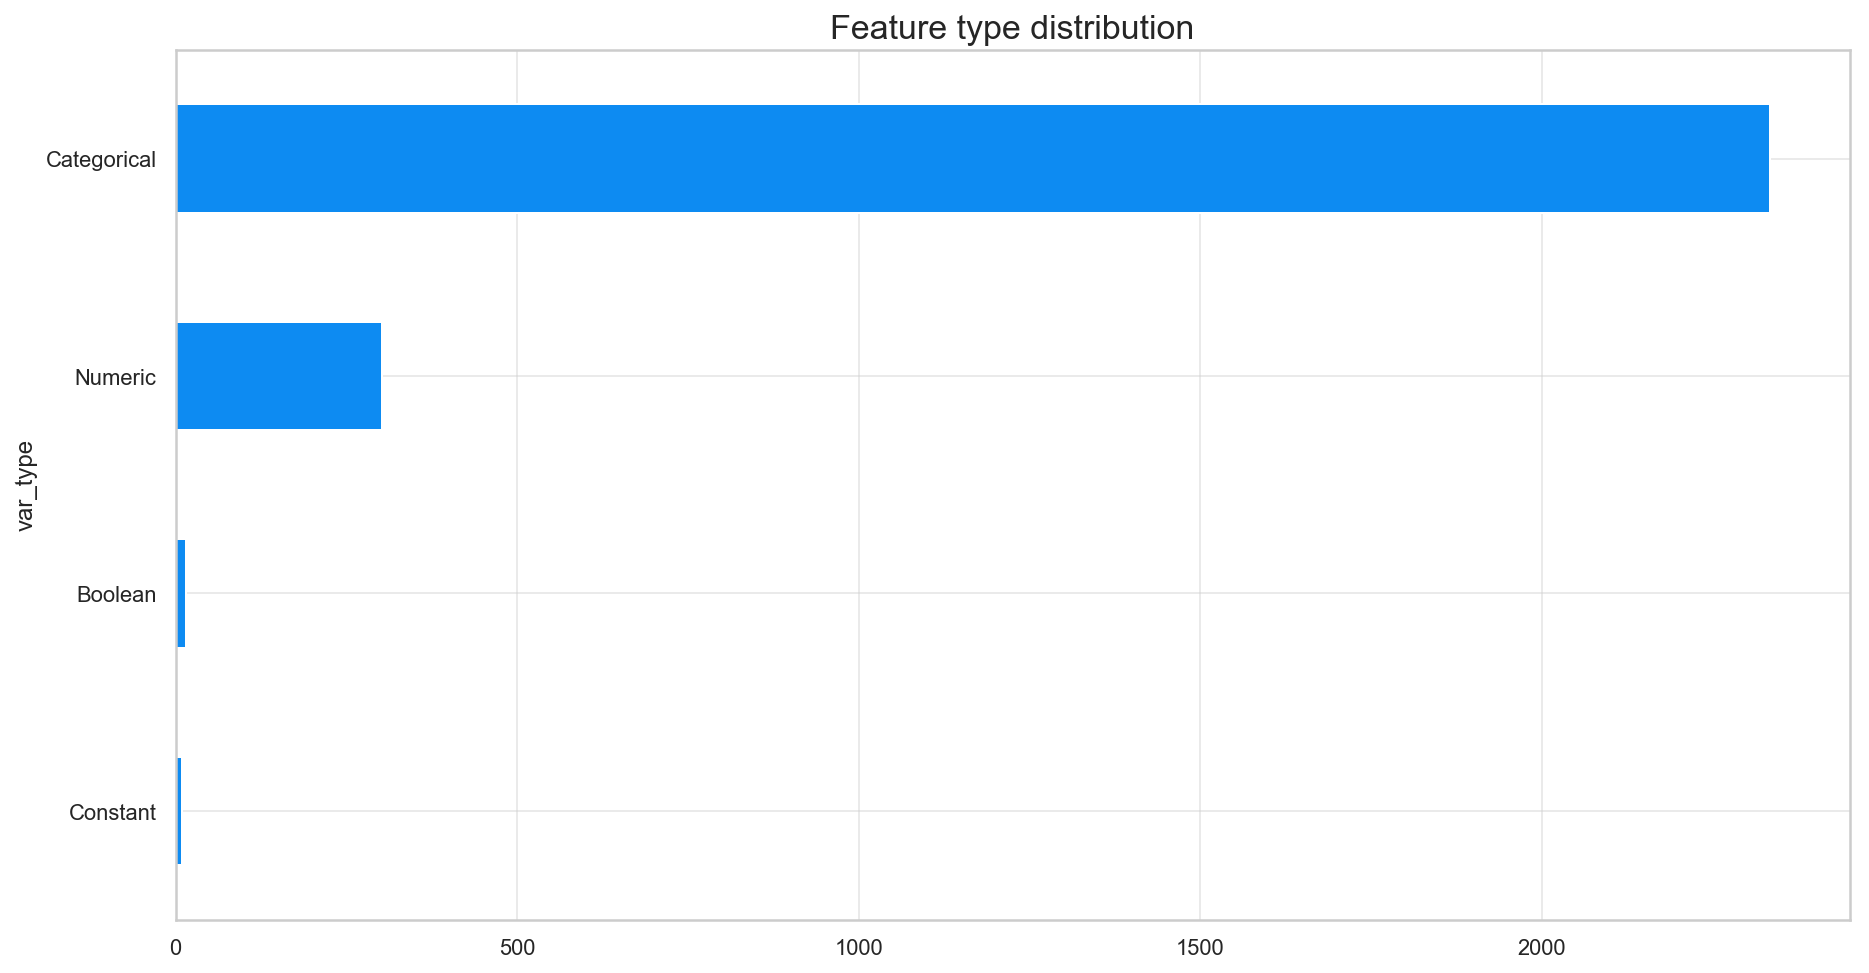

In [8]:
experiment_statistics.groupby("var_type").count().top.rename("count").sort_values().plot(kind="barh", ax=new_axis(title="Feature type distribution"))

## Cardinality 

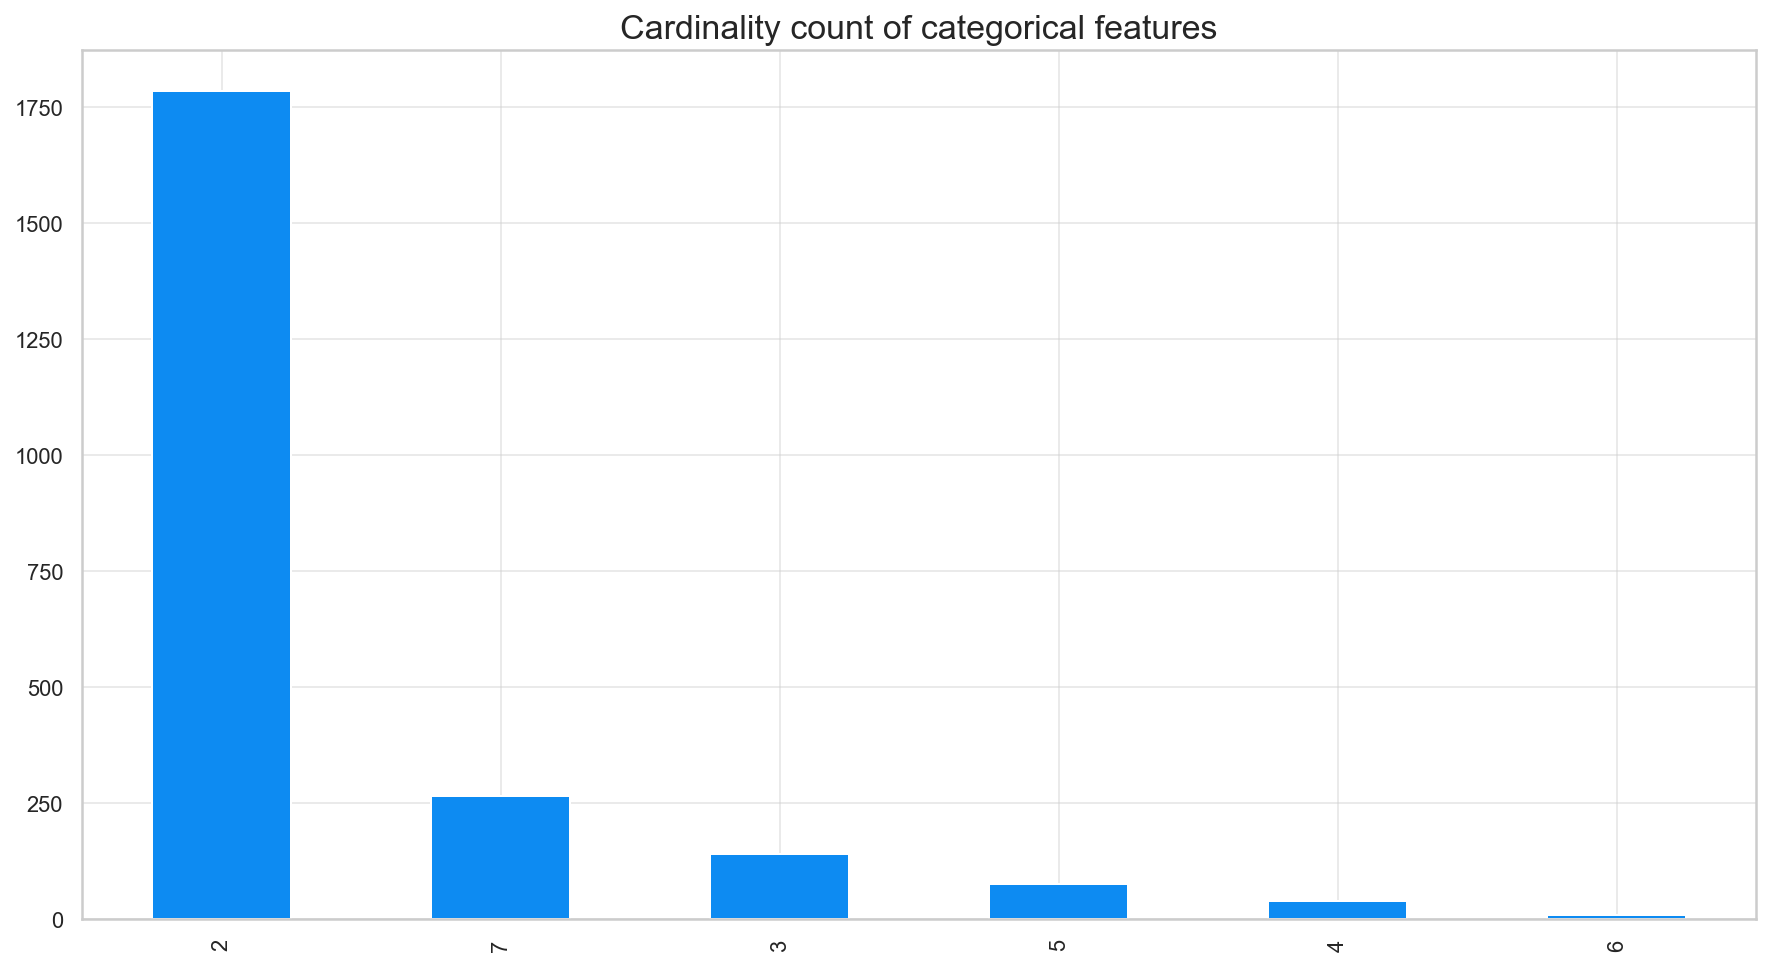

In [9]:
cardinality = experiment_statistics[["cardinality"]].query("cardinality != '--'").dropna().astype(int)
cardinality.assign(
    cardinality=lambda df: df.cardinality.clip(upper=np.percentile(df.cardinality, 95))
).cardinality.value_counts().plot(kind="bar", ax=new_axis(title="Cardinality count of categorical features"));

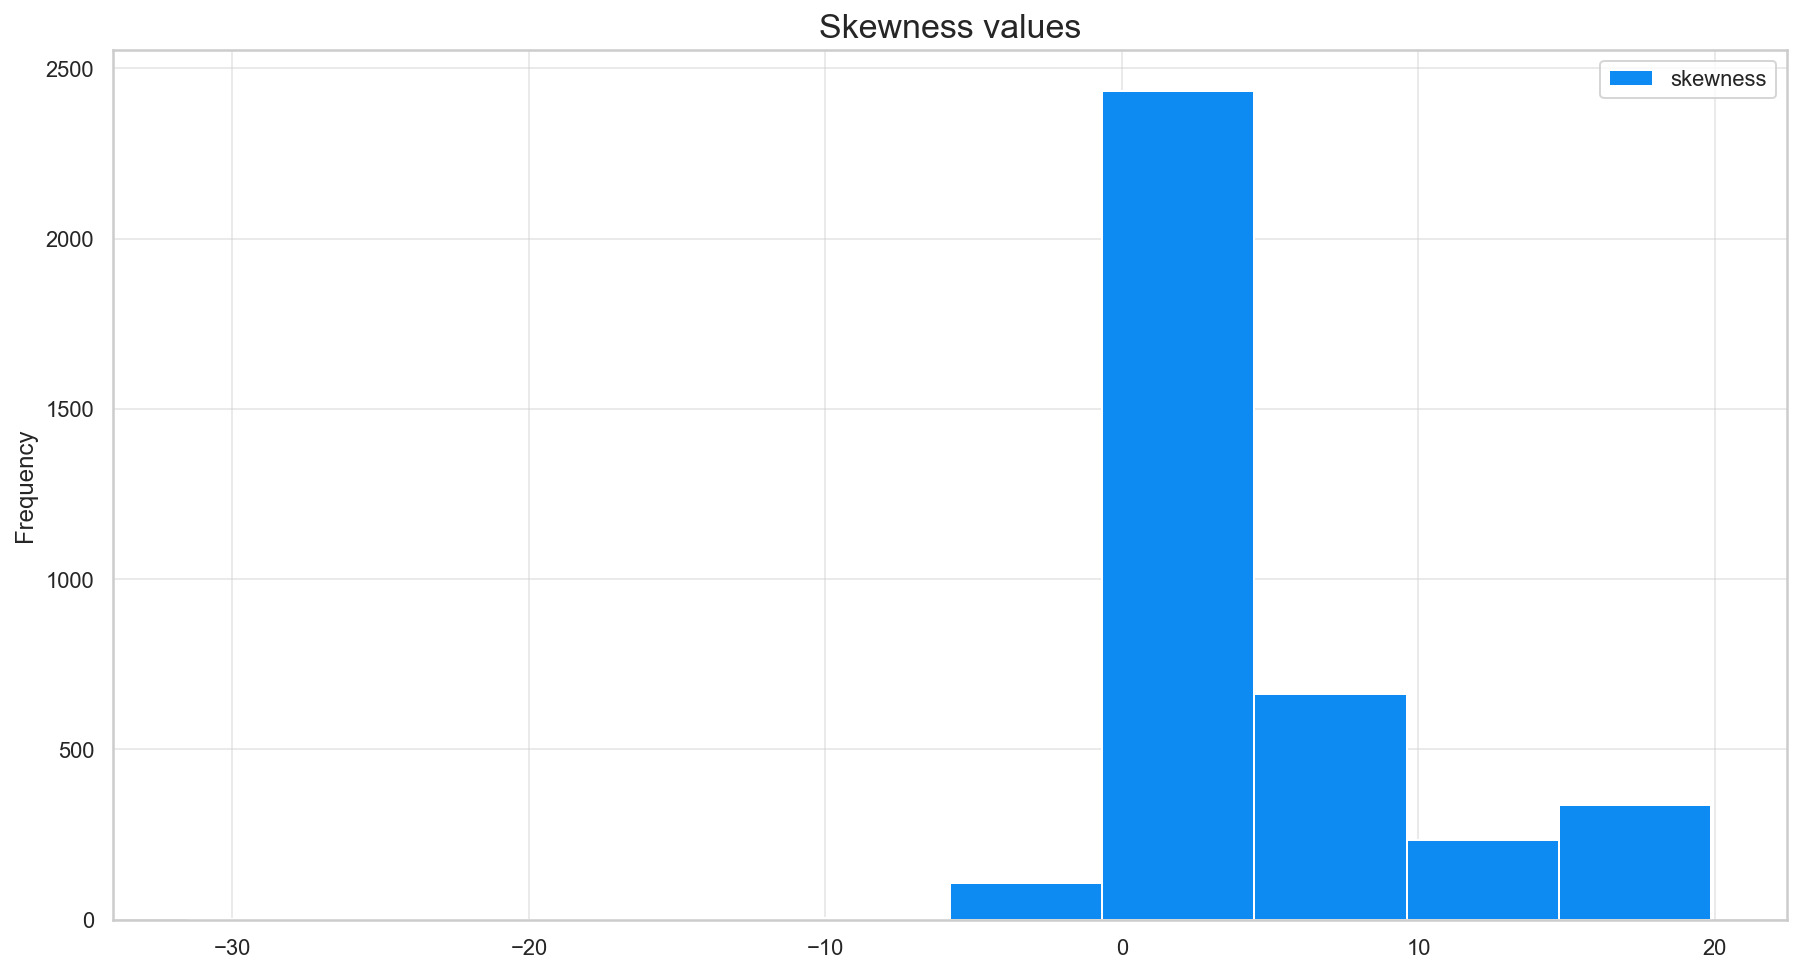

In [10]:
skewness = experiment_statistics[["skewness"]].query("skewness != '--'").dropna().astype(float)
skewness.assign(skewness=lambda df: df.skewness.clip(upper=np.percentile(df.skewness, 95))).plot.hist(
    ax=new_axis(title="Skewness values")
);

## Aggregated meta-statistics by dataset

OBS: *variance* is defined as: 1 - `(v / float(df.shape[0]))`, where v is the number of rows the most common value of a given feature appears. 0 is usually bad

In [8]:
def did_agg(did_df):
    d = {}
    did_skewness = did_df.query("skewness != '--'").skewness.dropna().astype(float)
    d["num_rows"] = did_df["count"].iloc[0]
    d["num_features"] = did_df.T.columns.shape[0]
    d["mean_skewness"] = 0.0 if did_skewness.empty else did_skewness.mean()
    d["mean_variance"] = did_df.query("variance != '--'").variance.mean()
    d["num_categorical"] = did_df["var_type"].isin(["Categorical"]).sum()
    d["sum_cardinality_over_categorical"] = did_df.query(
        "cardinality == cardinality & cardinality != '--'"
    ).cardinality.astype(int).sum() / (d["num_categorical"] + 1)
    # feature type count
    d["categorical_ratio"] = d["num_categorical"] / d["num_features"]    
    d["numeric_ratio"] = did_df["var_type"].isin(["Numeric"]).sum() / d["num_features"]    
    d["boolean_ratio"] = did_df["var_type"].isin(["Boolean"]).sum() / d["num_features"]    
    d["constant_ratio"] = did_df["var_type"].isin(["Constant"]).sum() / d["num_features"]    

    return pd.Series(
        d,
        index=[
            "num_rows",
            "num_features",
            "mean_variance",
            "mean_skewness",
            "num_categorical",
            "sum_cardinality_over_categorical",
            "categorical_ratio",
            "numeric_ratio",
            "boolean_ratio",
            "constant_ratio",
        ],
    )

Example of capper - by the 95th percentile

In [9]:
np.percentile(pd.Series(np.arange(100)), 95)

94.05

/Users/juliano.garcia/miniconda3/envs/boosting/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


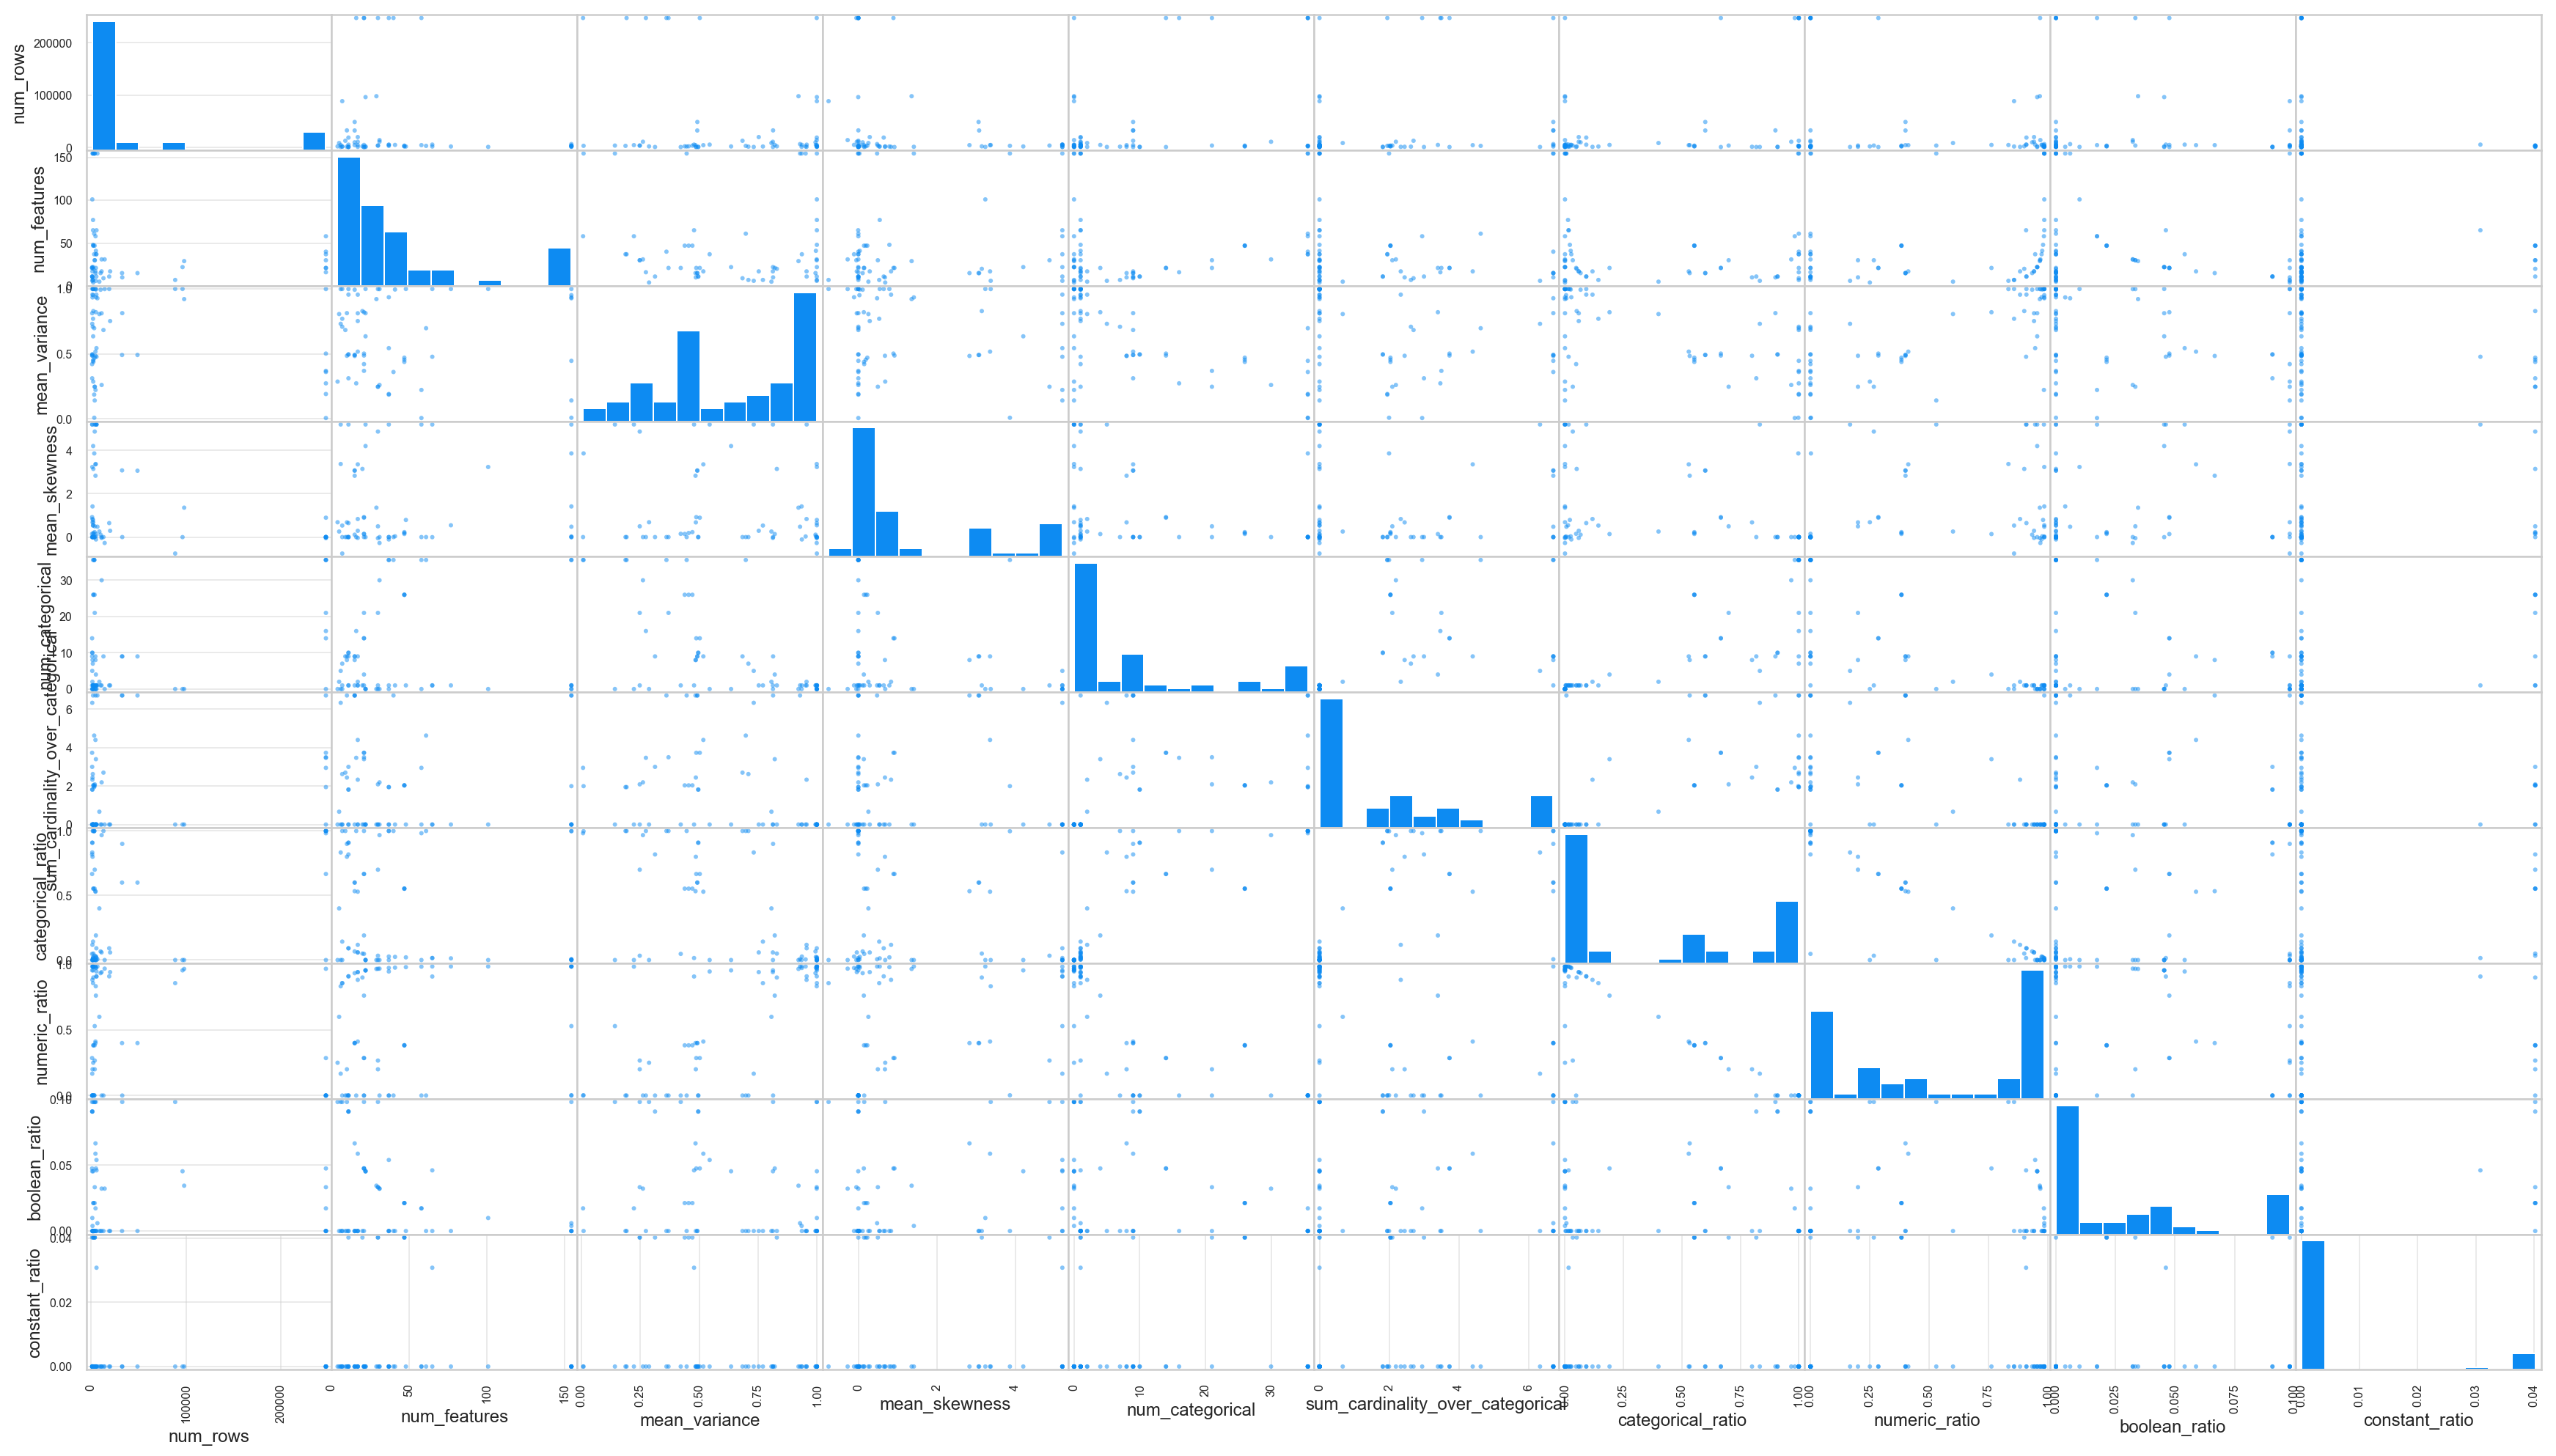

In [10]:
aggregated_stats = experiment_statistics.groupby("did").apply(did_agg)
capped_agg_stats = aggregated_stats.assign(
    **{f"{col}": lambda df, i=col: df[i].clip(upper=np.percentile(df[i], 90)) for col in aggregated_stats.columns}
)

pd.plotting.scatter_matrix(
    capped_agg_stats, ax=new_axis(title="Scatter matrix for aggregated statistics", figsize=(30, 17))
);

In [11]:
aggregated_stats.shape
aggregated_stats.head()

(63, 10)

num_rows  num_features  mean_variance  mean_skewness  num_categorical  \
did                                                                           
3       3196.0          37.0       0.187118       0.000000             37.0   
31      1000.0          21.0       0.487300       0.920379             14.0   
44      4601.0          58.0       0.222751      11.186639              0.0   
72   1000000.0          37.0       0.191597       0.000000             37.0   
124  1000000.0          16.0       0.273640       0.000000             16.0   

     sum_cardinality_over_categorical  categorical_ratio  numeric_ratio  \
did                                                                       
3                            1.947368           1.000000       0.000000   
31                           3.733333           0.666667       0.285714   
44                           0.000000           0.000000       0.982759   
72                           1.947368           1.000000       0.000000   
124                          3.470588           1.000000       0.000000   

     boolean_ratio  constant_ratio  
did                                 
3         0.000000             0.0  
31        0.047619             0.0  
44        0.017241             0.0  
72        0.000000             0.0  
124       0.000000             0.0

In [12]:
from sklearn.preprocessing import StandardScaler
scaled_agg_stats = StandardScaler().fit_transform(capped_agg_stats)
scaled_agg_stats.shape

(63, 10)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=42)
tsne_results = tsne.fit_transform(scaled_agg_stats)

[t-SNE] Computing 62 nearest neighbors...
[t-SNE] Indexed 63 samples in 0.000s...
[t-SNE] Computed neighbors for 63 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 63 / 63
[t-SNE] Mean sigma: 2.461061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.489487
[t-SNE] KL divergence after 1000 iterations: 0.278648


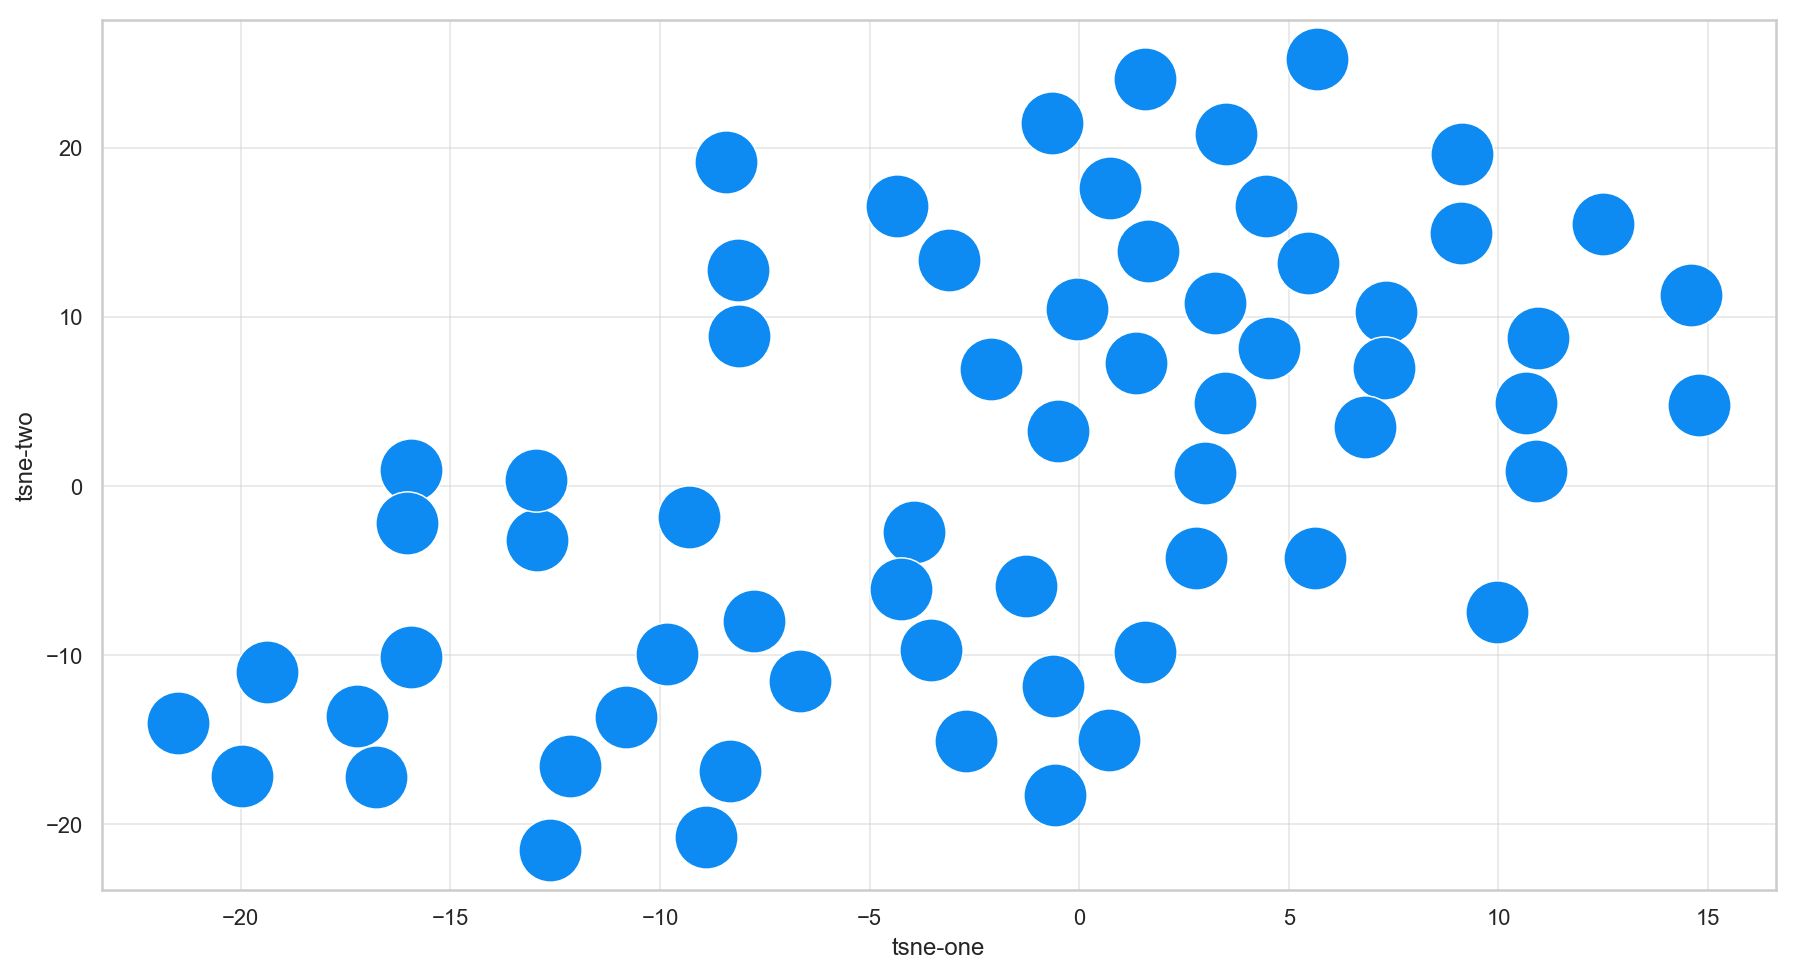

In [14]:
np.random.seed(42)
df_subset = pd.DataFrame()
df_subset["tsne-one"] = tsne_results[:, 0]
df_subset["tsne-two"] = tsne_results[:, 1]
sns.scatterplot(x="tsne-one", y="tsne-two", data=df_subset, ax=new_axis(), s=1000);

## Trying a simple cluster approach

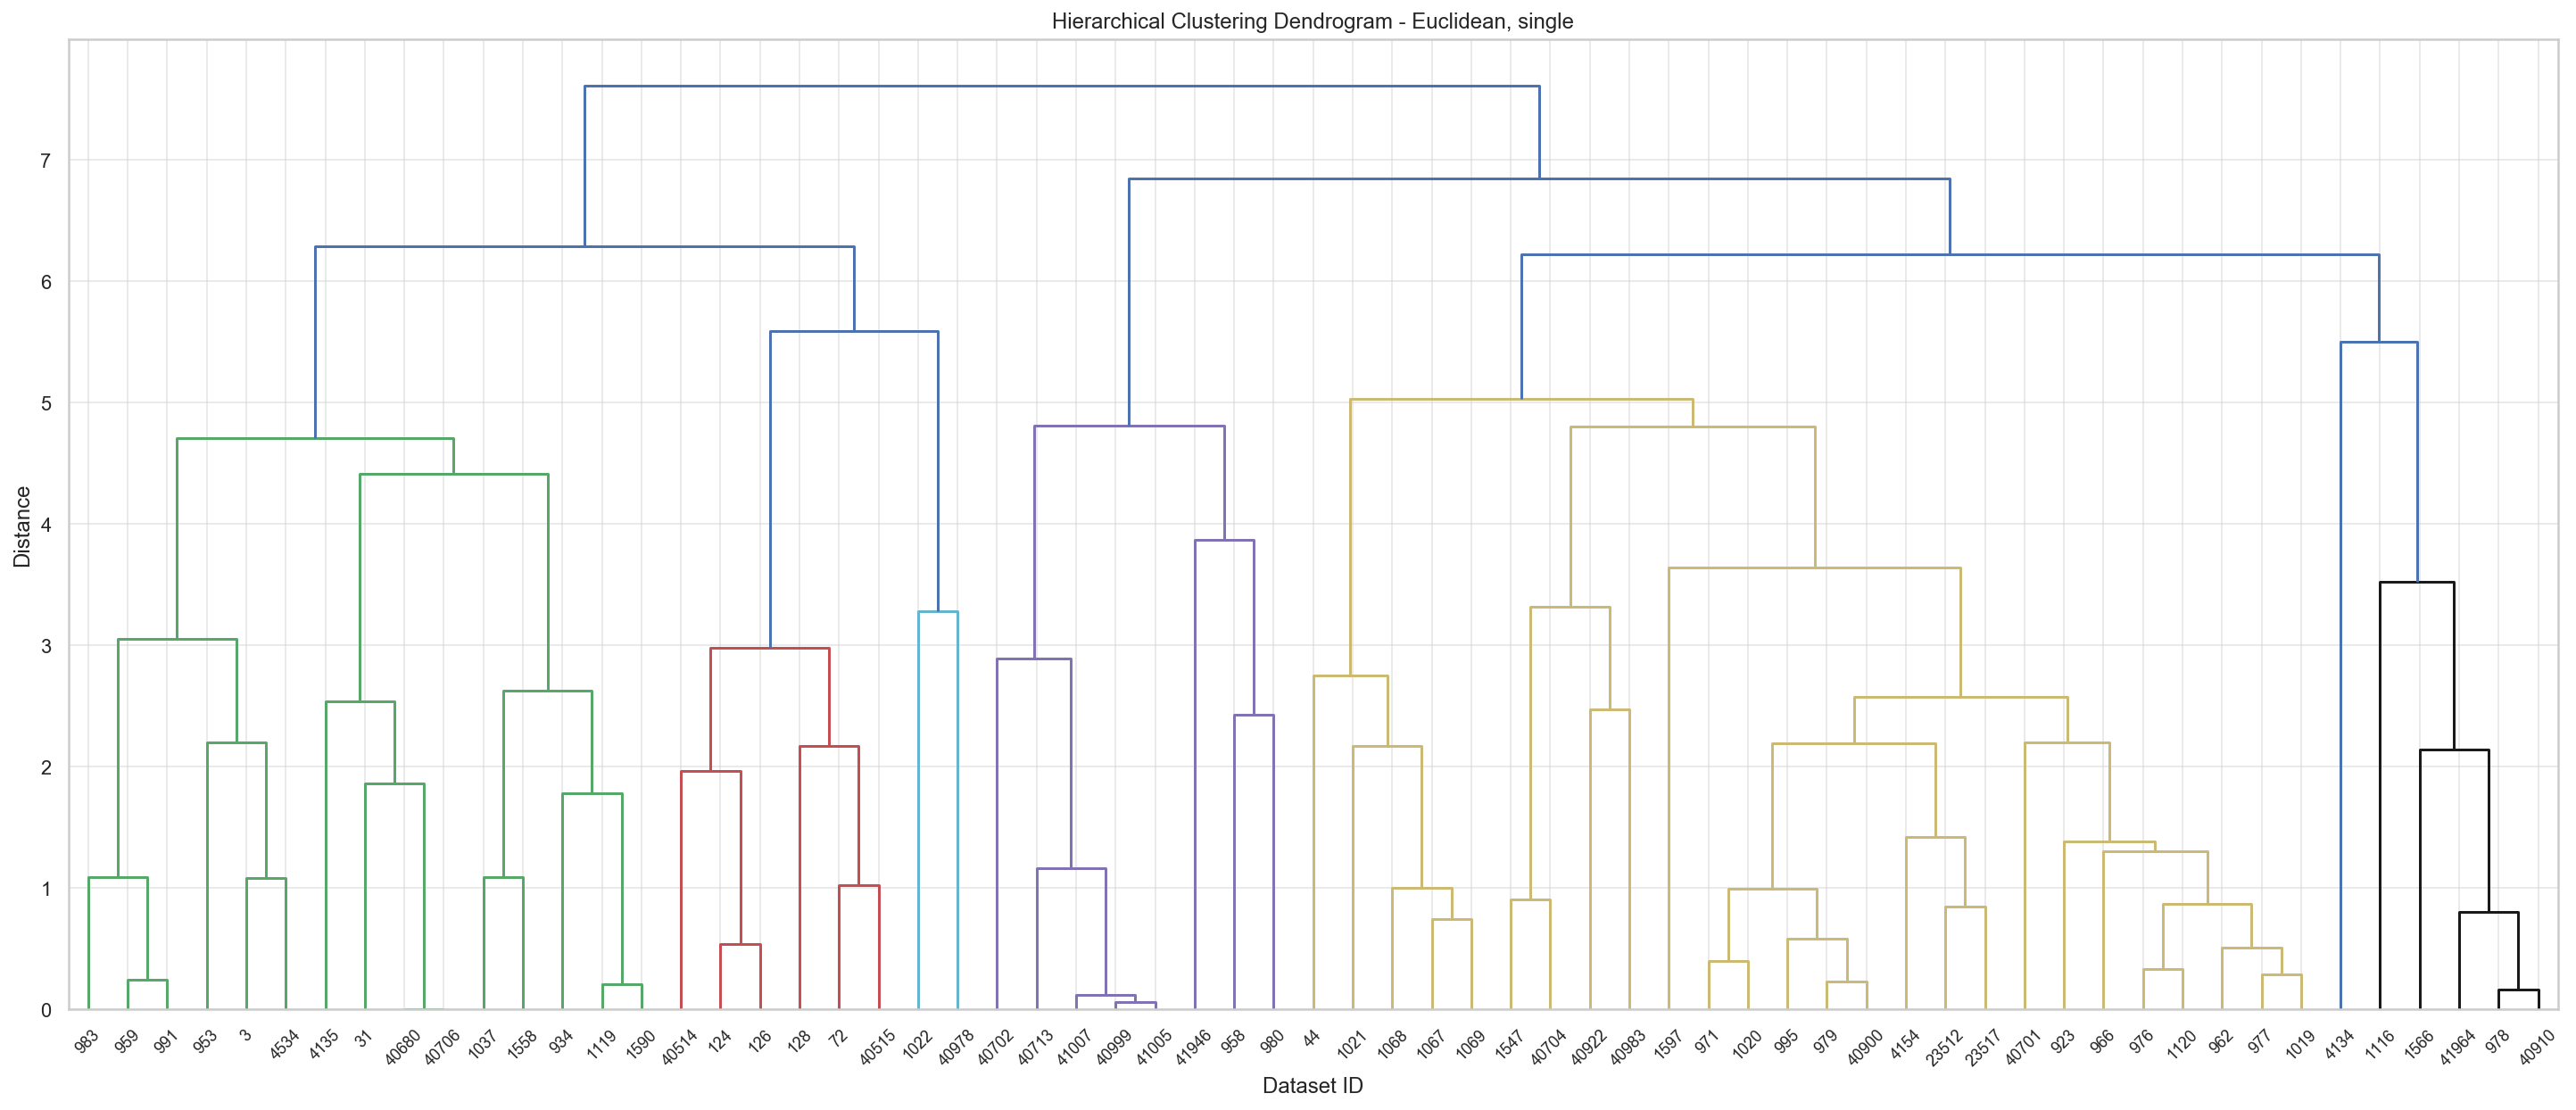

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
avg_linkage = linkage(scaled_agg_stats, method='complete', metric='euclidean', optimal_ordering=False)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - Euclidean, single')
plt.xlabel('Dataset ID')
plt.ylabel('Distance')
dendrogram(avg_linkage, labels=aggregated_stats.index.values, leaf_rotation=45,leaf_font_size=9.0);

In [16]:
# 6 clusters seem like a good number, so I'll set the threshold correctly
calculated_clusters = fcluster(avg_linkage, t=5.55, criterion="distance")

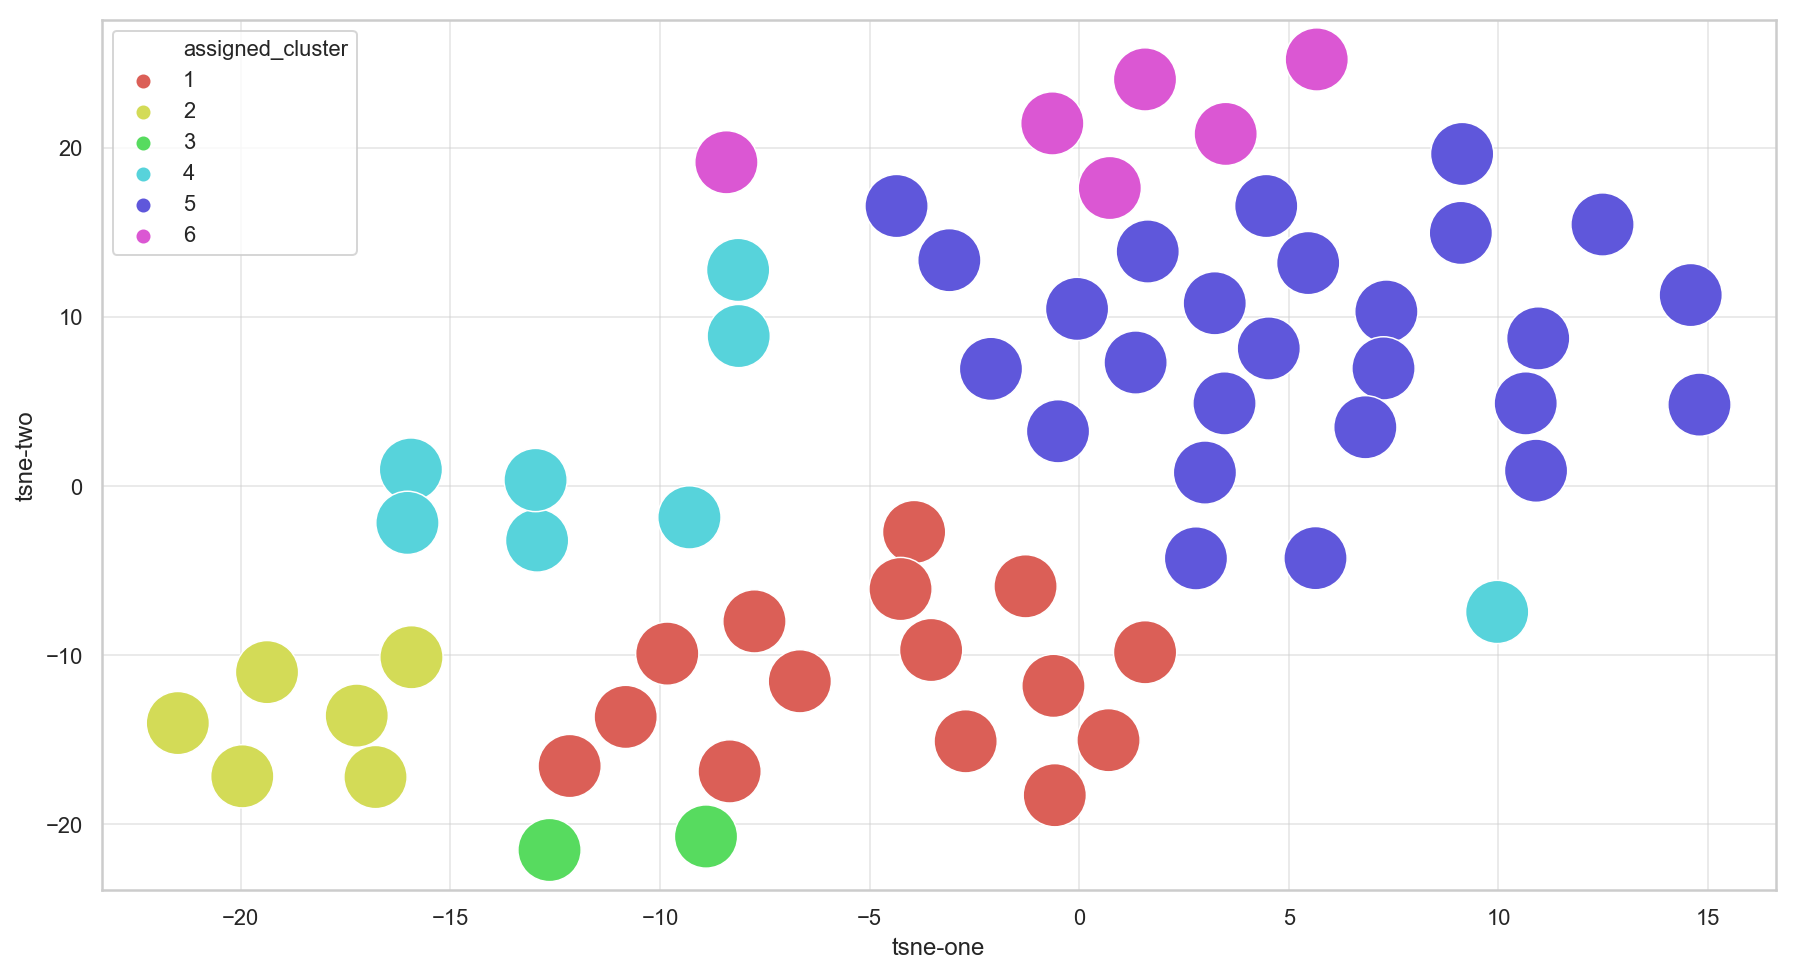

In [17]:
df_subset["assigned_cluster"] = calculated_clusters
sns.scatterplot(
    x="tsne-one",
    y="tsne-two",
    hue="assigned_cluster",
    data=df_subset,
    palette=sns.color_palette("hls", len(df_subset.assigned_cluster.unique())),
    ax=new_axis(),
    s=1000
)

In [18]:
nclusters = len(df_subset.assigned_cluster.unique())
aggregated_stats["cluster"] = calculated_clusters
capped_agg_stats["cluster"] = calculated_clusters

Getting a sense of each cluster

In [19]:
import joypy
from matplotlib.colors import ListedColormap


def plot_cluster_joyplot(aggregated_df, column):
    cluster_cmap = ListedColormap(sns.color_palette("hls", nclusters).as_hex())
    df = aggregated_df.assign(**{f"{column}": lambda df: df[column] + np.random.random() * 1e-10})
    # We don't want to plot a distribution when there's only one distinct value
    to_remove = (
        aggregated_df.groupby("cluster")[column]
        .apply(lambda x: len(x.unique()))
        .reset_index()
        .query(f"{column} <= 1")
        .cluster.values
    )
    fig, axes = joypy.joyplot(
        df.query("cluster not in @to_remove"),
        by="cluster",
        column=column,
        figsize=(10, 10),
        colormap=cluster_cmap,
        ylim="own",
        overlap=0,
    )
    fig.suptitle(f"Distribution of {column} by cluster", size=18, y=1.05)

In [20]:
aggregated_stats.cluster.values

array([1, 1, 5, 2, 2, 2, 2, 5, 1, 1, 4, 1, 5, 5, 5, 5, 5, 6, 5, 4, 1, 1,
       5, 5, 5, 5, 3, 1, 5, 5, 5, 6, 1, 5, 5, 1, 6, 1, 5, 6, 1, 5, 1, 5,
       5, 2, 2, 1, 5, 4, 5, 1, 4, 5, 6, 5, 3, 5, 4, 4, 4, 4, 6],
      dtype=int32)

When checking the distribution of the engineered variables the clusters seem to separate datasets in a good manner

/Users/juliano.garcia/miniconda3/envs/boosting/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


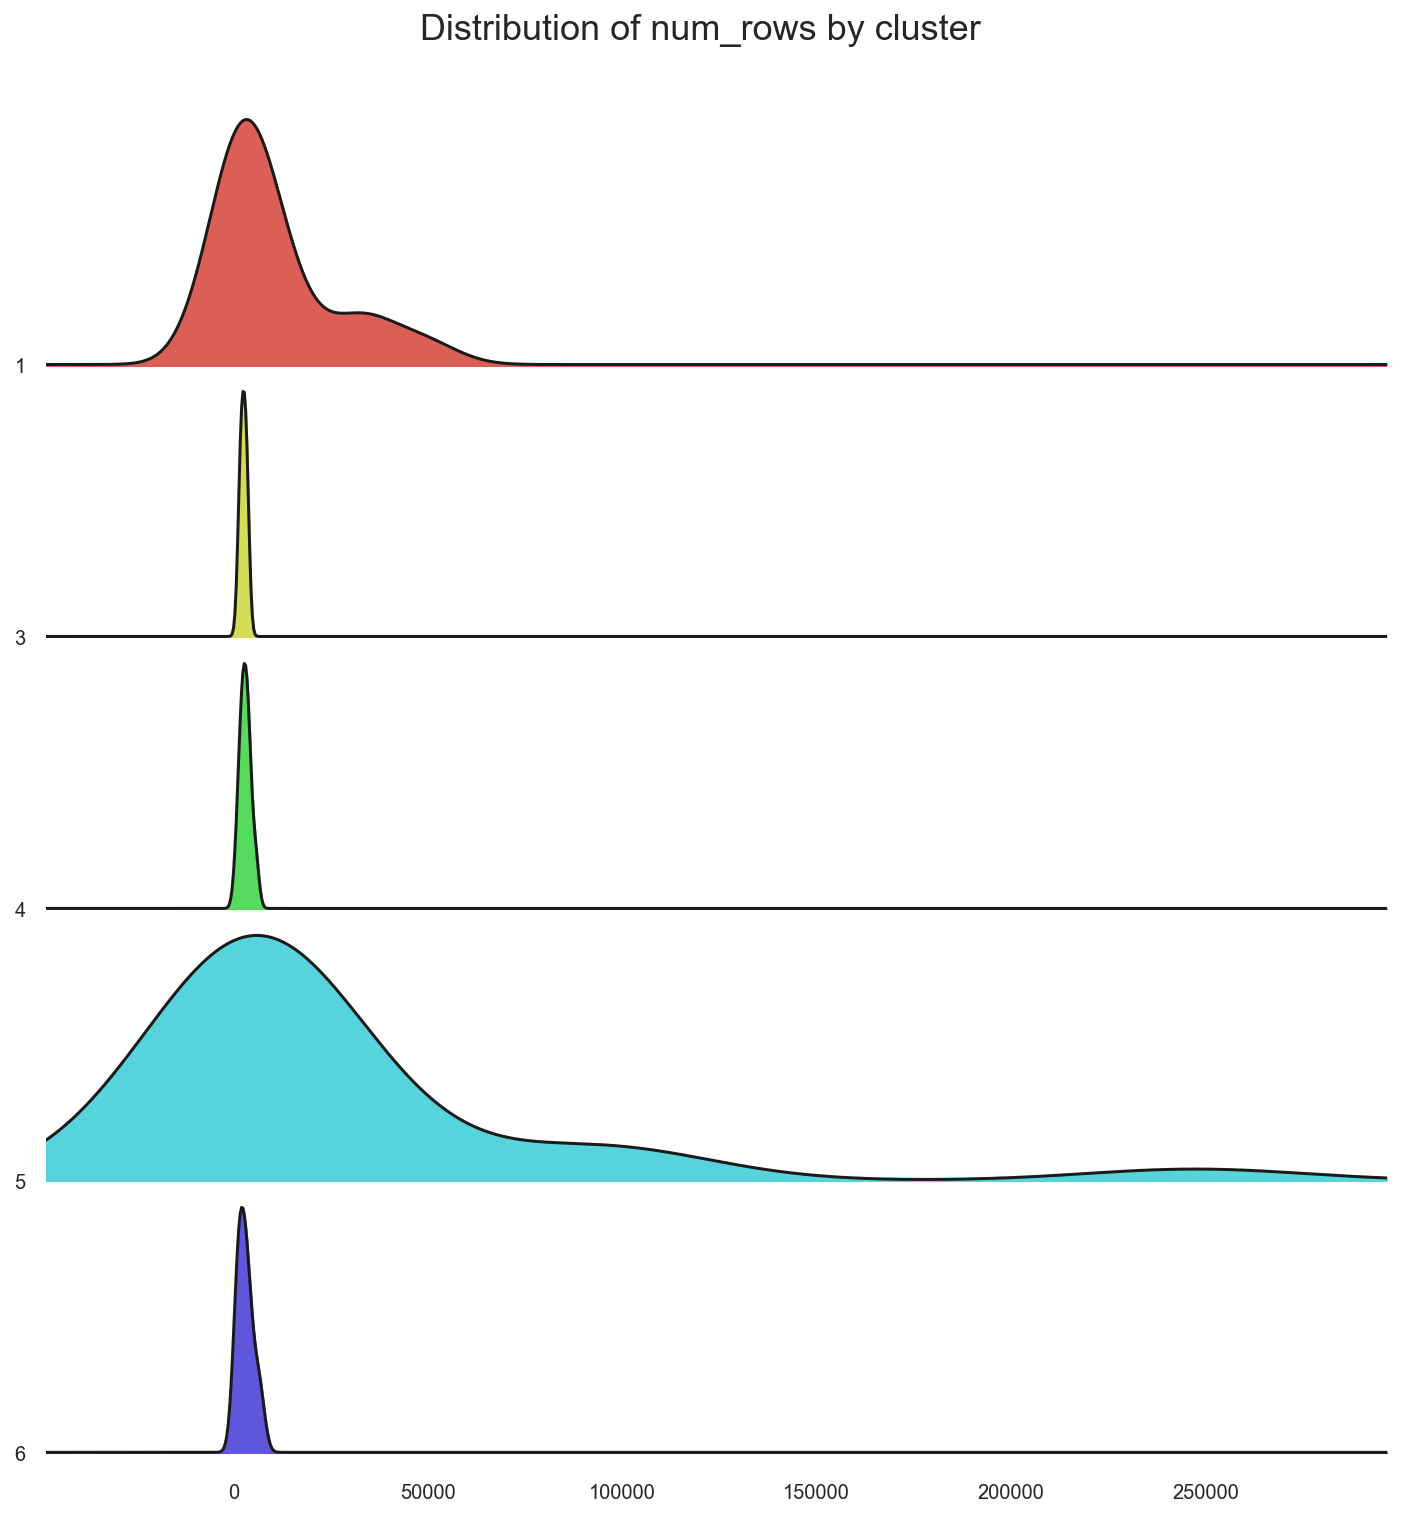

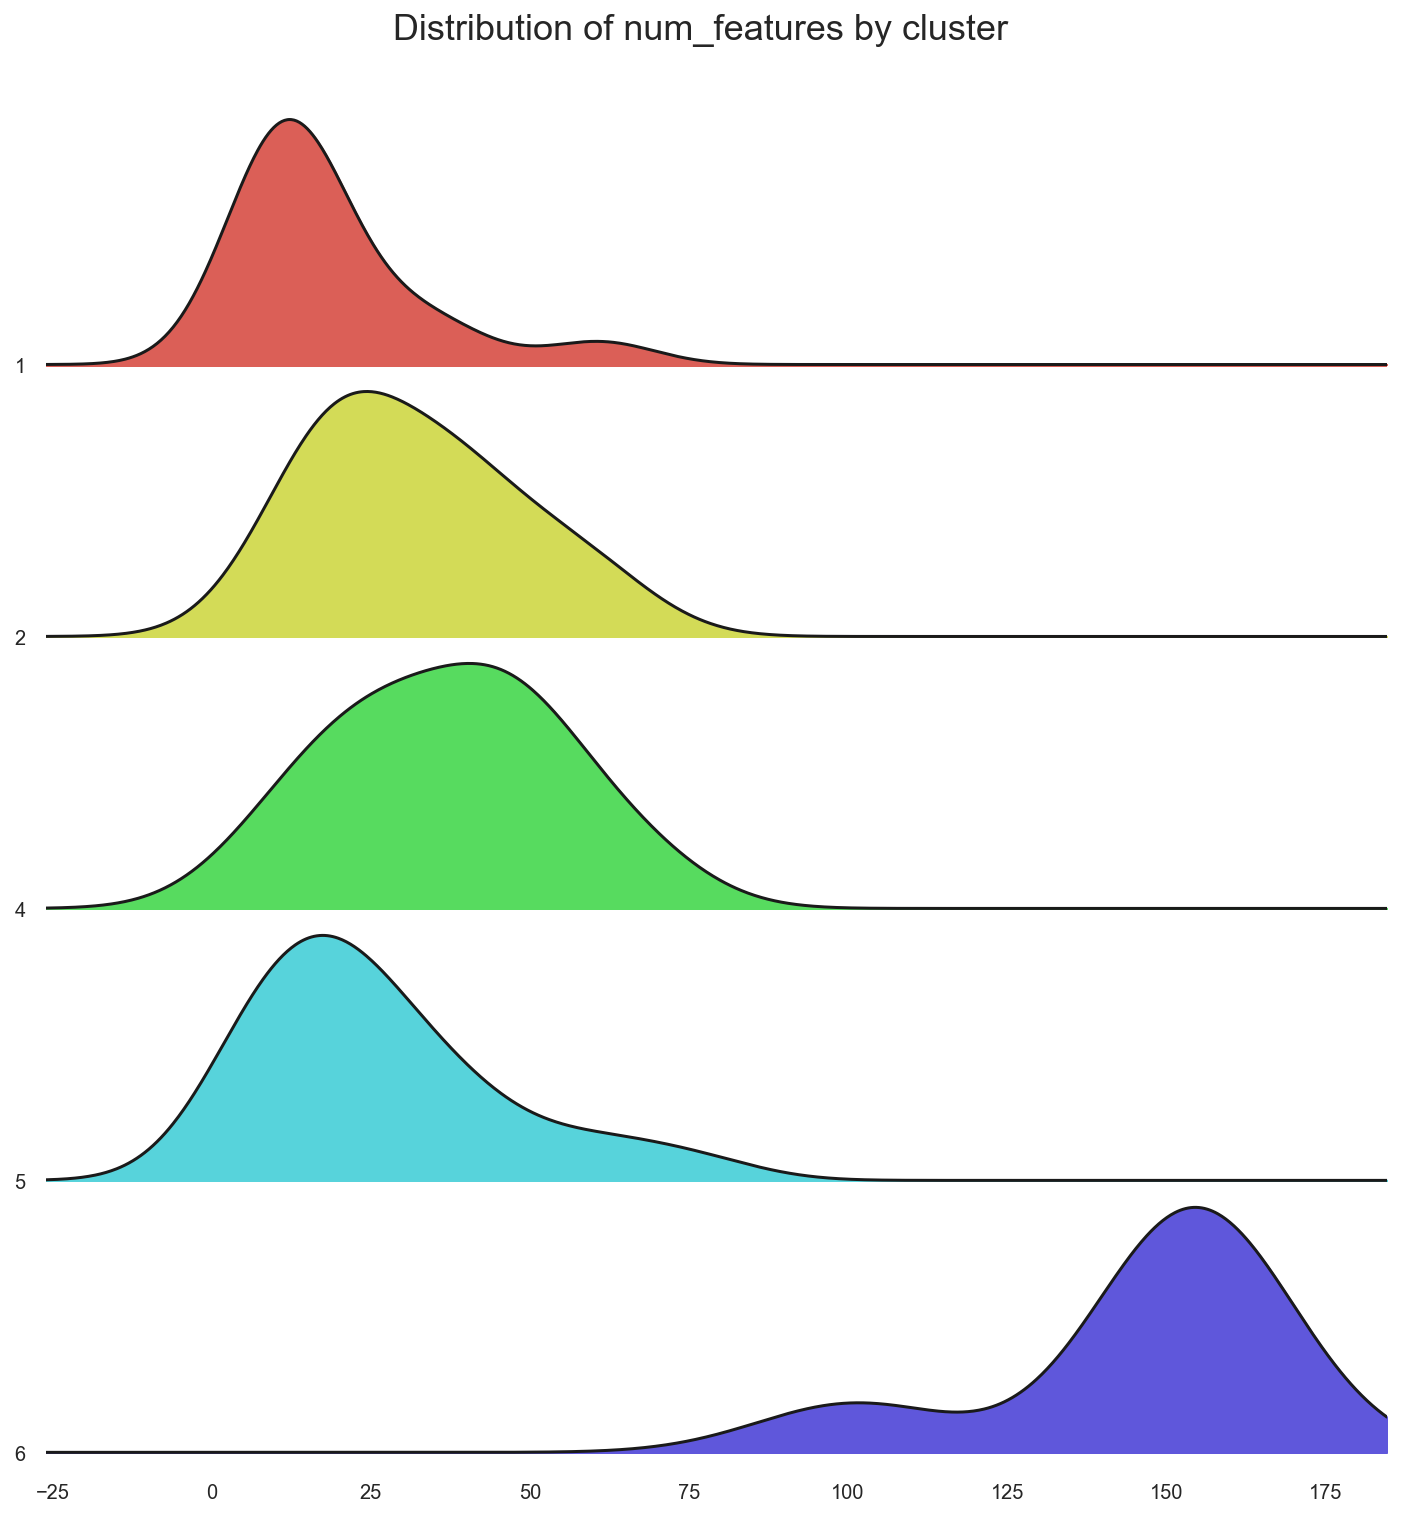

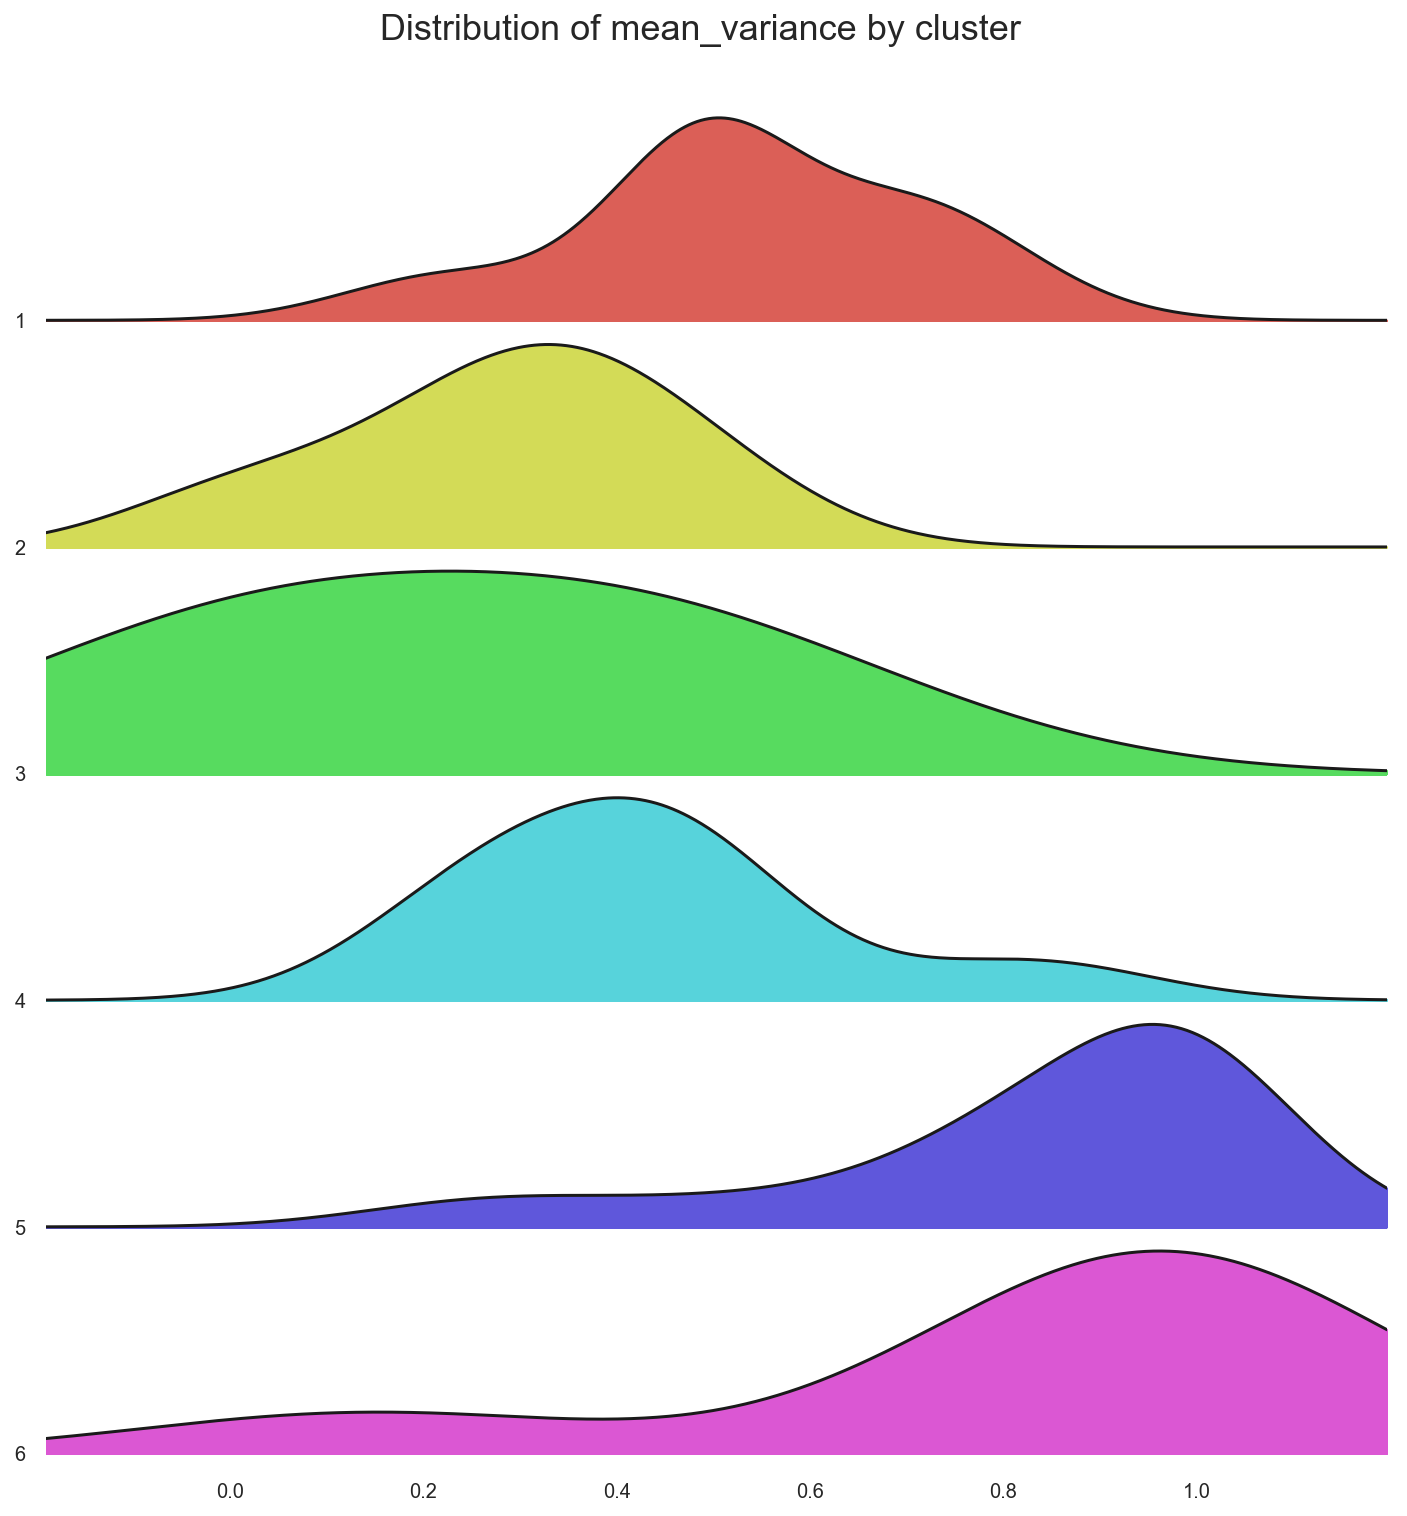

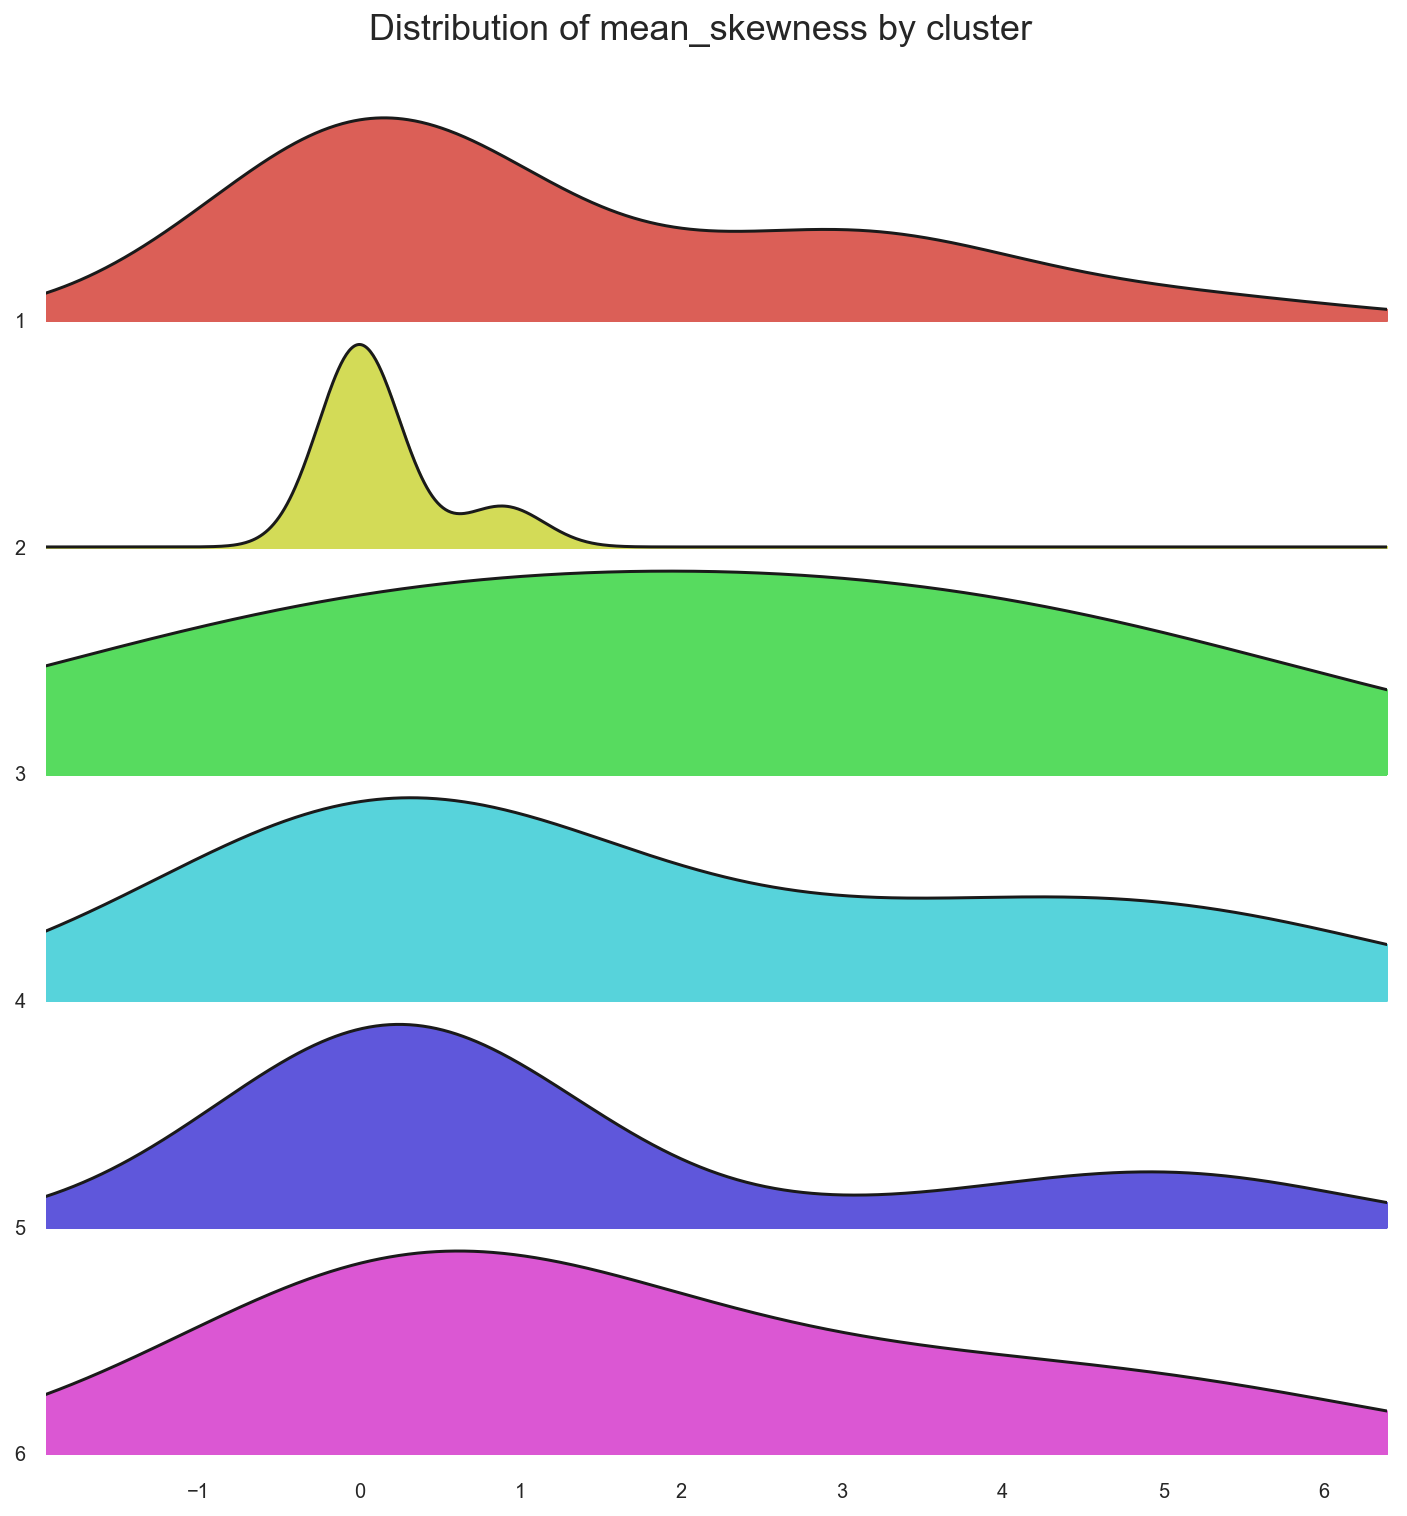

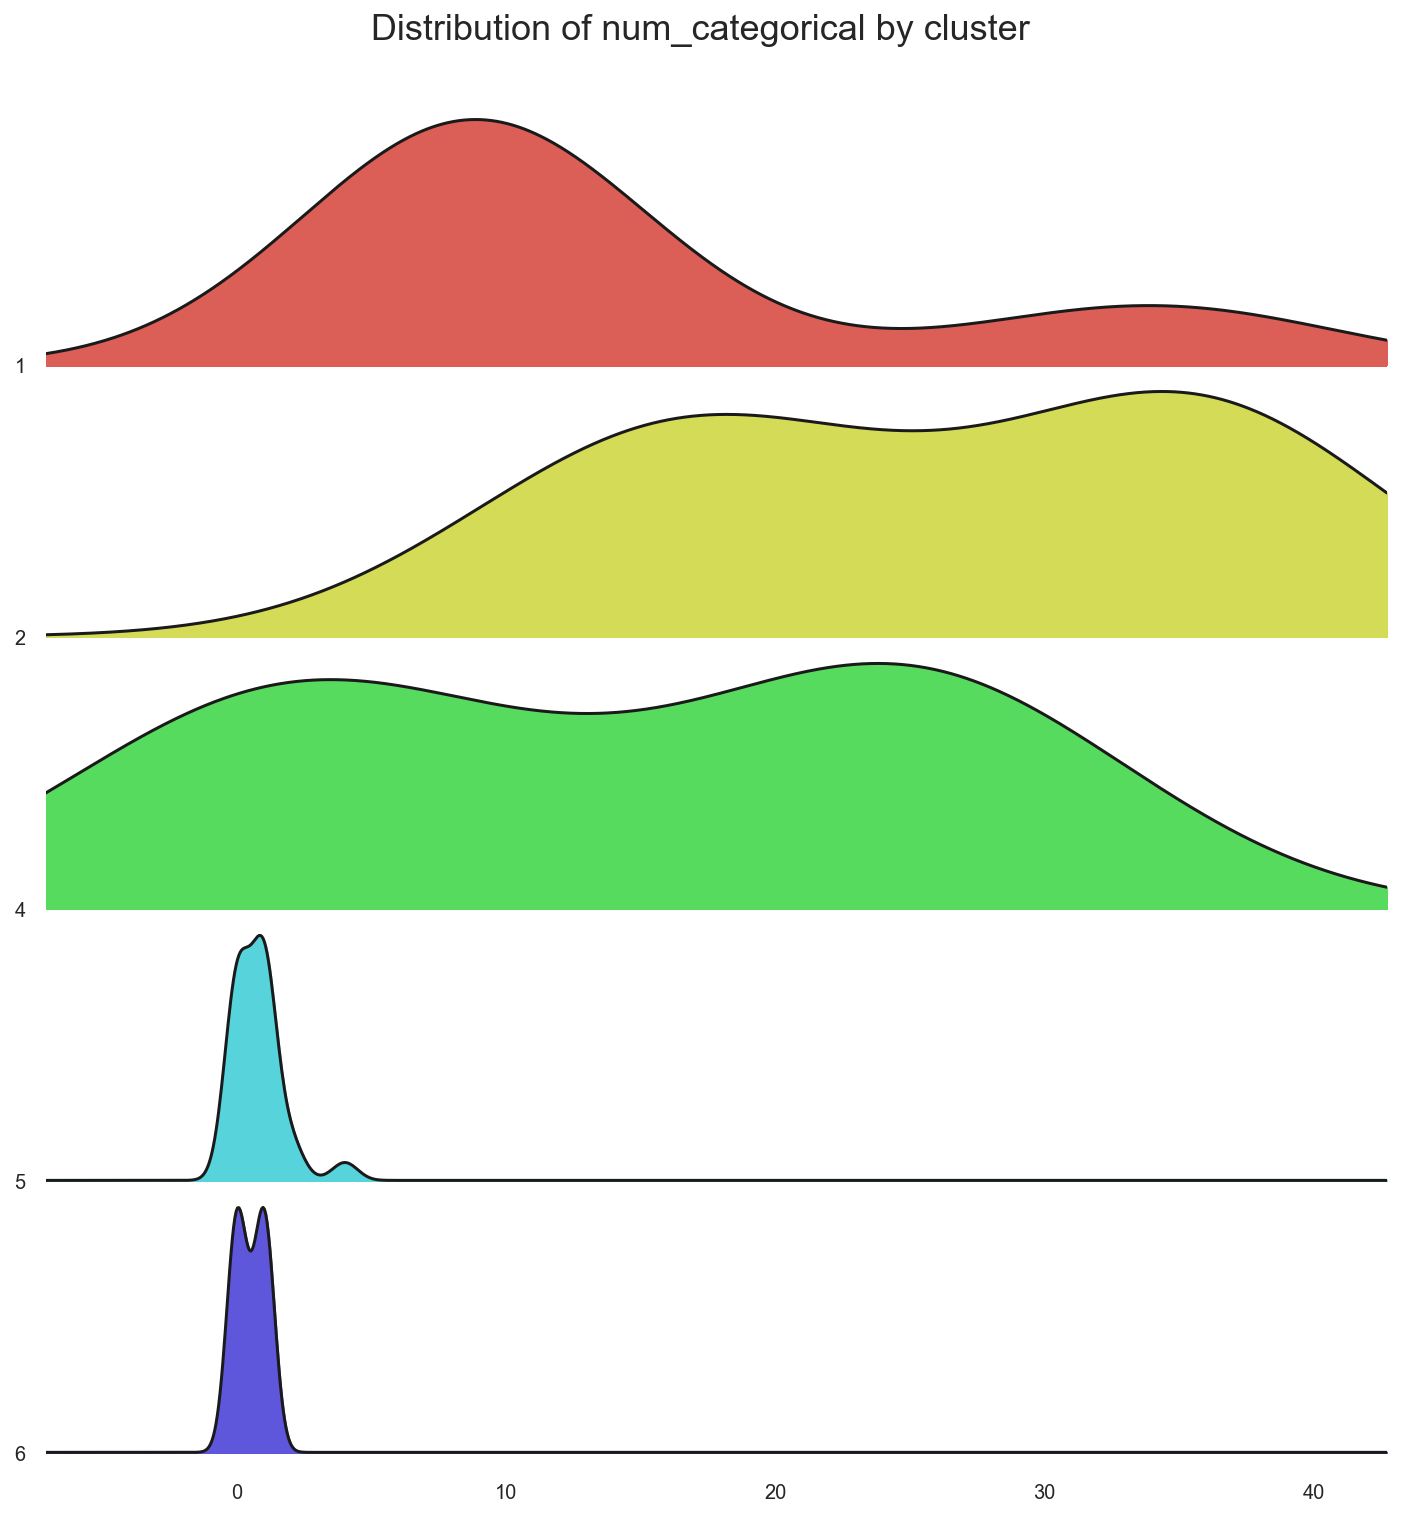

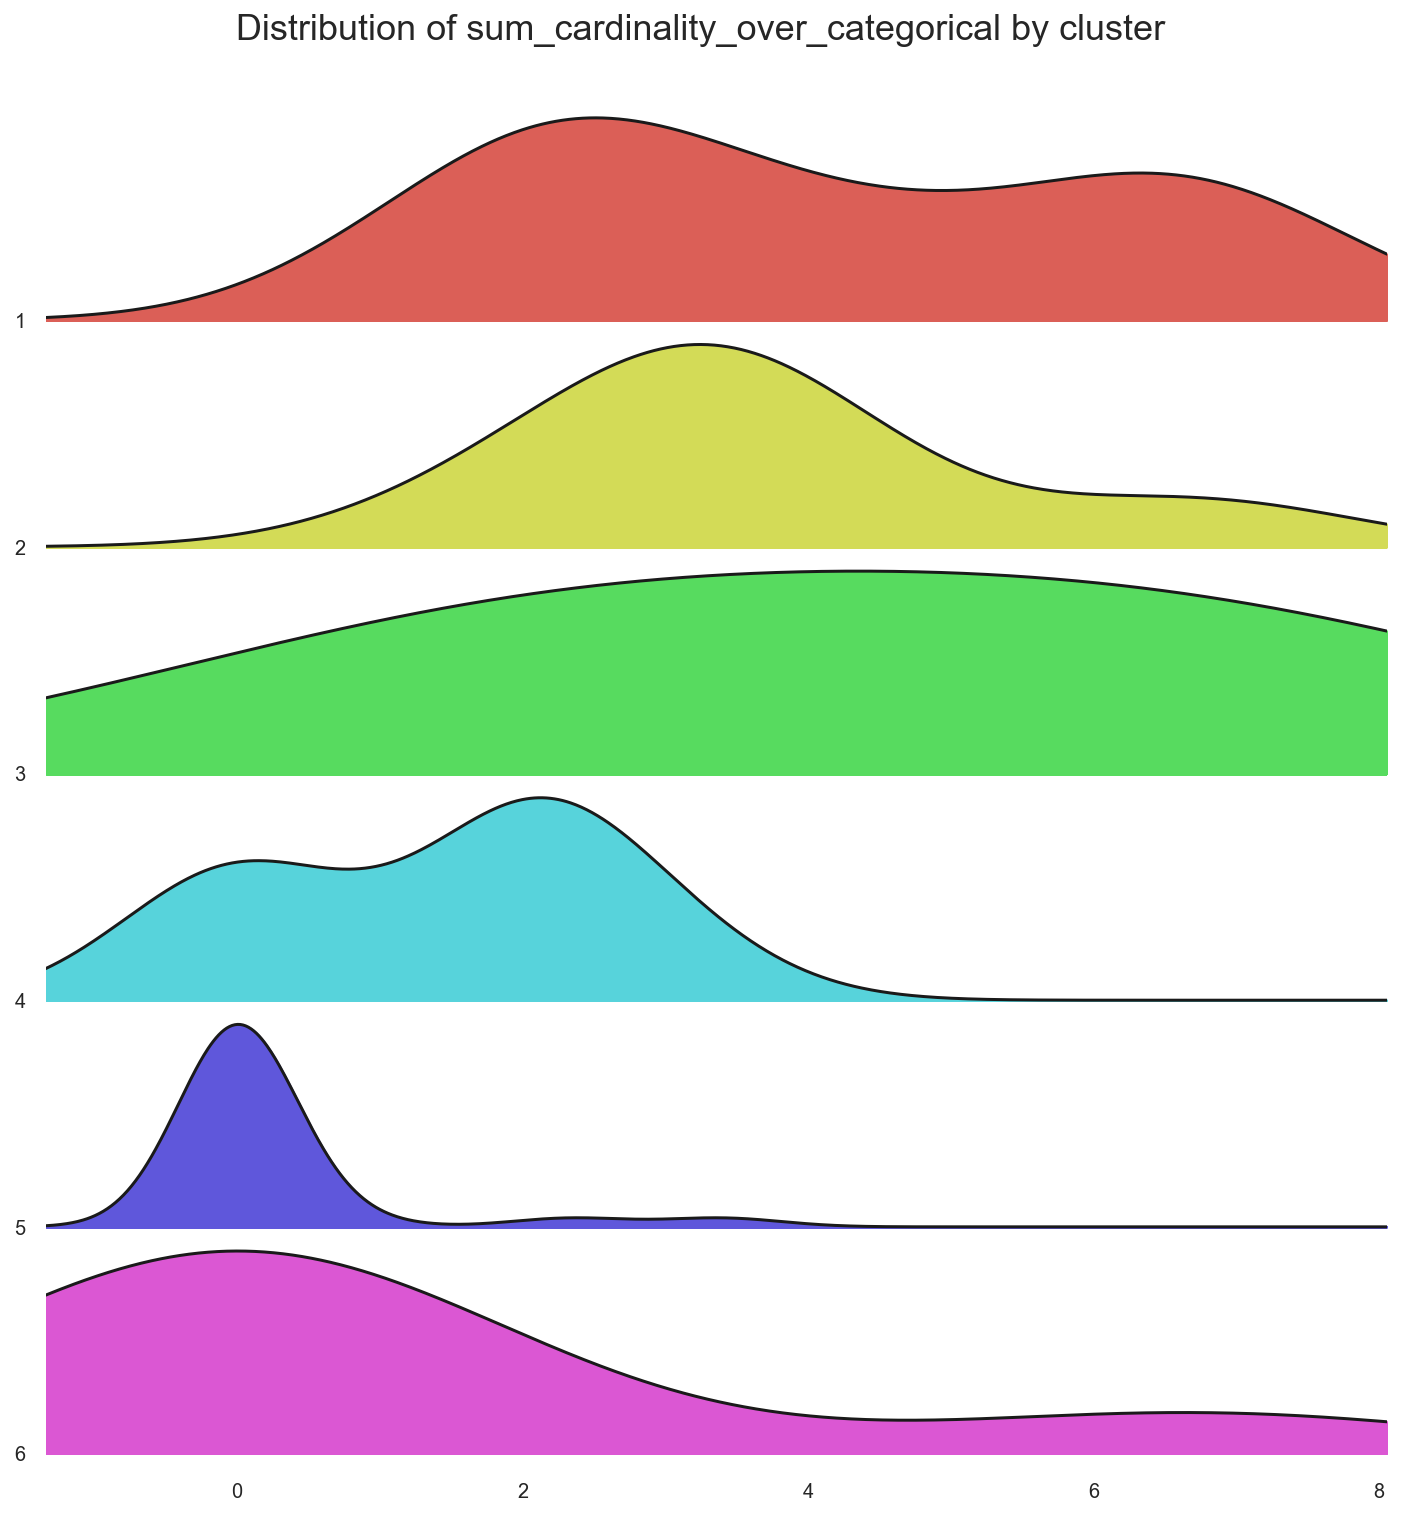

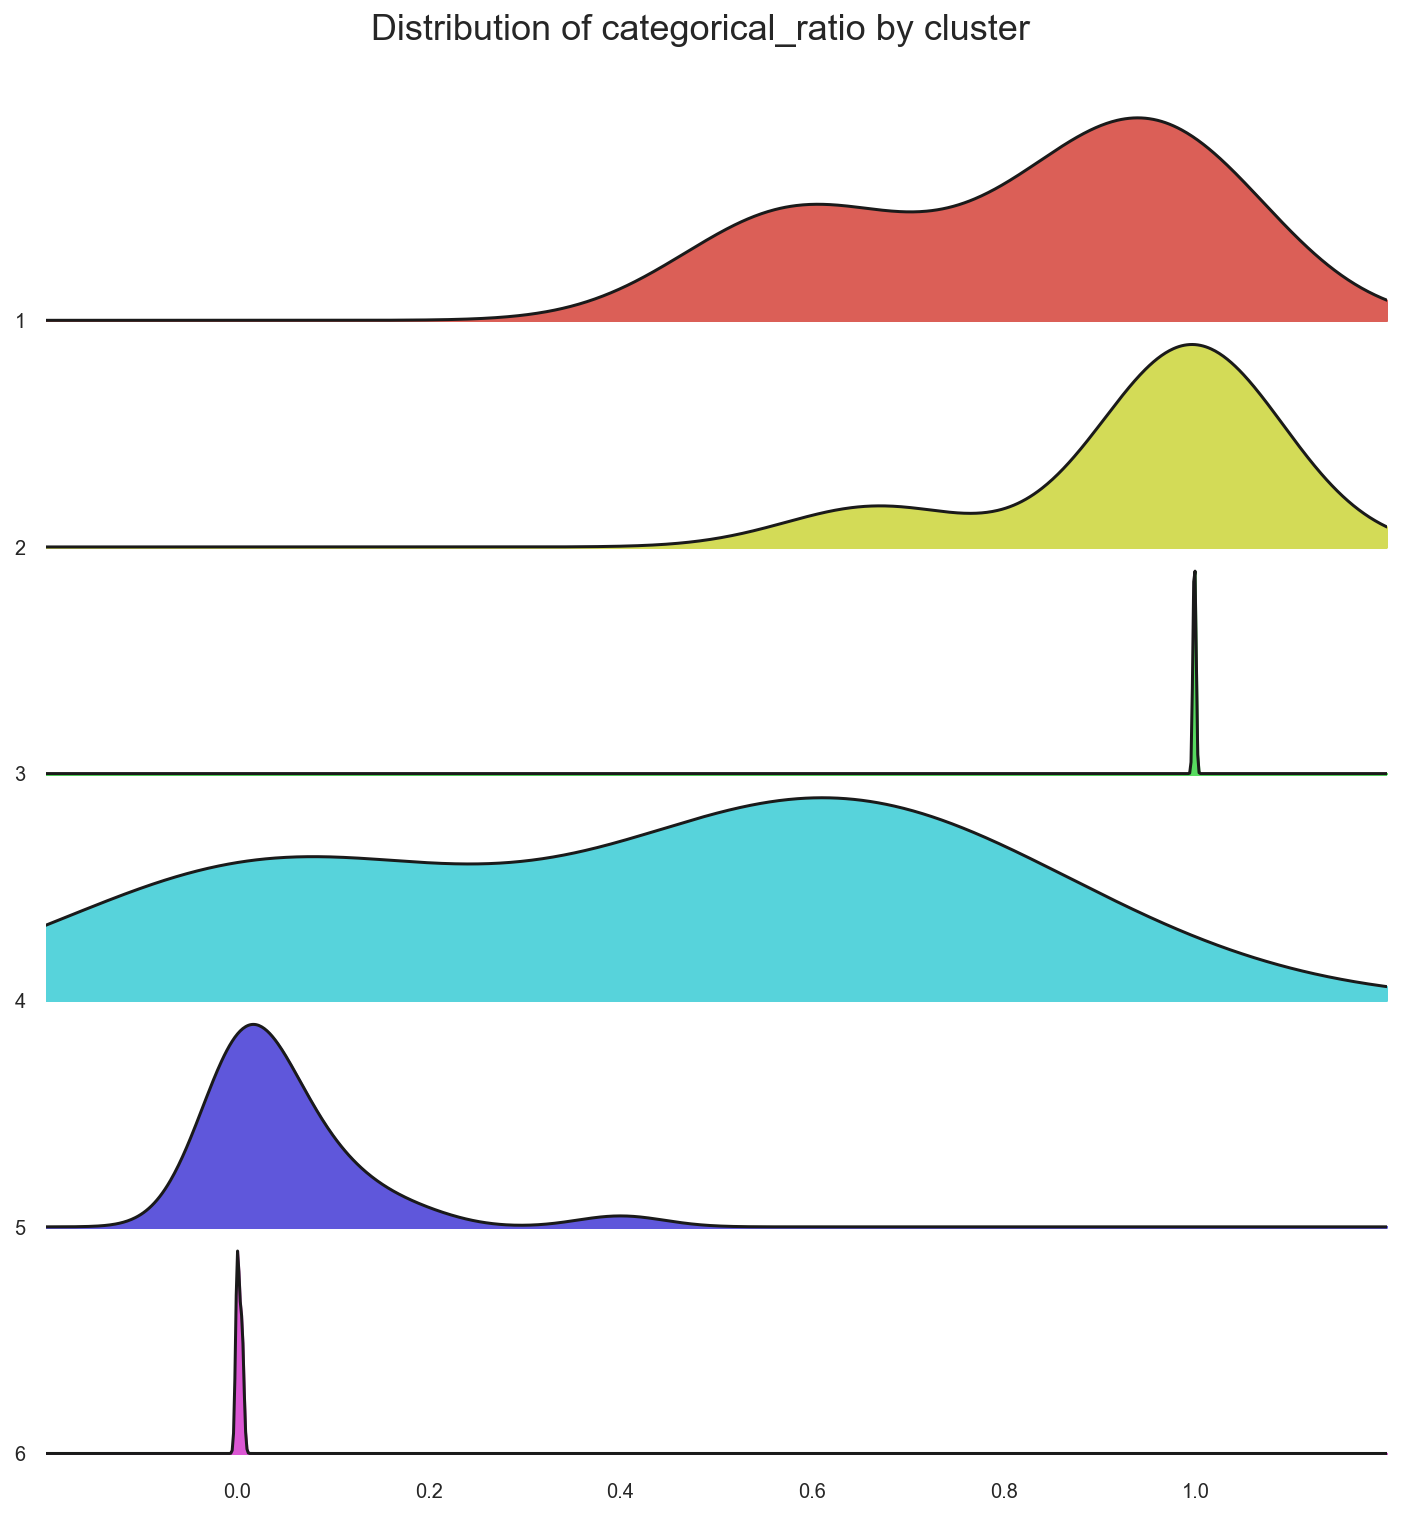

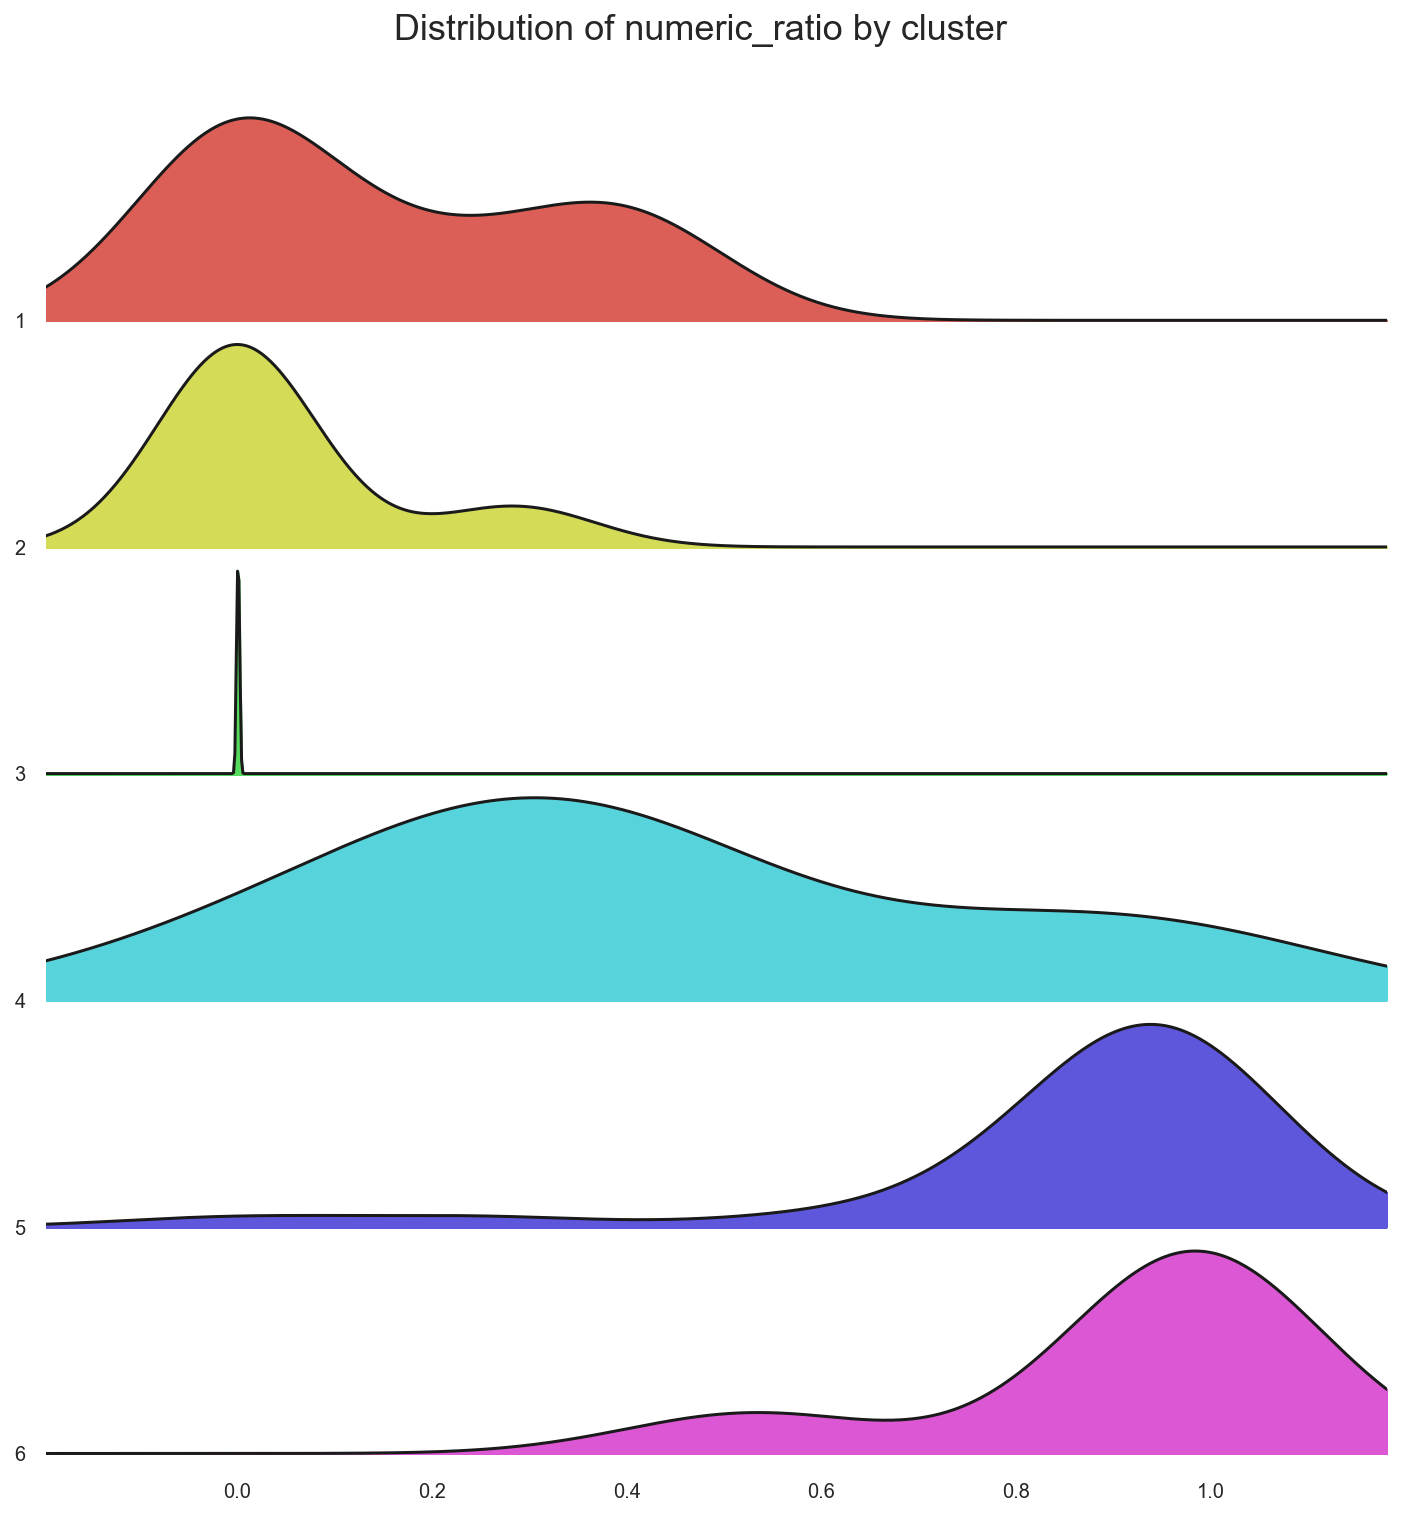

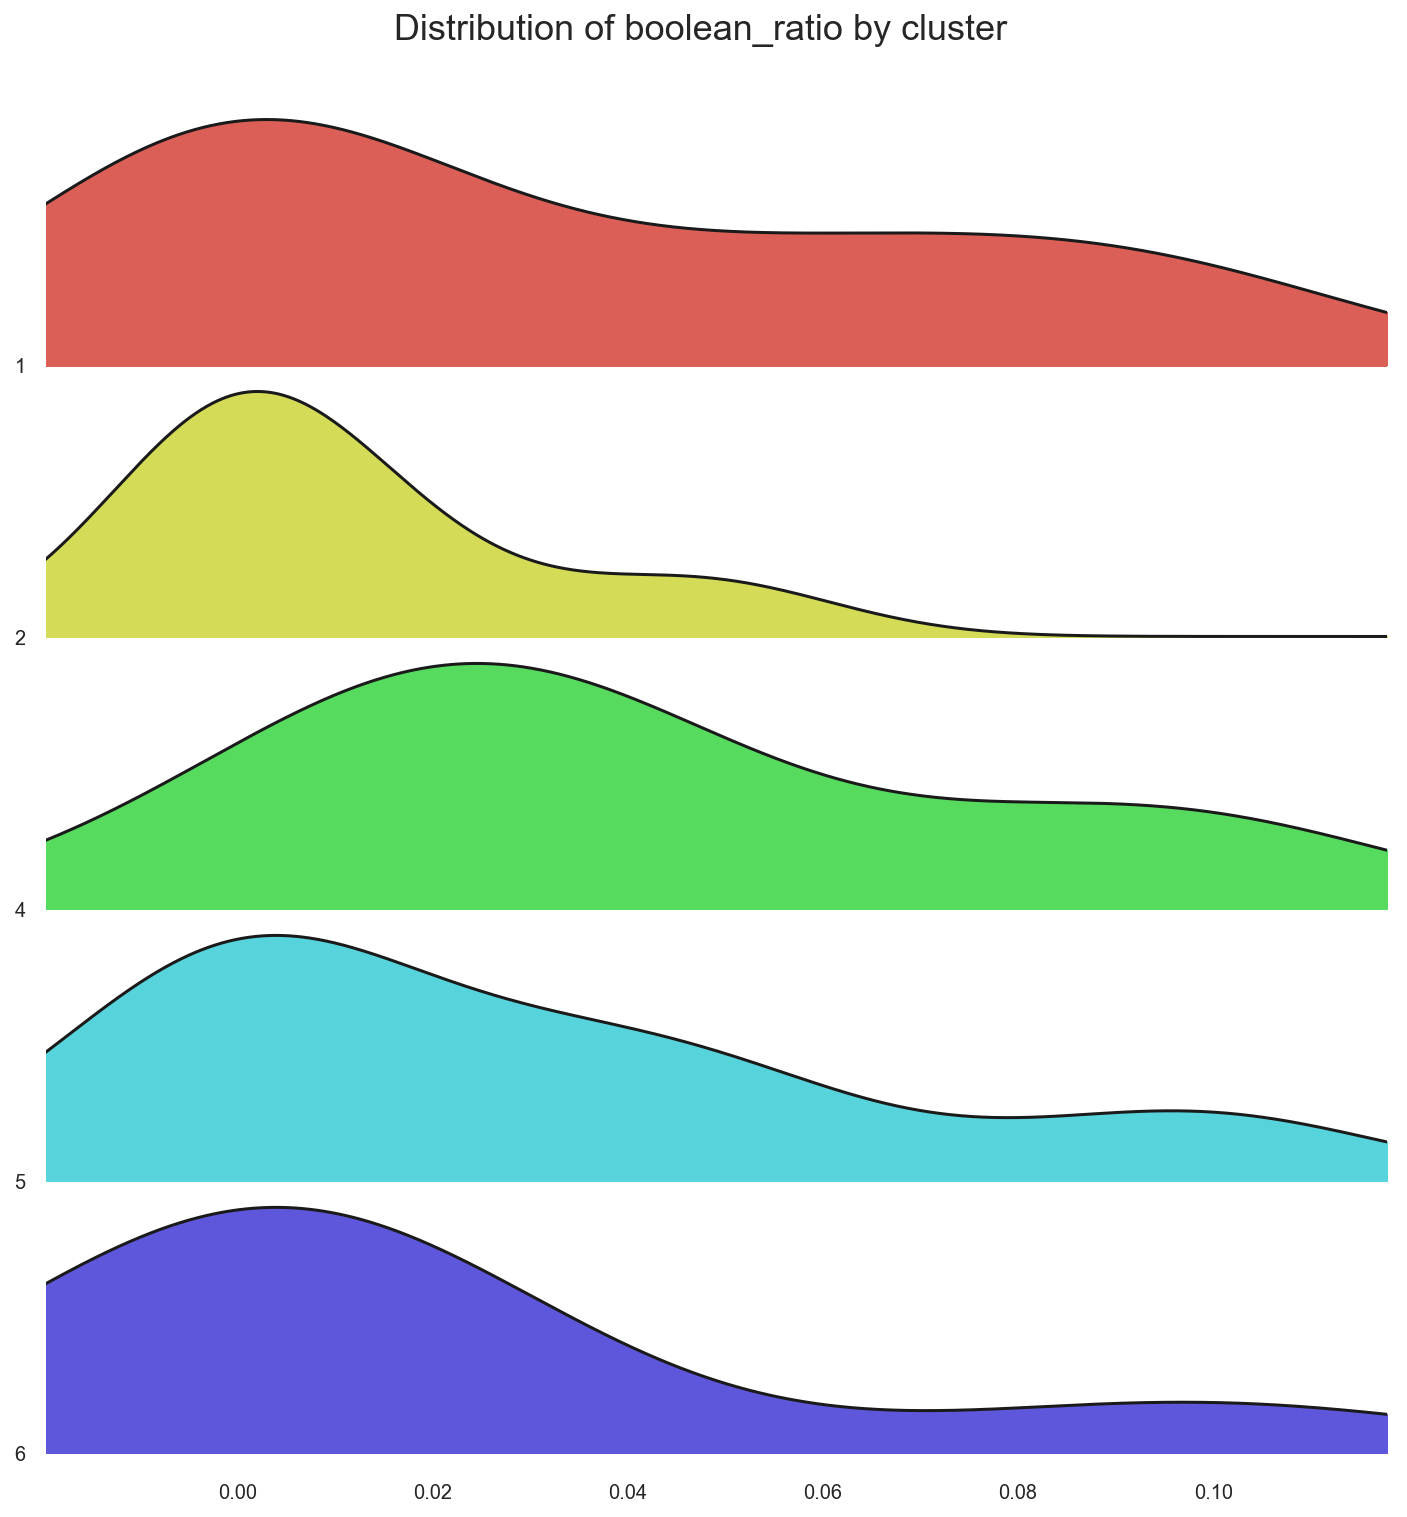

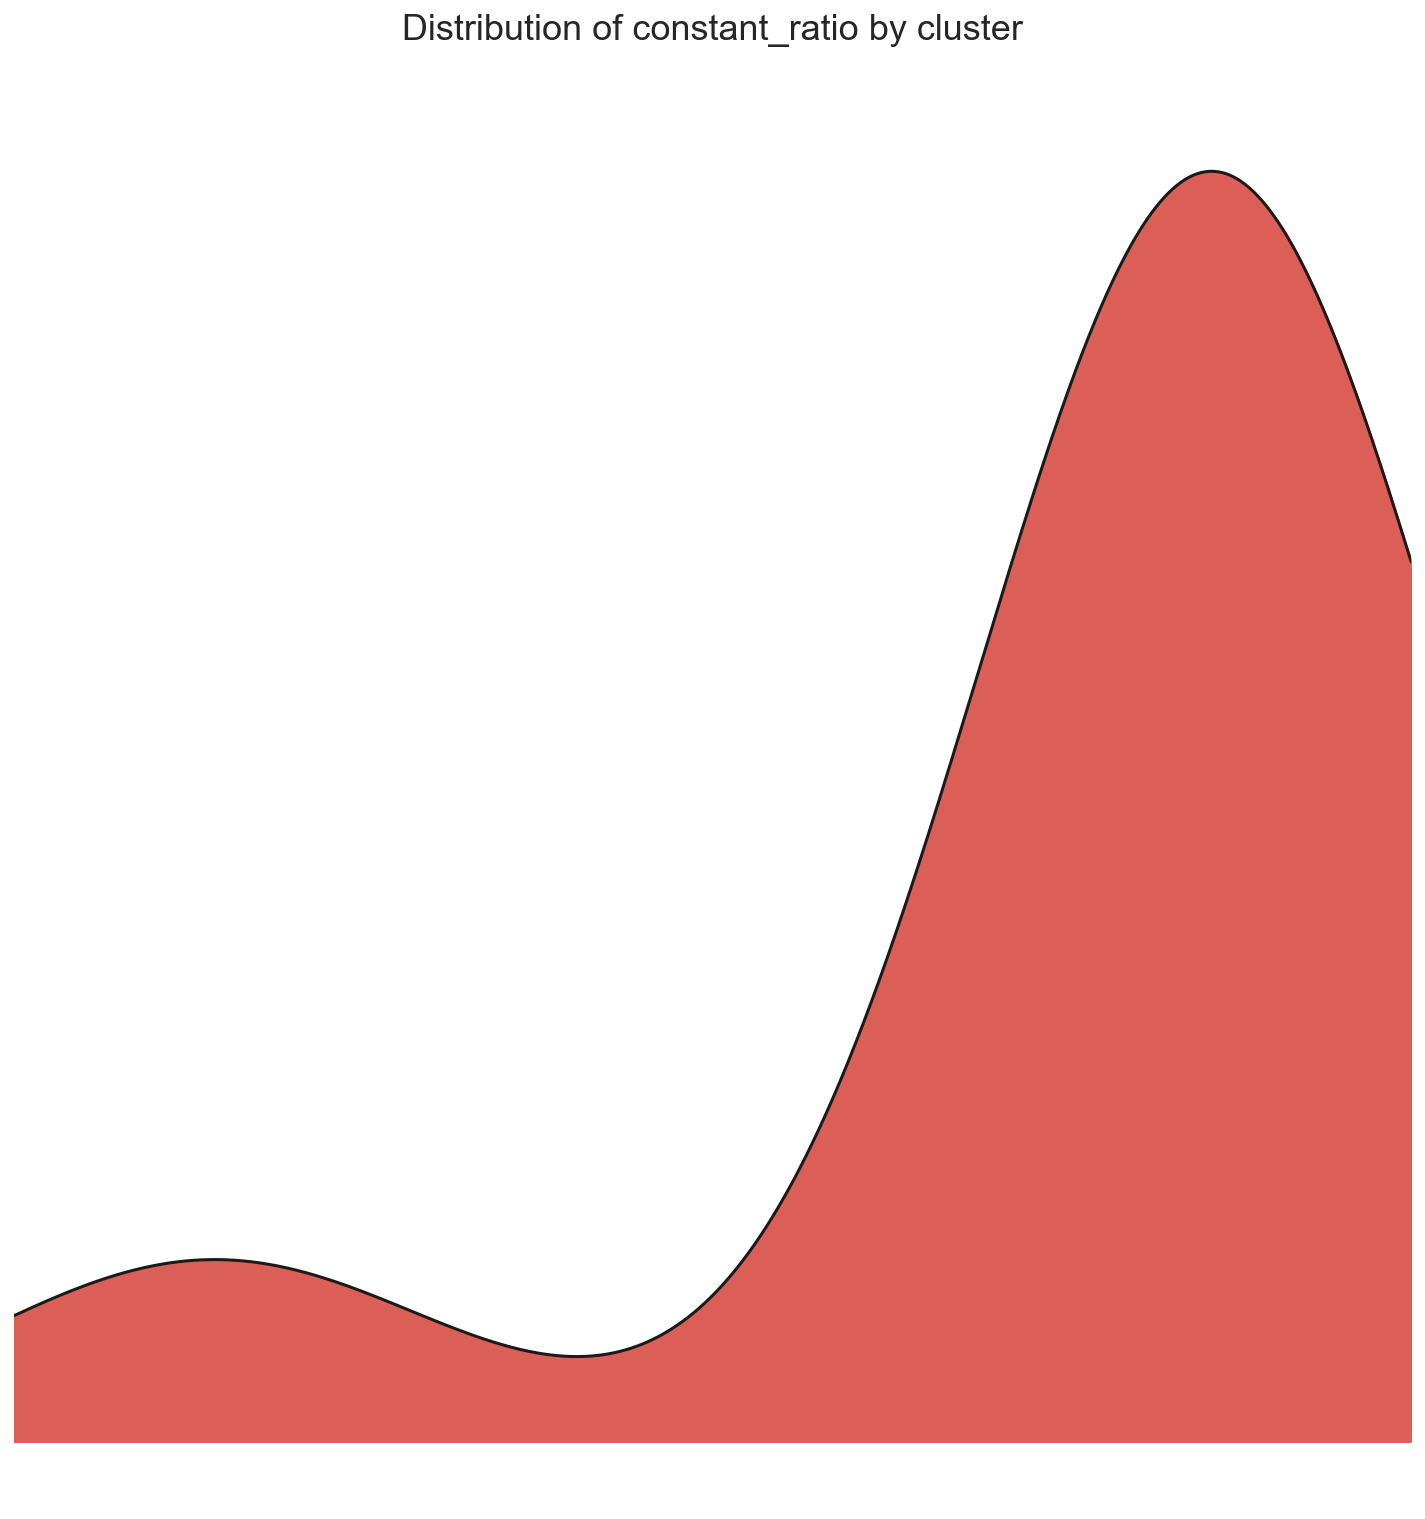

In [21]:
for metric in aggregated_stats.columns[:-1]:
    plot_cluster_joyplot(capped_agg_stats, column=metric)

# Cluster specific Analysis - Cluster 1

In [28]:
cluster_1_dids = aggregated_stats.query(f"cluster == 1").index.values
cluster_1_dids.shape

(15,)

In [41]:
cluster_1_exps = {}
for did in cluster_1_dids:
    cluster_1_exps[did] = build_result_dataframe(open_experiment(did=did).final_result).assign(did=did)
cluster_1_exps.keys()

dict_keys([3, 31, 934, 953, 959, 983, 991, 1037, 1119, 1558, 1590, 4135, 4534, 40680, 40706])

In [64]:
cluster_1 = pd.concat(cluster_1_exps.values())
cluster_1.shape

(79350, 13)

In [68]:
cluster_1.groupby("did").seed.count().rename("count")

did
3        5290
31       5290
934      5290
953      5290
959      5290
983      5290
991      5290
1037     5290
1119     5290
1558     5290
1590     5290
4135     5290
4534     5290
40680    5290
40706    5290
Name: count, dtype: int64

In [8]:
import cloudpickle
# open("cluster_1.pkl", "wb").write(cloudpickle.dumps(cluster_1))
# cluster_1 = pickle.load(open("cluster_1.pkl", "rb"))

In [69]:
import gc
del cluster_1_exps
gc.collect()

27831

## Num estimators

Defining useful functions

In [9]:
train_pred = "type == 'train'"
test_pred = "type == 'test'"

individual_num_est_pred = (
    "(num_estimators == num_estimators) & (max_depth != max_depth) & (learning_rate != learning_rate)"
)


@fp.curry
def calculate_delta_baseline(did_df, metric="auc_evaluator__target", diff_column="diff_num_est"):
    """For a given dataframe, calculate the delta of the metric related to the baseline metric,
       which is the metric where diff_column is closer to 0"""
    return did_df.assign(
        baseline_metric=lambda df: df[metric].loc[df.query(test_pred).sort_values(by=diff_column).index[0]],
        delta_metric=lambda df: df[metric] - df.baseline_metric,
    ).reset_index(drop=True)

In [10]:
def update_pointplot_xlabels(multiple_of=5, rotation=0):
    new_labels = []
    for i, label in enumerate(plt.gca().get_xticklabels()):
        new_labels.append(label if i%multiple_of==0 else "")
    plt.gca().set_xticklabels(new_labels, rotation=rotation)

In [11]:
# curried delta functions
delta_baseline_num_est_fn = calculate_delta_baseline(metric="auc_evaluator__target", diff_column="diff_num_est")
delta_baseline_num_est_brier_fn = calculate_delta_baseline(
    metric="brier_score_evaluator__target", diff_column="diff_num_est"
)
delta_baseline_num_est_logloss_fn = calculate_delta_baseline(
    metric="logloss_evaluator__target", diff_column="diff_num_est"
)


grouped_num_est = (
    cluster_1.query(individual_num_est_pred)
    .assign(
        num_estimators=lambda df: df.num_estimators.astype(int), diff_num_est=lambda df: abs(df.num_estimators - 100)
    )
    .groupby("did")
)
num_est_deltas = grouped_num_est.apply(delta_baseline_num_est_fn)
num_est_deltas_brier = grouped_num_est.apply(delta_baseline_num_est_brier_fn)
num_est_deltas_logloss = grouped_num_est.apply(delta_baseline_num_est_logloss_fn)
num_est_deltas.shape

(600, 16)

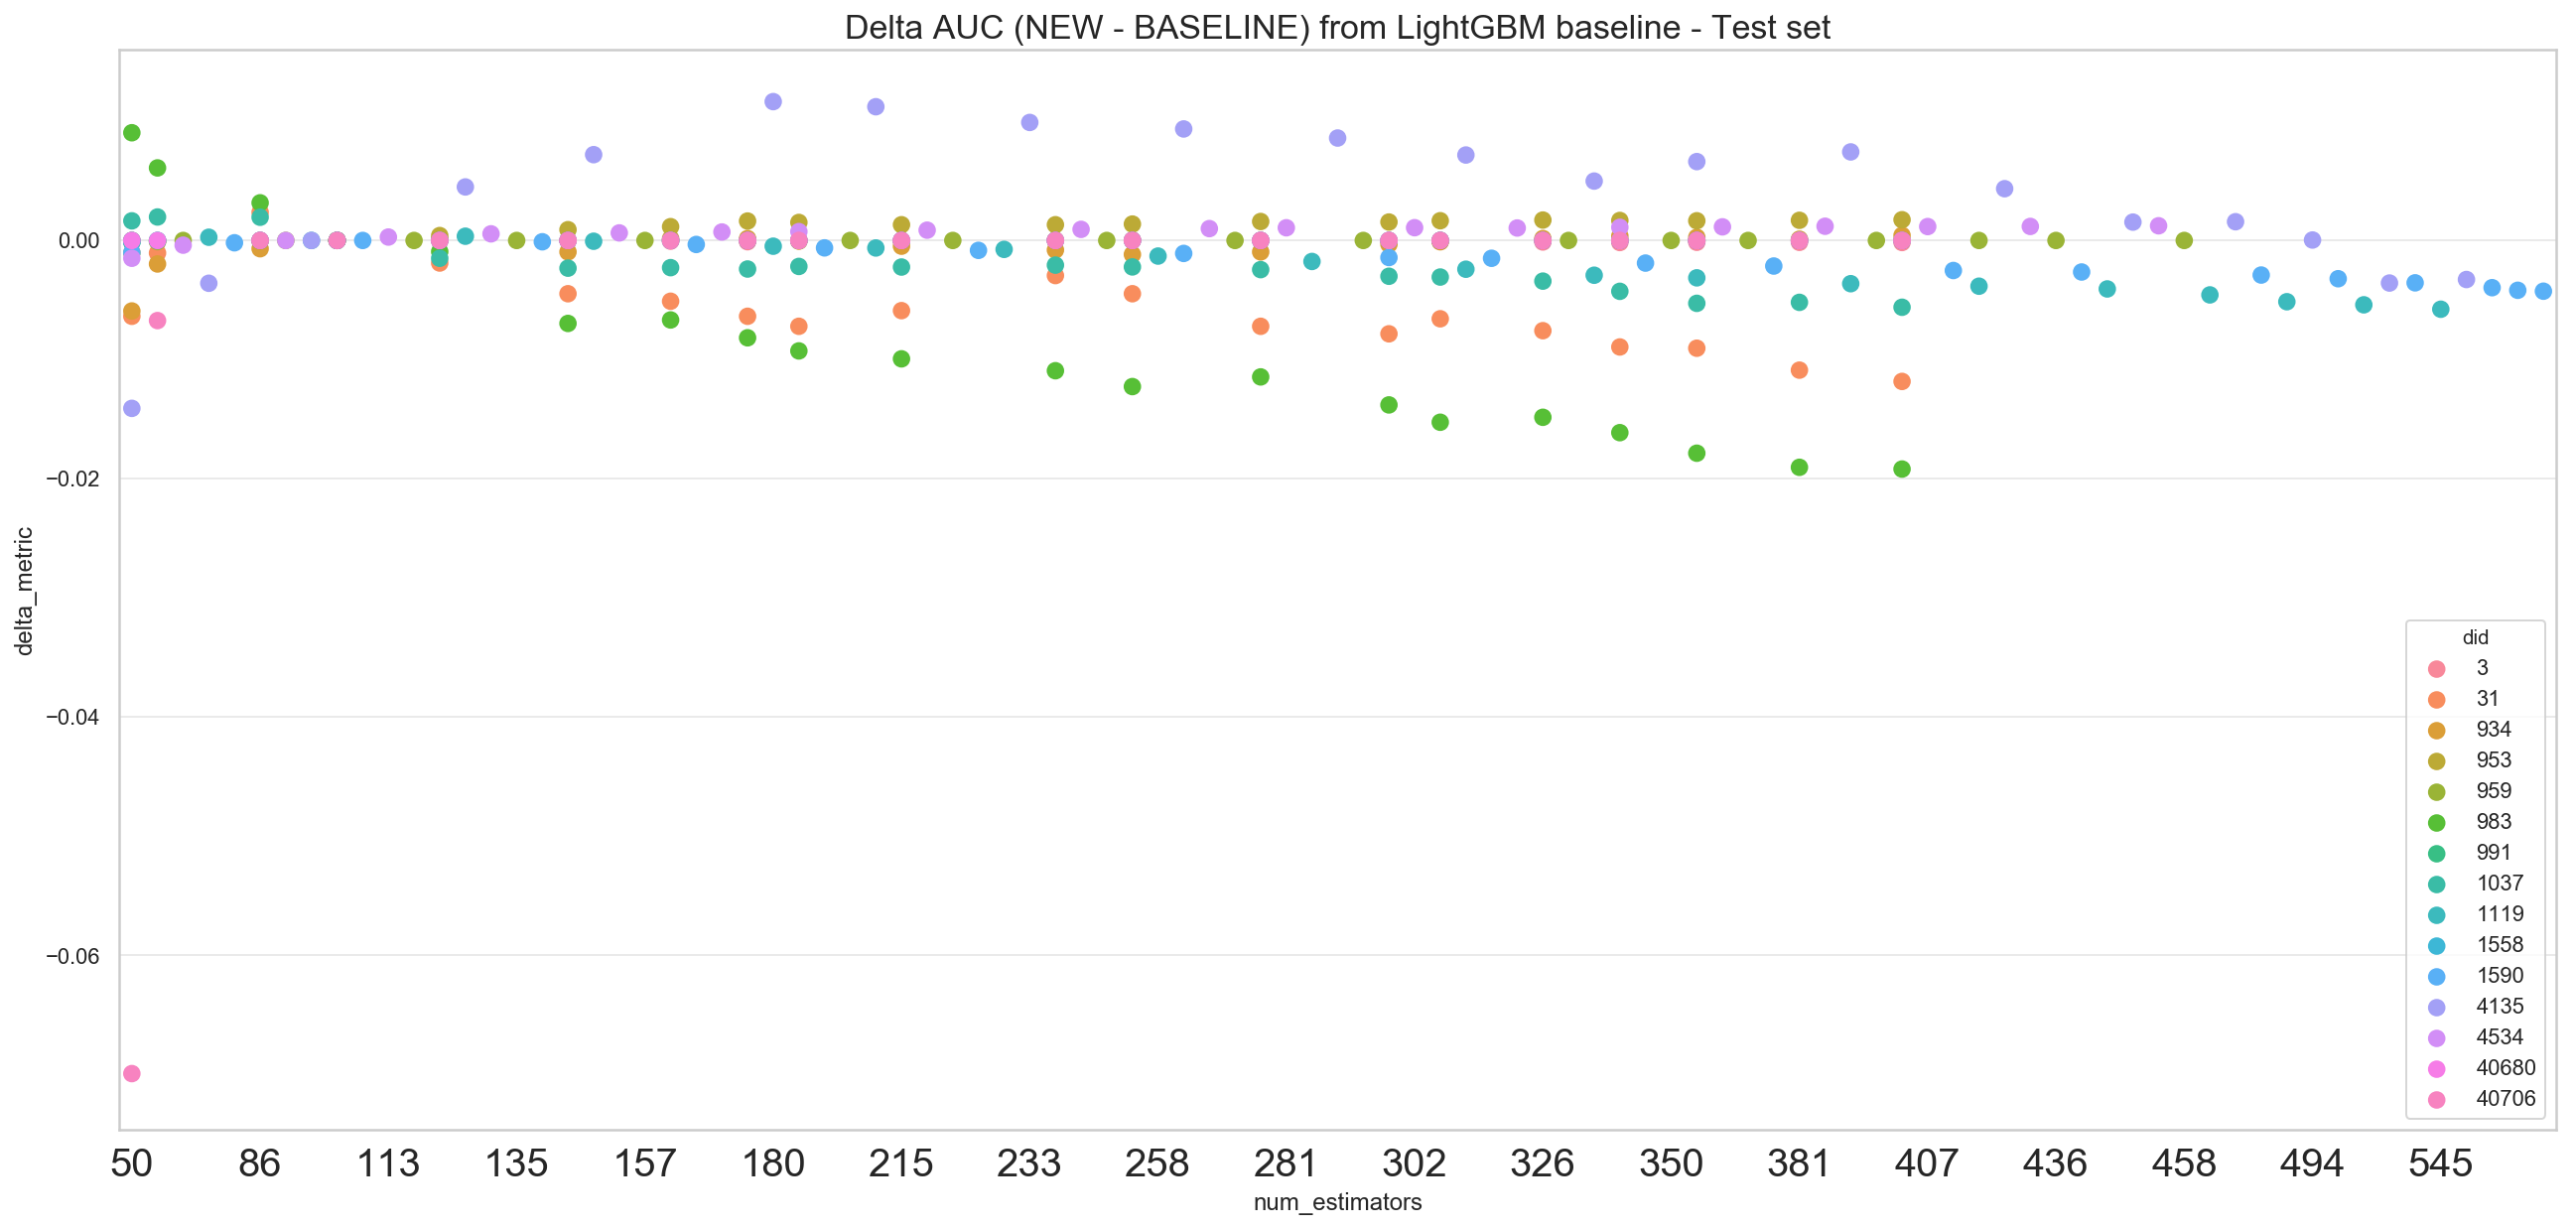

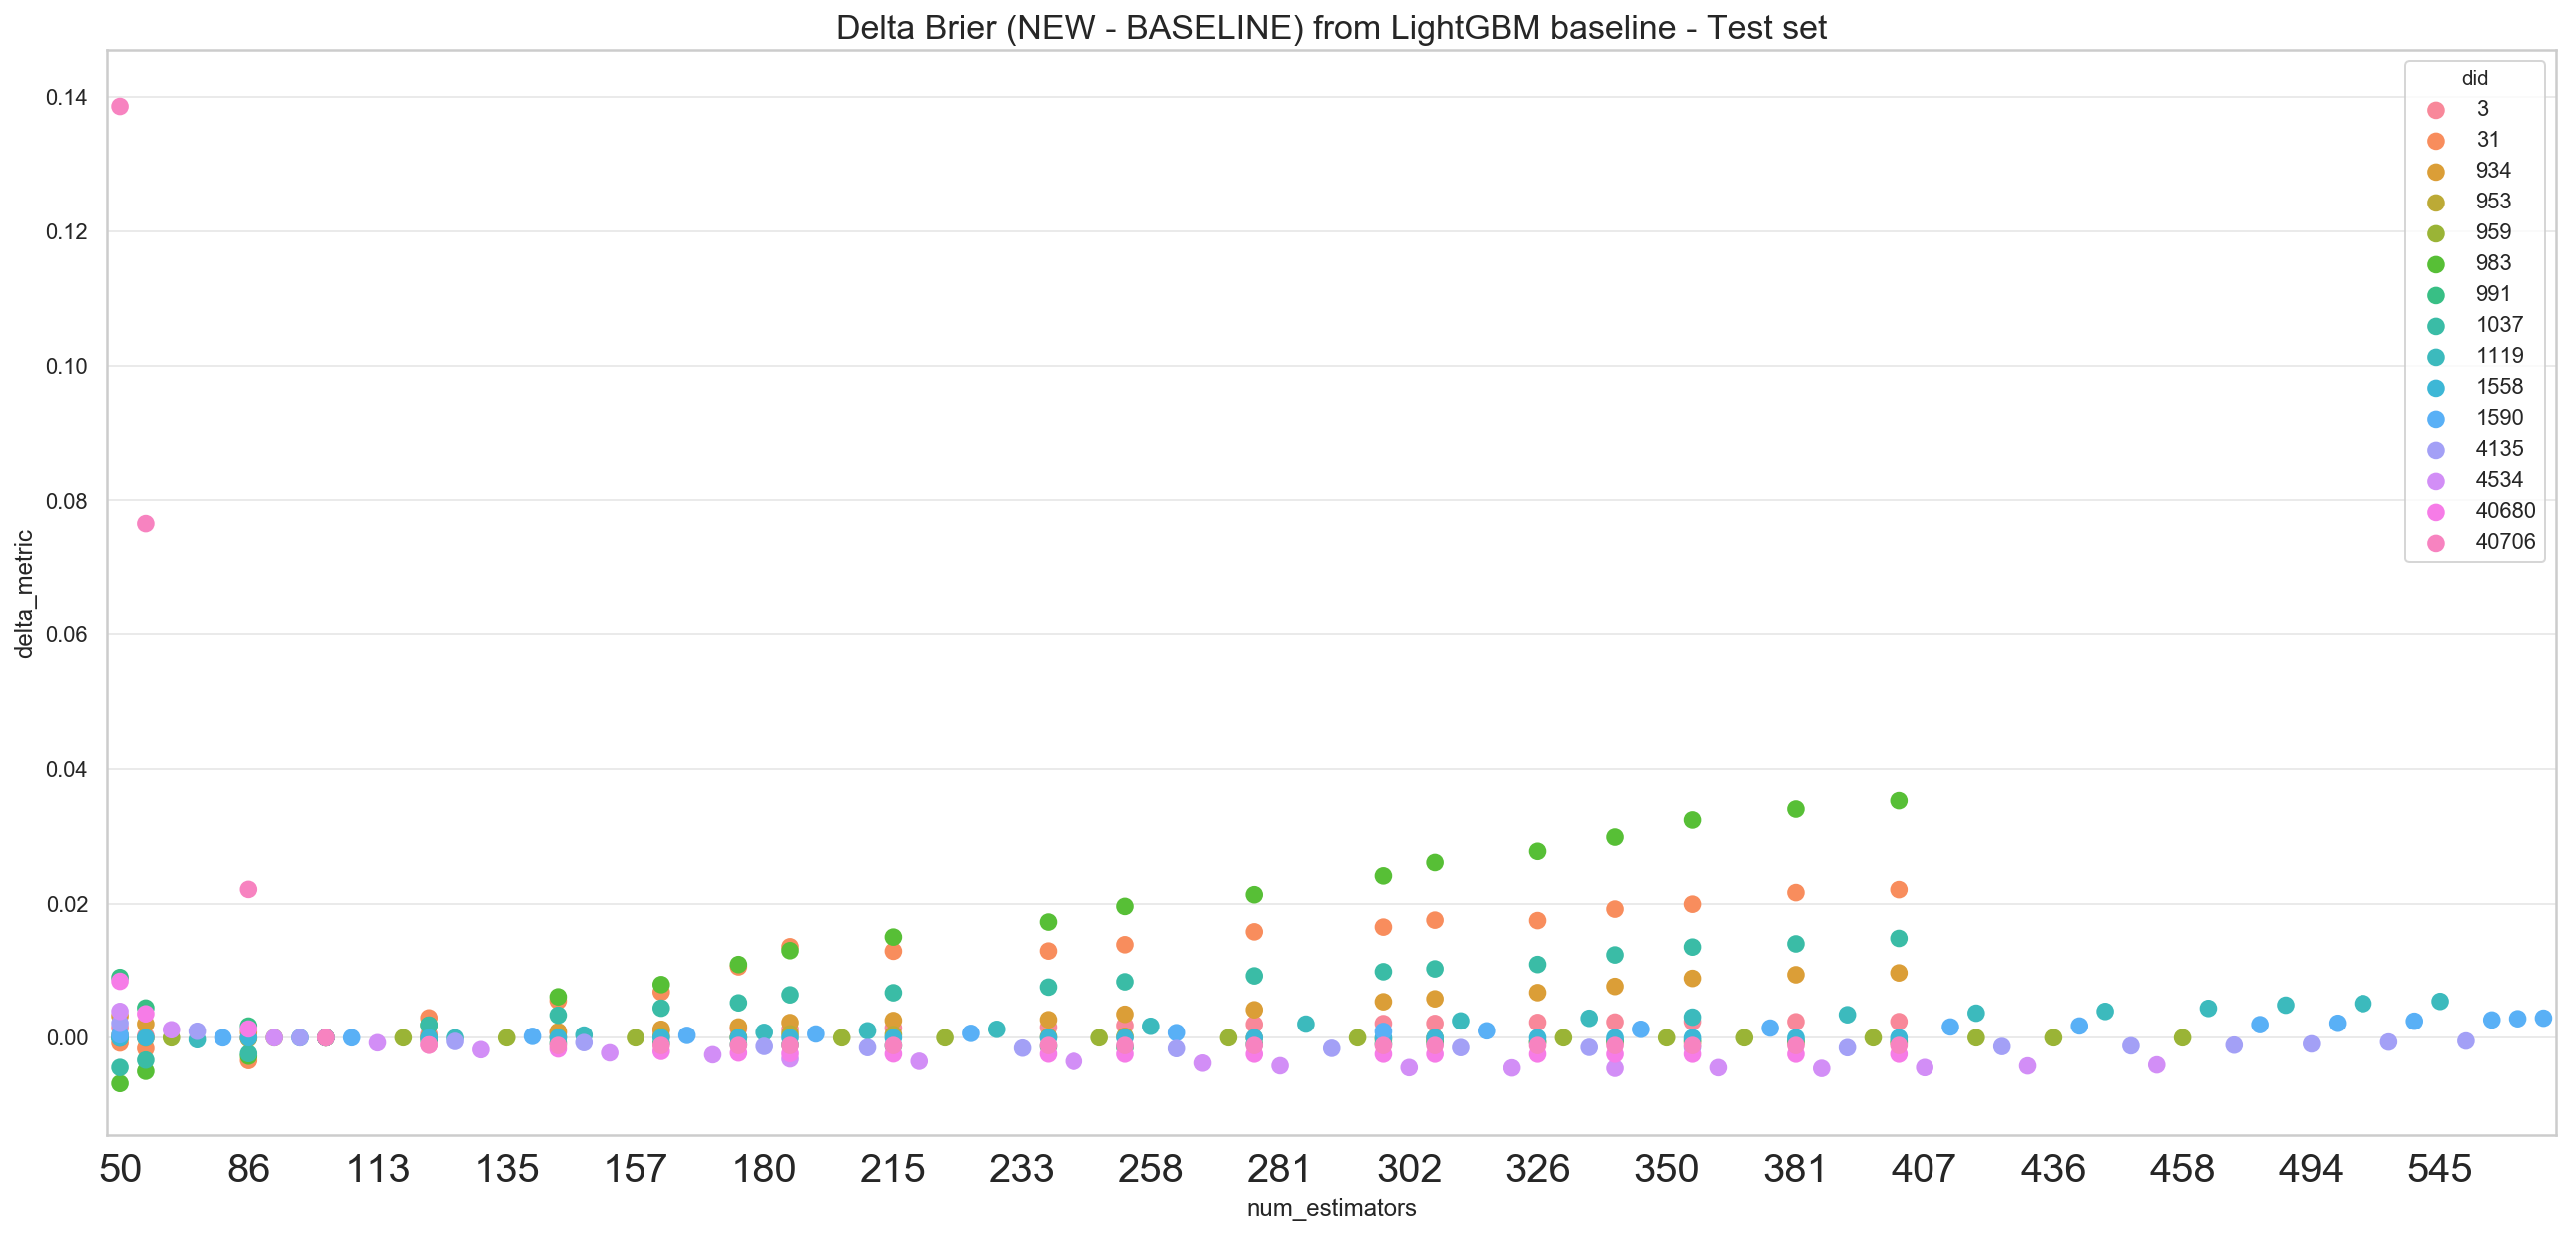

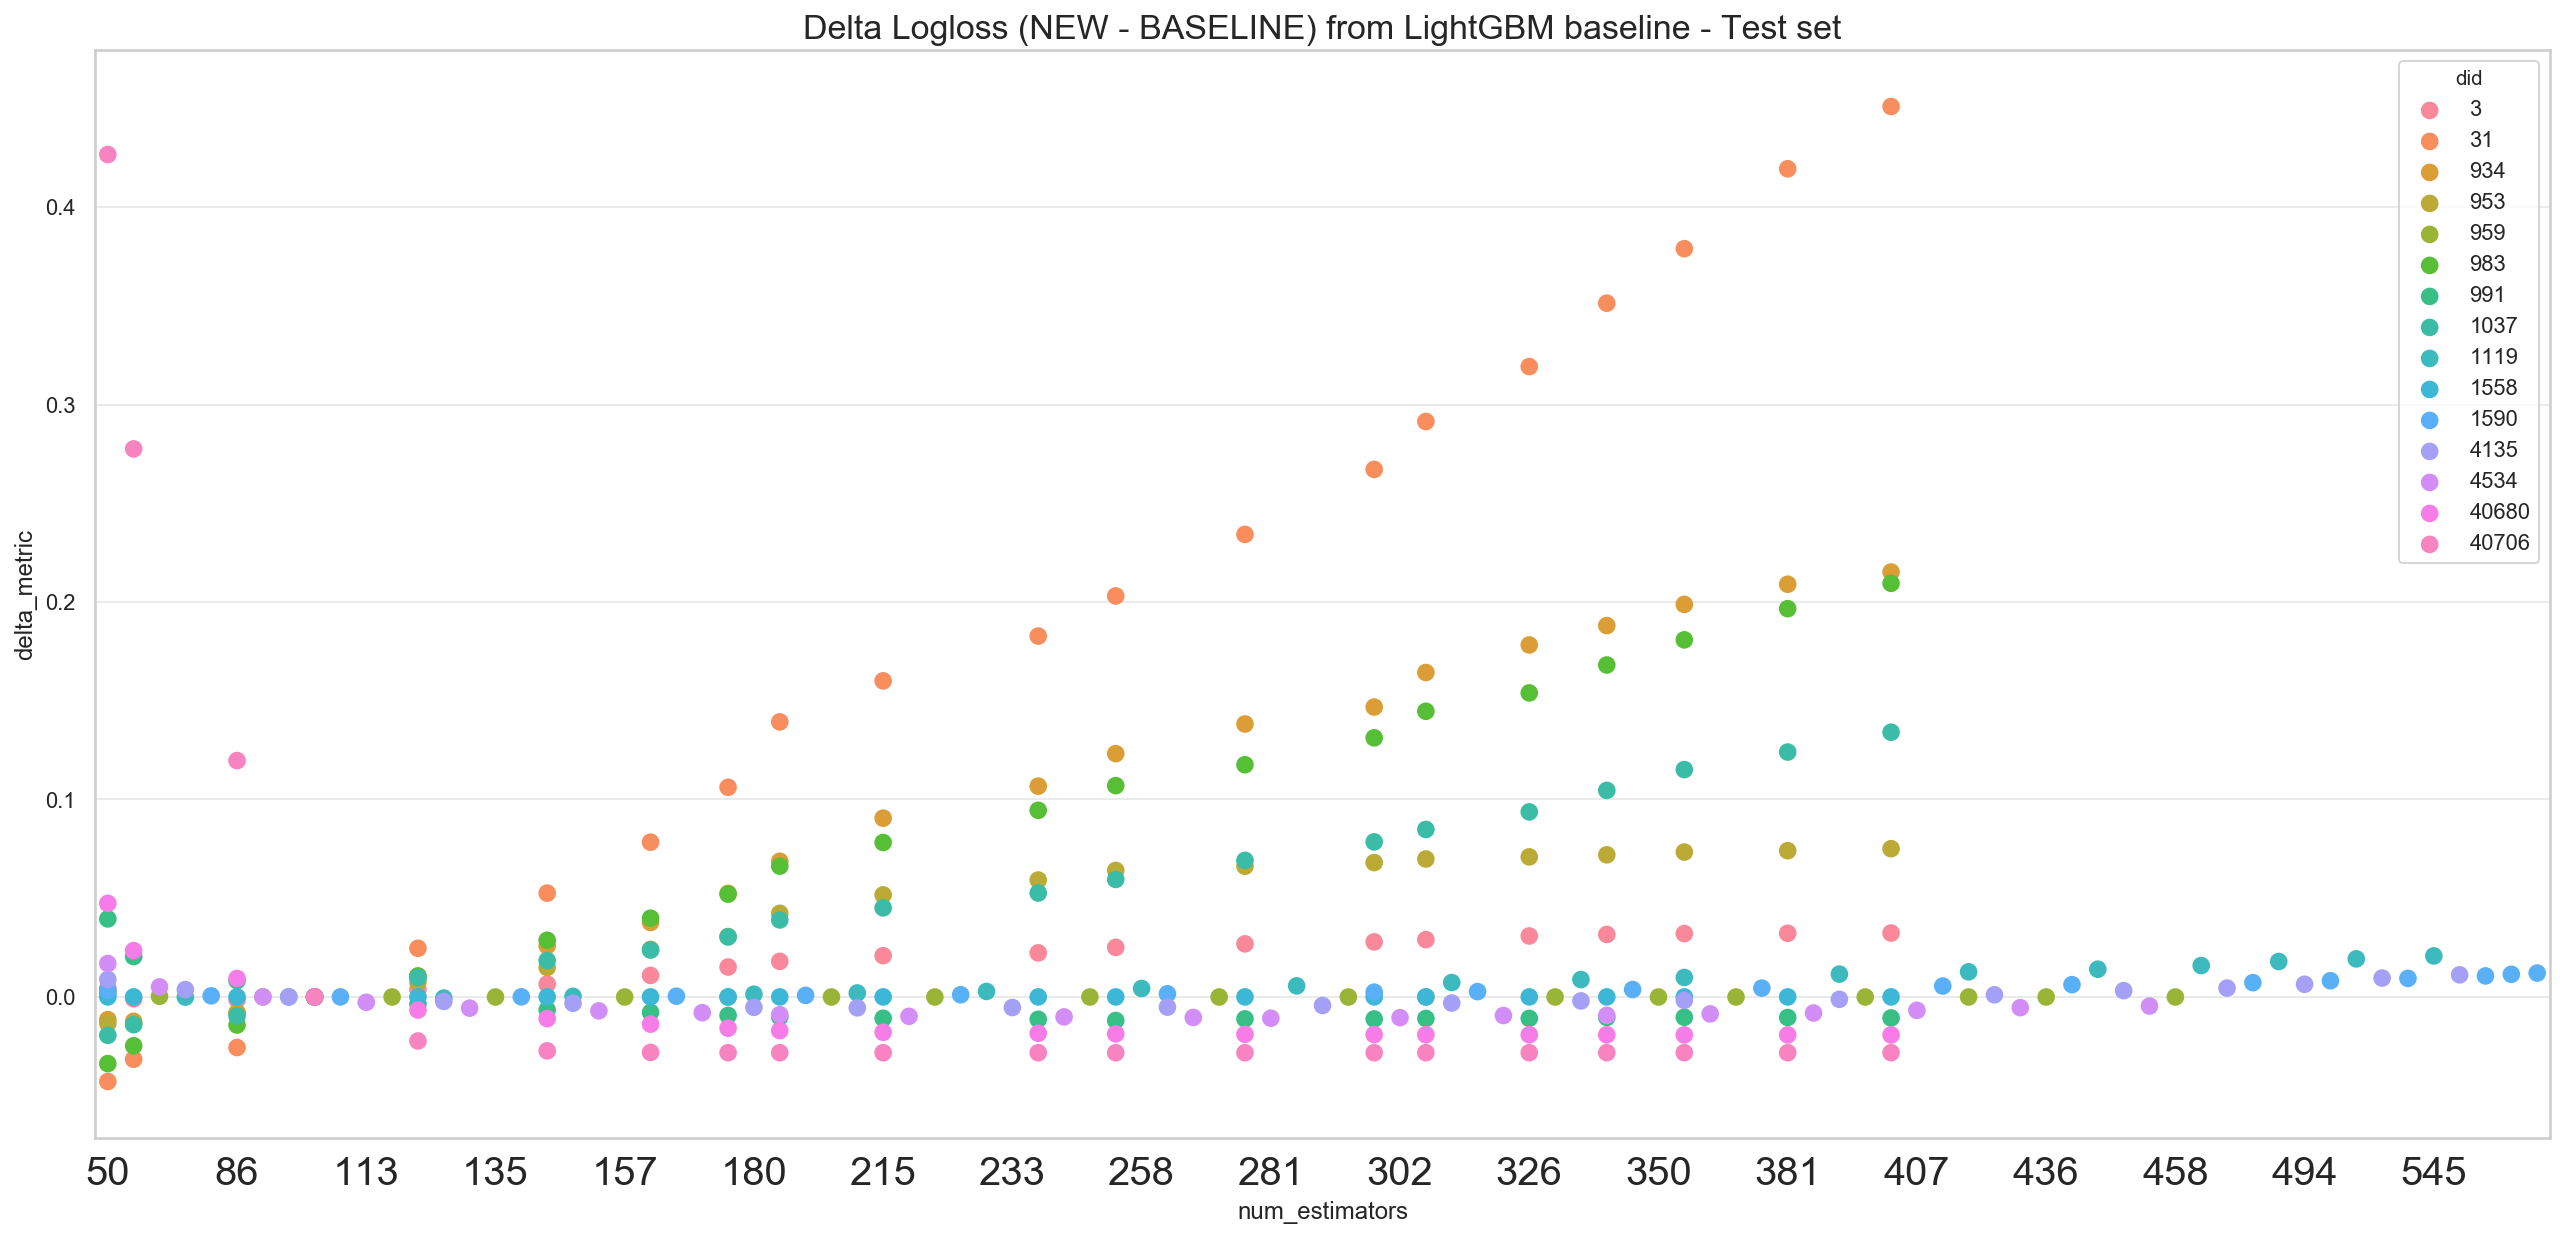

In [12]:
sns.pointplot(
    x="num_estimators",
    y="delta_metric",
    data=num_est_deltas.query(test_pred),
    hue="did",
    linestyles="",
    ci=None,
    ax=new_axis(title="Delta AUC (NEW - BASELINE) from LightGBM baseline - Test set", figsize=(22, 10)),
    s=70,
)
update_pointplot_xlabels()
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=20)
sns.pointplot(
    x="num_estimators",
    y="delta_metric",
    data=num_est_deltas_brier.query(test_pred),
    hue="did",
    linestyles="",
    ci=None,
    ax=new_axis(title="Delta Brier (NEW - BASELINE) from LightGBM baseline - Test set", figsize=(22, 10)),
    s=70,
)
update_pointplot_xlabels()
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=20)
sns.pointplot(
    x="num_estimators",
    y="delta_metric",
    data=num_est_deltas_logloss.query(test_pred),
    hue="did",
    linestyles="",
    ci=None,
    ax=new_axis(title="Delta Logloss (NEW - BASELINE) from LightGBM baseline - Test set", figsize=(22, 10)),
    s=70,
)
update_pointplot_xlabels()
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=20);



### Residuals Analysis

ANOVA requirements

# ANOVA stuff

In [13]:
observations = [
    [160, 575, 542, 530, 539, 570],
    [180, 565, 593, 590, 579, 610],
    [200, 600, 651, 610, 637, 629],
    [220, 725, 700, 715, 685, 710],
]
obs_df = (
    pd.DataFrame(observations, columns=["power", "obs_1", "obs_2", "obs_3", "obs_4", "obs_5"])
    .set_index("power")
    .assign(
        averages=lambda df: df.apply(lambda x: x.mean(), axis=1),
        totals=lambda df: df.drop(columns="averages").apply(lambda x: x.sum(), axis=1),
    )
)
obs_df

obs_1  obs_2  obs_3  obs_4  obs_5  averages  totals
power                                                     
160      575    542    530    539    570     551.2    2756
180      565    593    590    579    610     587.4    2937
200      600    651    610    637    629     625.4    3127
220      725    700    715    685    710     707.0    3535

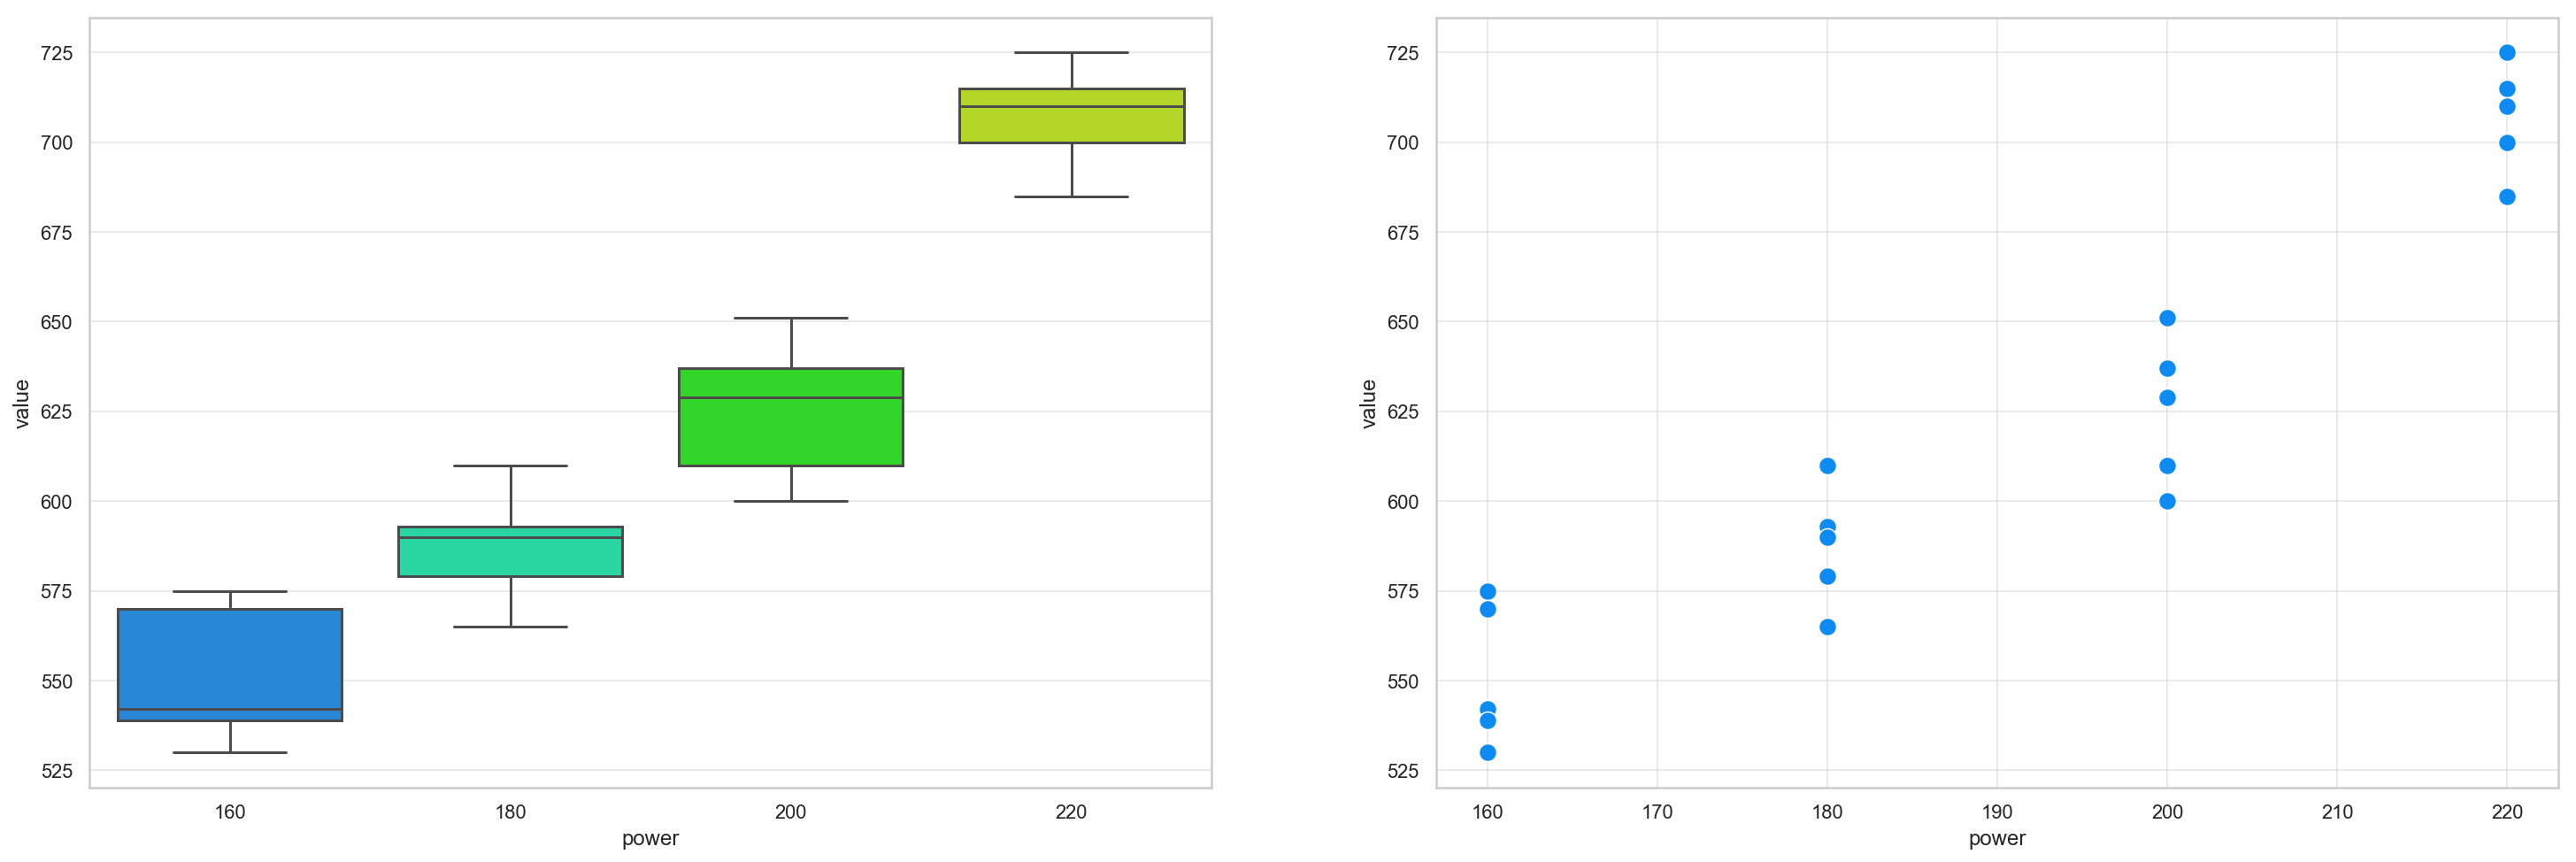

In [14]:
_, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
axes = axs.ravel()
sns.boxplot(
    x="power",
    y="value",
    data=obs_df.reset_index().melt(id_vars=["power"], value_vars=["obs_1", "obs_2", "obs_3", "obs_4", "obs_5"]),
    ax=axes[0],
)
sns.scatterplot(
    x="power",
    y="value",
    data=obs_df.reset_index().melt(id_vars=["power"], value_vars=["obs_1", "obs_2", "obs_3", "obs_4", "obs_5"]),
    ax=axes[1],
    s=100
);

We'll work with melted dfs - too much work to pivot this stuff

In [40]:
melted_df = obs_df.reset_index().melt(id_vars=["power"], value_vars=["obs_1", "obs_2", "obs_3", "obs_4", "obs_5"])
melted_df.sort_values(["power", "variable"]).head()

power variable  value
0     160    obs_1    575
4     160    obs_2    542
8     160    obs_3    530
12    160    obs_4    539
16    160    obs_5    570

In [69]:
def fit_single_factor_model(df, treatment, value_col="value"):
    """ Fit a single-factor model where:
            y_ij = mu + t_i + eps_ij
        The estimates done are:
            mu_pred = mean(Y)
            t_i_pred = mean(Y_i) - mean(Y), for i = 1, 2, ...n
        Intuitively, the overall mean is estimated by the grand average of the observations and
        that any treatment effect is just the difference between the treamtment average and the grand average.
    """
    # treatment must be the the index of the dataframe
    mu_pred = df[value_col].values.mean()
    output_cols = ["treatment_mean", "mu_pred", "tau_i_pred"]
    return (
        df.assign(
            treatment_mean=lambda df: df.groupby(treatment).transform(np.mean)[value_col],
            tau_i_pred=lambda df: df.treatment_mean - mu_pred,
            mu_pred=mu_pred,
        )
        .groupby(treatment)[output_cols]
        .agg("first")
    )

In [70]:
observations_cols = ["obs_1", "obs_2", "obs_3", "obs_4", "obs_5"]
sfm_params = fit_single_factor_model(melted_df, treatment="power", value_col="value")
sfm_params

treatment_mean  mu_pred  tau_i_pred
power                                     
160             551.2   617.75      -66.55
180             587.4   617.75      -30.35
200             625.4   617.75        7.65
220             707.0   617.75       89.25

Residuals

In [90]:
import scipy.stats as stats
import pingouin as pg


def plot_residuals(df, sfm_params, treatment, value_col="value", normalize=True, scipy_plot=False):
    residuals_df = df.merge(right=sfm_params, on=treatment).assign(
        y_treatment_pred=lambda df: df.mu_pred + df.tau_i_pred, residual=lambda df: df[value_col] - df.y_treatment_pred
    )
    residuals_vector = residuals_df.residual.values
    if normalize:
        res = (residuals_vector - np.mean(residuals_vector)) / np.std(residuals_vector)
    else:
        res = residuals_vector
    if scipy_plot:
        stats.probplot(res, plot=new_axis())
    else:
        pg.qqplot(res, dist="norm", ax=new_axis())
    return residuals_df

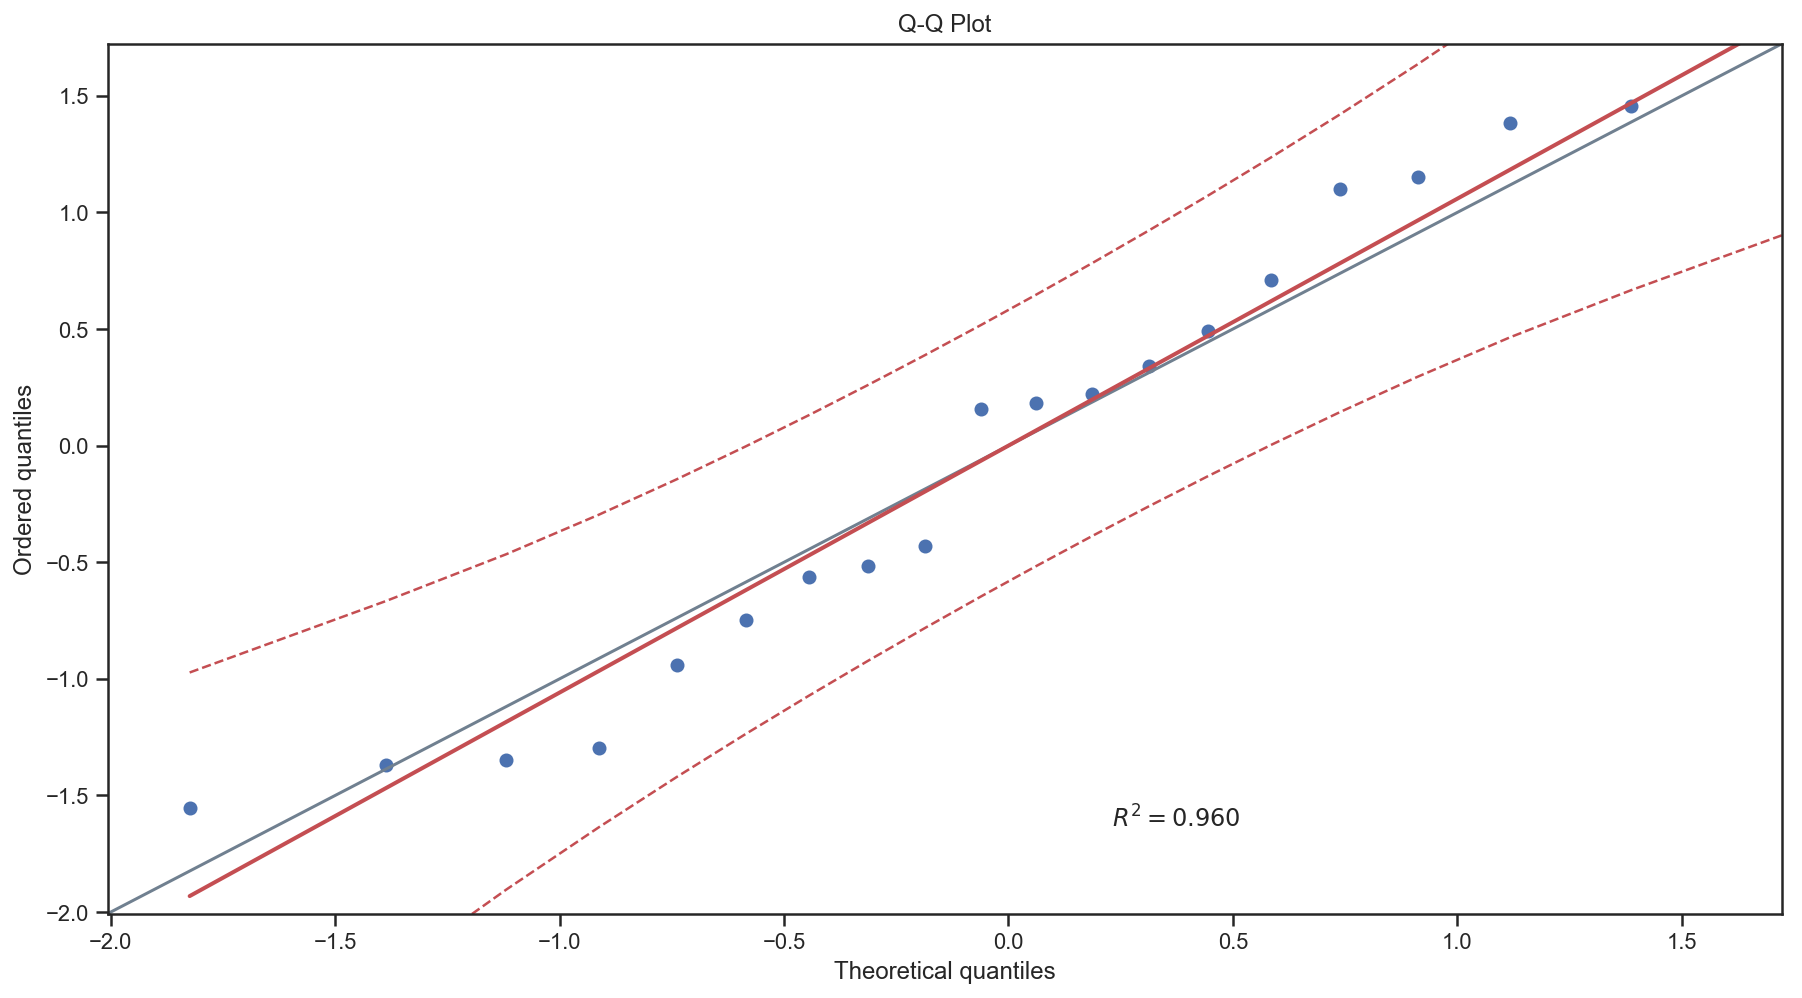

In [50]:
residuals_df = plot_residuals(df=melted_df, sfm_params=sfm_params, treatment="power", value_col="value")

## YAY

AUC

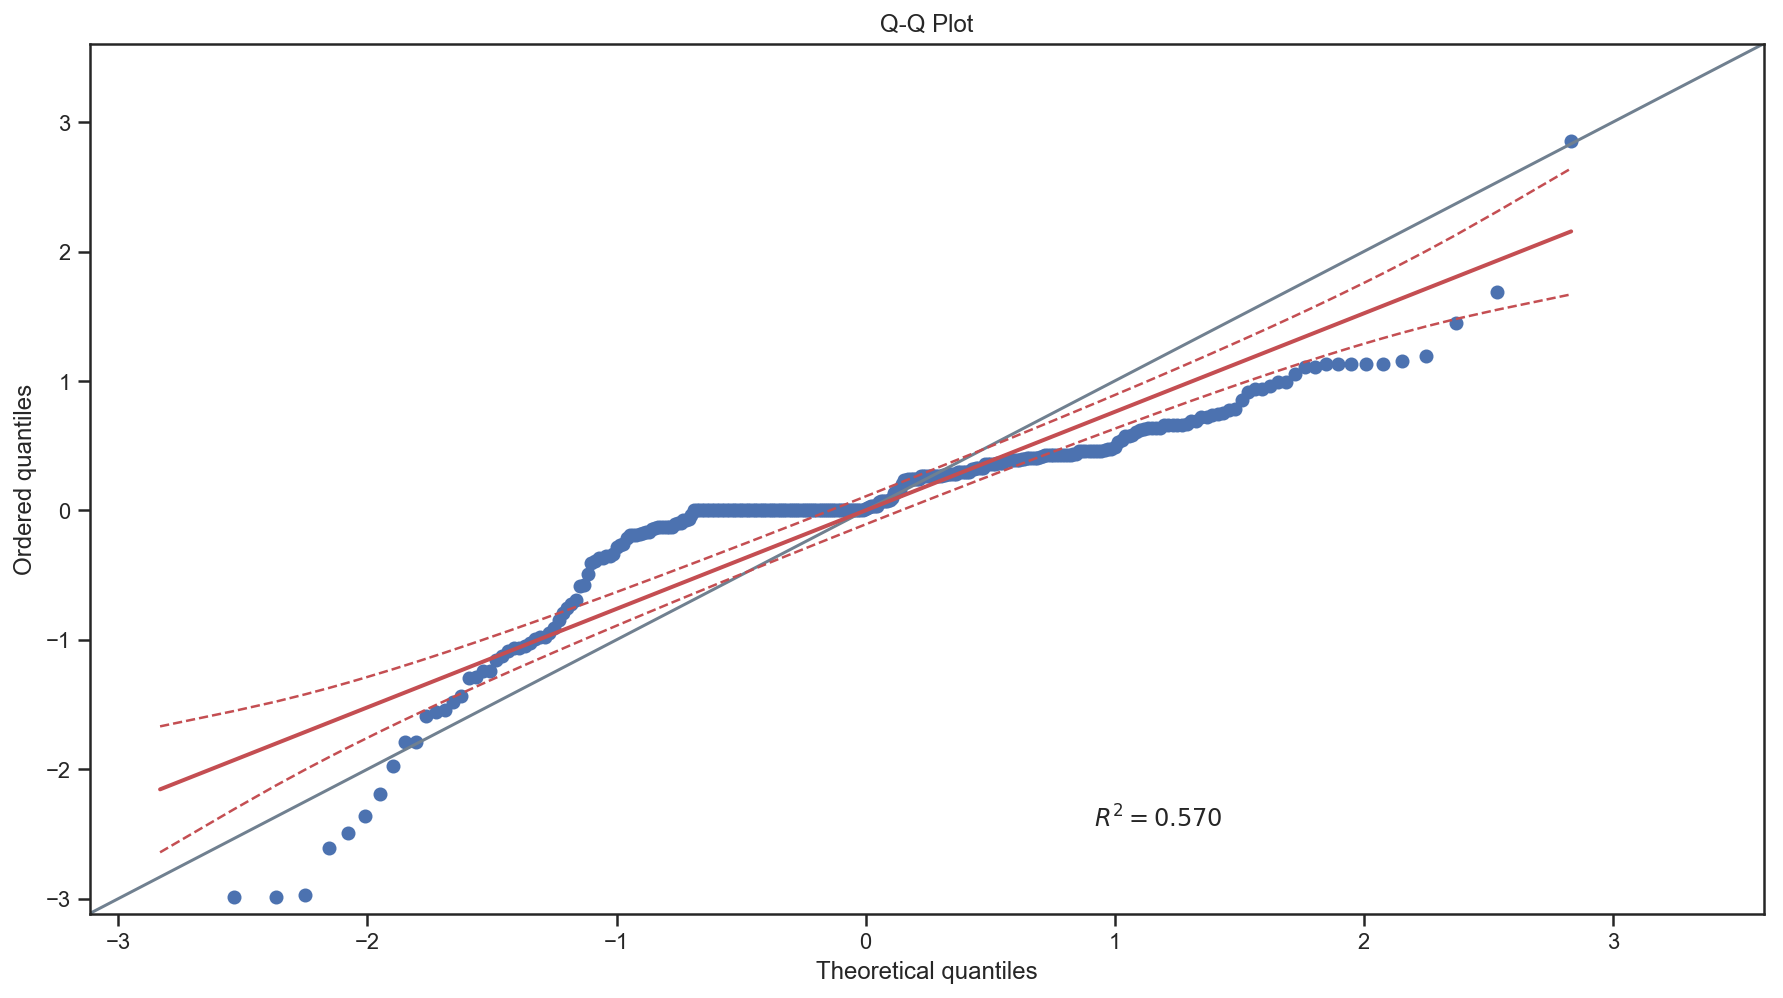

In [94]:
num_est_auc_indexed = num_est_deltas.query(test_pred).reset_index(drop=True)
_ = plot_residuals(
    df=num_est_auc_indexed,
    sfm_params=fit_single_factor_model(num_est_auc_indexed, treatment="num_estimators", value_col="delta_metric"),
    treatment="num_estimators",
    value_col="delta_metric"
)

BRIER

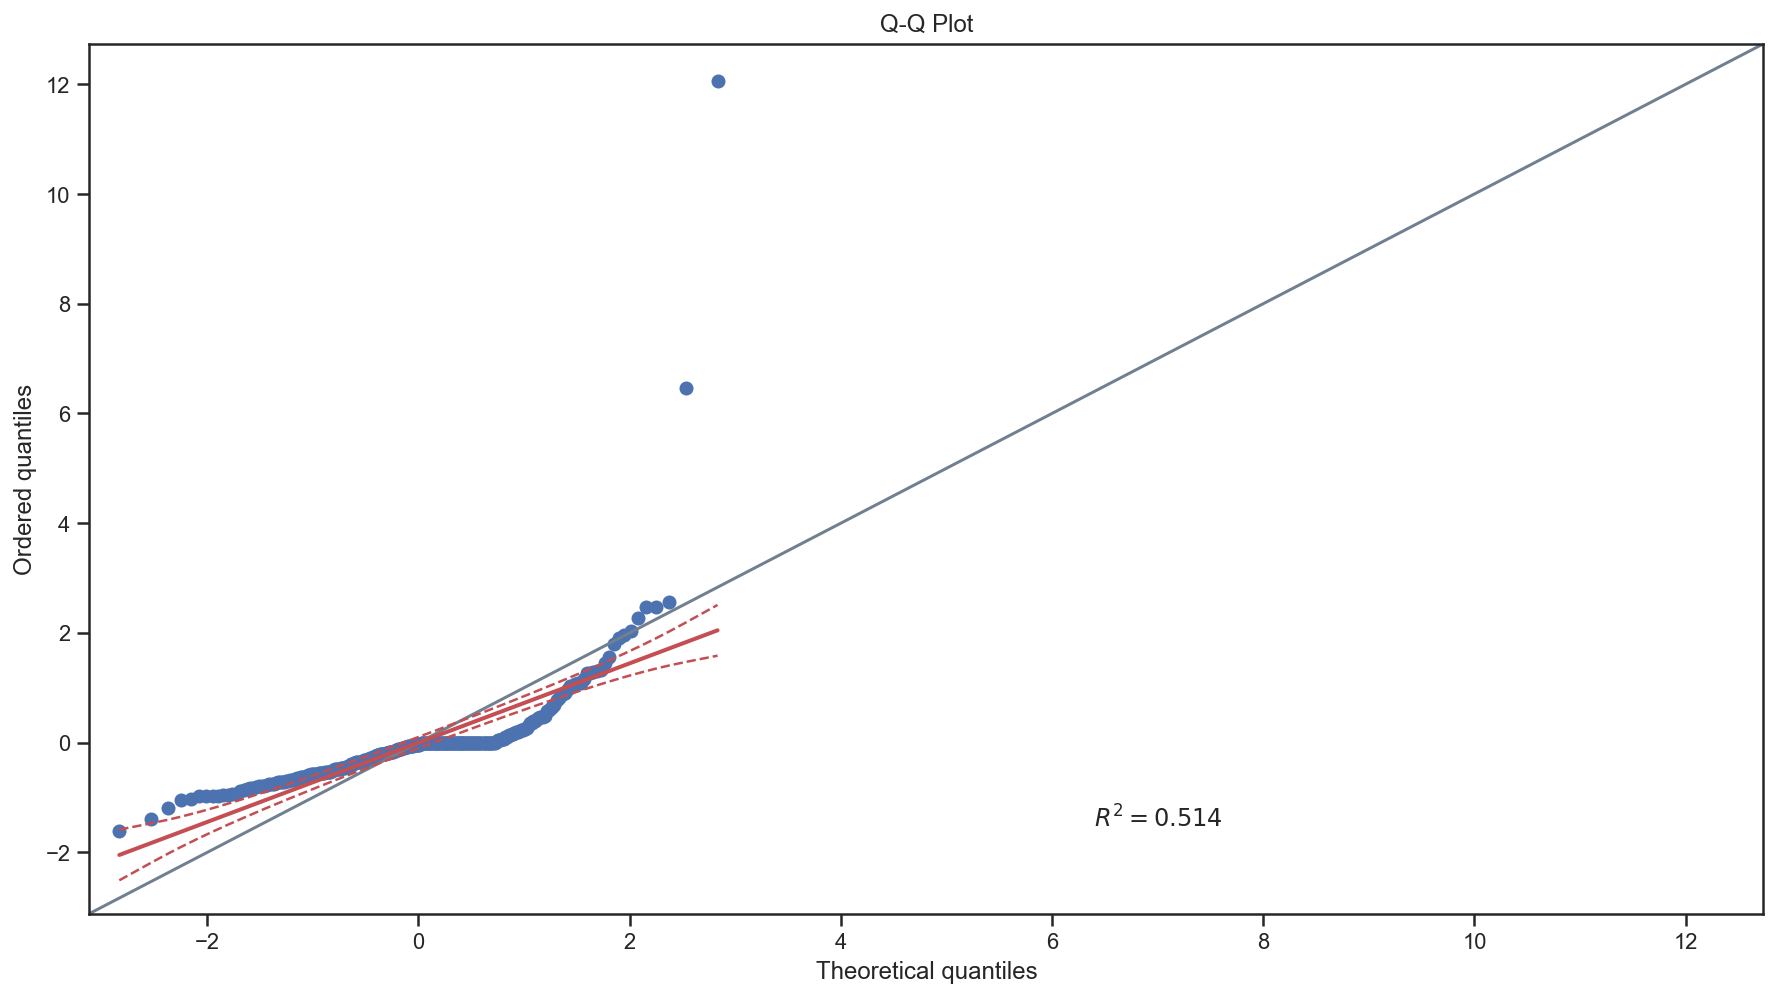

In [101]:
num_est_brier_indexed = num_est_deltas_brier.query(test_pred).reset_index(drop=True)
_ = plot_residuals(
    df=num_est_brier_indexed,
    sfm_params=fit_single_factor_model(num_est_brier_indexed, treatment="num_estimators", value_col="delta_metric"),
    treatment="num_estimators",
    value_col="delta_metric",
#     scipy_plot=True,
)

Logloss

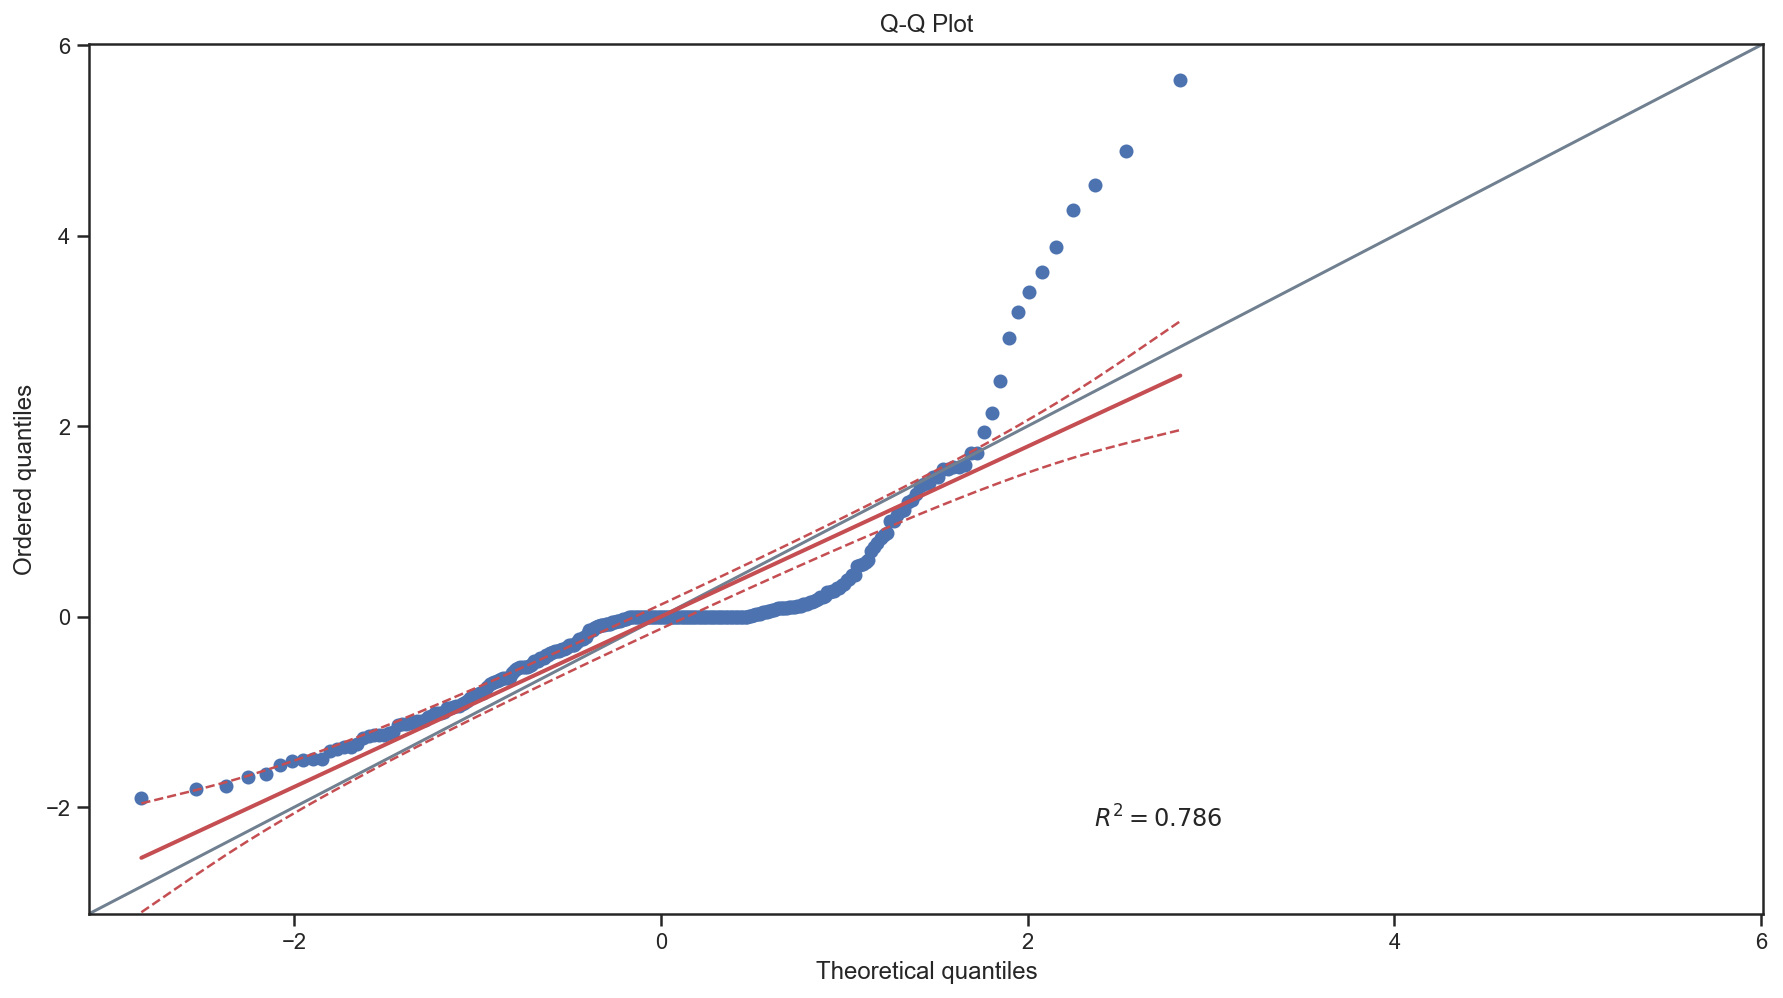

In [100]:
num_est_logloss_indexed = num_est_deltas_logloss.query(test_pred).reset_index(drop=True)
_ = plot_residuals(
    df=num_est_logloss_indexed,
    sfm_params=fit_single_factor_model(num_est_logloss_indexed, treatment="num_estimators", value_col="delta_metric"),
    treatment="num_estimators",
    value_col="delta_metric",
    scipy_plot=True,
)